# DATA DICTIONARY

## Variable	Description:

 **GAME_ID:**	Unique id number of the game.

 **DATE:**	Date the game took place.

 **HOME_TEAM:**	Team playing at home.

 **AWAY_TEAM:**	Team playing away from home.

 **PLAYER_NAME:**	Name of the shooting player.

 **PLAYER_ID:**	Unique ID number of the shooting player.

 **LOCATION:**	Whether the player was on the home (H) or away (A) team.

**W:**	Whether the player's team won (W) or lost (L) the game.

**FINAL_MARGIN:**	The final margin for the player's team (negative means defeat).

**SHOT_NUMBER:**The number of the shot taken by the shooting player in that game.

 **PERIOD:**	The period of the game that the shot was taken. A value of 5 or greater indicates that the game was tied after 4 quarters, and that the shot was taken in an overtime period.

 **GAME_CLOCK:**	Time display on the game clock when the shot was taken.

**SHOT_CLOCK:**	The time remaining on the shot clock (the time limit in the NBA is 24 seconds).

**DRIBBLES:**	Number of dribbles by the player before the shot was taken.

**TOUCH_TIME:**	The time that the ball was in the shooting player's hand.

**SHOT_DIST:**	The distance of the shooting player from the basket.

**PTS_TYPE:**	2 for shots from inside the arc, 3 for shots from outside the arc.

**SHOT_RESULT:**	"made" or "missed".

**CLOSEST_DEFENDER:**	Name of the nearest defender when the shot was taken.

**CLOSEST_DEFENDER_ID:**	Unique id number of the nearest defender.

**CLOSE_DEF_DIST:**	Distance of the nearest defender when the shot was taken.

**FGM:**	Equal to 1 if the shot was made (scored) otherwise 0.

**PTS:**	The number of points scored with the shot.

# Importing the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import ttest_ind, f_oneway
from scipy.stats import chi2_contingency
from scipy.stats import chi2_contingency, fisher_exact, ttest_ind
from scipy.stats import binomtest
from scipy.stats import norm
from scipy.stats import chi2_contingency
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.outliers_influence import variance_inflation_factor

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve, average_precision_score
import pickle

# Importing the Dataset and reading it

In [2]:
nba_data = pd.read_csv('/content/NBA_Shots_Raw.csv',low_memory=False)
pinfo = pd.read_csv('/content/Player_Info.csv',low_memory=False)
pstats=pd.read_csv('/content/Player_Game_Stats_1949_2024.csv',low_memory=False)
nba_data.head(2)

GAME_ID          DATE HOME_TEAM AWAY_TEAM PLAYER_NAME  PLAYER_ID LOCATION  \
0  21400001  OCT 28, 2014       NOP       ORL   Omer Asik     201600        H   
1  21400001  OCT 28, 2014       NOP       ORL   Omer Asik     201600        H   

   W  FINAL_MARGIN  SHOT_NUMBER  ...  DRIBBLES TOUCH_TIME  SHOT_DIST  \
0  W            17            1  ...         0        0.8        3.6   
1  W            17            2  ...         1        2.9        0.9   

   PTS_TYPE  SHOT_RESULT  CLOSEST_DEFENDER  CLOSEST_DEFENDER_ID  \
0         2         made    Nikola Vucevic               202696   
1         2       missed      Kyle O'Quinn               203124   

  CLOSE_DEF_DIST FGM  PTS  
0            1.7   1    2  
1            2.0   0    0  

[2 rows x 23 columns]

In [3]:
pinfo.head(1)

Unnamed: 0  Age Birth_Place      Birthdate College Experience First_Name  \
0           0   33          mk  July 29, 1982     NaN          1       Pero   

   Height Pos Surname Team  Weight        BMI  
0   207.5  PF   Antic  ATL   117.0  27.173755

# Understanding our Data

In [4]:
pstats.head(1)

SEASON_ID  Player_ID   Game_ID     GAME_DATE      MATCHUP WL  MIN  FGM  \
0      21949      78076  24900560  MAR 19, 1950  SYR vs. AND  W    0    7   

   FGA  FG_PCT  ...  REB  AST  STL  BLK  TOV  PF  PTS  PLUS_MINUS  \
0  NaN     NaN  ...  NaN  NaN  NaN  NaN  NaN NaN   20         NaN   

   VIDEO_AVAILABLE  Date_Game  
0                0        NaN  

[1 rows x 28 columns]

In [5]:
nba_data.shape

(128069, 23)

In [6]:
pinfo.shape

(475, 13)

In [7]:
nba_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128069 entries, 0 to 128068
Data columns (total 23 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   GAME_ID              128069 non-null  int64  
 1   DATE                 128069 non-null  object 
 2   HOME_TEAM            128069 non-null  object 
 3   AWAY_TEAM            128069 non-null  object 
 4   PLAYER_NAME          128069 non-null  object 
 5   PLAYER_ID            128069 non-null  int64  
 6   LOCATION             128069 non-null  object 
 7   W                    128069 non-null  object 
 8   FINAL_MARGIN         128069 non-null  int64  
 9   SHOT_NUMBER          128069 non-null  int64  
 10  PERIOD               128069 non-null  int64  
 11  GAME_CLOCK           128069 non-null  object 
 12  SHOT_CLOCK           122502 non-null  float64
 13  DRIBBLES             128069 non-null  int64  
 14  TOUCH_TIME           128069 non-null  float64
 15  SHOT_DIST        

# Data Pre-Processing

# Data Cleaning

# Data Cleaning and Correction

In [8]:
nba_data['DATE'] = pd.to_datetime(nba_data['DATE'], format='%b %d, %Y')

nba_data['MATCH_OUTCOME'] = nba_data['W'].map({'W': 1, 'L': 0}).astype(int)

nba_data['SHOT_RESULT'] = nba_data['SHOT_RESULT'].map({'made': 1, 'missed': 0}).astype(int)

nba_data['MATCH_LOCATION'] = nba_data['LOCATION'].map({'H': 1, 'A': 0}).astype(int)

nba_data['GAME_CLOCK_SECONDS'] = nba_data['GAME_CLOCK'].apply(lambda x: int(x.split(':')[0]) * 60 + int(x.split(':')[1]))

nba_data['GAME_MINUTES'] = nba_data['PERIOD'] * 12 - nba_data['GAME_CLOCK_SECONDS']/60

In [9]:
pinfo['Birthdate'] = pd.to_datetime(pinfo['Birthdate'], format='%B %d, %Y')

pinfo['EXPERIENCE_NUM'] = pd.to_numeric(pinfo['Experience'].replace('R', '0'))

pinfo = pinfo.rename(columns={'Height': 'PLAYER_HEIGHT', 'Weight': 'PLAYER_WEIGHT', 'Pos': 'POSITION','College': 'COLLEGE','Team':'TEAM','Birth_Place':'BIRTH_PLACE'})

In [10]:
# Function to correct player names
def correct_player_name(df, incorrect_name, correct_name):
    player_indices = df['PLAYER_NAME'] == incorrect_name
    defender_indices = df['CLOSEST_DEFENDER'] == incorrect_name

    df.loc[player_indices, 'PLAYER_NAME'] = correct_name
    df.loc[defender_indices, 'CLOSEST_DEFENDER'] = correct_name

    print(f"Corrected {incorrect_name} to {correct_name}")
    print(f"  As player: {sum(player_indices)}")
    print(f"  As defender: {sum(defender_indices)}")

# List of corrections
corrections = [
    ('Jon Ingles', 'Joe Ingles'),
    ('Jimmer Dredette', 'Jimmer Fredette'),
    ('Mnta Ellis', 'Monta Ellis'),
    ('Dirk Nowtizski', 'Dirk Nowitzki'),
    ('Danilo Gallinai', 'Danilo Gallinari'),
    ('Nerles Noel', 'Nerlens Noel'),
    ('Beno Urdih', 'Beno Udrih'),
    ('Dwayne Wade', 'Dwyane Wade'),
    ('Alan Crabbe', 'Allen Crabbe')
]

# Apply corrections
for incorrect, correct in corrections:
    correct_player_name(nba_data, incorrect, correct)

Corrected Jon Ingles to Joe Ingles
  As player: 220
  As defender: 0
Corrected Jimmer Dredette to Jimmer Fredette
  As player: 151
  As defender: 0
Corrected Mnta Ellis to Monta Ellis
  As player: 1052
  As defender: 0
Corrected Dirk Nowtizski to Dirk Nowitzki
  As player: 816
  As defender: 0
Corrected Danilo Gallinai to Danilo Gallinari
  As player: 351
  As defender: 0
Corrected Nerles Noel to Nerlens Noel
  As player: 444
  As defender: 0
Corrected Beno Urdih to Beno Udrih
  As player: 356
  As defender: 0
Corrected Dwayne Wade to Dwyane Wade
  As player: 703
  As defender: 0
Corrected Alan Crabbe to Allen Crabbe
  As player: 94
  As defender: 0


In [11]:
pinfo['PLAYER_NAME'] = pinfo['First_Name'] + ' ' + pinfo['Surname']
pinfo = pinfo.drop(['First_Name', 'Surname','Unnamed: 0'], axis=1)

In [12]:
# pstats['GAME_DATE'] = pd.to_datetime(pstats['GAME_DATE'], format='%b %d, %Y')

# # Extract year from GAME_DATE
# pstats['YEAR'] = pstats['GAME_DATE'].dt.year

# #Check for any rows where YEAR is NaT (Not a Time)
# print("\nRows with invalid dates:")
# print(pstats[pstats['YEAR'].isna()])

# # Remove rows with invalid dates
# pstats = pstats.dropna(subset=['YEAR'])

# #Convert relevant columns to numeric, replacing any non-numeric values with NaN
# numeric_columns = ['FGM', 'FGA', 'FG3M', 'FG3A']
# for col in numeric_columns:
#     pstats[col] = pd.to_numeric(pstats[col], errors='coerce')

# pstats['FG2_PCT'] = np.where(
#     (pstats['FGA'] - pstats['FG3A']) != 0,
#     (pstats['FGM'] - pstats['FG3M']) / (pstats['FGA'] - pstats['FG3A']),
#     np.nan
# )
# pstats['FG3_PCT'] = np.where(pstats['FG3A'] != 0, pstats['FG3M'] / pstats['FG3A'], np.nan)
# pinfo.head(1)

### Renaming columns to avoid conflicts

In [13]:
pstats = pstats.rename(columns={
    'Player_ID': 'PLAYER_ID',
    'Game_ID': 'GAME_ID',
})

### Finding how many variables are still in Object Datatype for Nba_data

In [14]:
# Finding how many Object datatypes are left since others are not specific categories we convert them to category codes
obj_cols = []
for col_name, content in nba_data.items():
    if pd.api.types.is_string_dtype(content):
        obj_cols.append(col_name)
        print(col_name)

num_cols = len(obj_cols)

print() # For space between outputs

print(f'The total number of object colums are {num_cols}')

HOME_TEAM
AWAY_TEAM
PLAYER_NAME
LOCATION
W
GAME_CLOCK
CLOSEST_DEFENDER

The total number of object colums are 7


## Finding how many variables are still in Object Datatype for pinfo

In [15]:
obj_cols = []
for col_name, content in pinfo.items():
    if pd.api.types.is_string_dtype(content):
        obj_cols.append(col_name)
        print(col_name)

num_cols = len(obj_cols)

print() # For space between outputs

print(f'The total number of object colums are {num_cols}')

BIRTH_PLACE
Experience
POSITION
TEAM
PLAYER_NAME

The total number of object colums are 5


## Changing columns to Categories with codes as well as retaining its original column to map back it it.

In [16]:
# Cat Codes for NBA_DATA
categorical_columns = ['HOME_TEAM', 'AWAY_TEAM', 'PLAYER_NAME', 'CLOSEST_DEFENDER']

# Dictionary to capture the mappings
category_mappings = {}

for column in categorical_columns:
    # Convert to category and create codes
    nba_data[f'{column}_CODE'] = nba_data[column].astype('category').cat.codes

    # Store the mapping
    category_mappings[column] = dict(zip(nba_data[f'{column}_CODE'], nba_data[column]))

In [17]:
# Checking if mapping is successful
home_team_check = category_mappings['HOME_TEAM'][9]
print(f"Home team with code 18 is: {home_team_check}")

player_check = category_mappings['PLAYER_NAME'][100]
print(f"Player with code 100 is: {player_check}")

Home team with code 18 is: GSW
Player with code 100 is: Harrison Barnes


In [18]:
# Cat Codes for pinfo

categorical_columns_p_info = ['BIRTH_PLACE','COLLEGE', 'TEAM', 'PLAYER_NAME']

category_mappings_p_info = {}

for column in categorical_columns_p_info:

    pinfo[f'{column}_CODE'] = pinfo[column].astype('category').cat.codes

    # Store the mapping
    category_mappings_p_info[column] = dict(zip(pinfo[f'{column}_CODE'], pinfo[column]))

In [19]:
pinfo_check_PN = category_mappings_p_info['PLAYER_NAME'][3]
print(f"Player Name is: {pinfo_check_PN}")

player_check_info = category_mappings_p_info['PLAYER_NAME'][3]
print(f"Player with code 3 is: {player_check_info}")

Player Name is: Adreian Payne
Player with code 3 is: Adreian Payne


# Finding and Treating Missing Values

In [20]:
# From the isnull function i can see that we have only one column where we have Numeric Rows in the Nba_data
for label,content in nba_data.items():
  if pd.api.types.is_numeric_dtype(content):
    if pd.isnull(content).sum():
      print(label)

SHOT_CLOCK


In [21]:
# We have 4.34% of missing values in our SHOT_CLOCK column
nba_data['SHOT_CLOCK'].isnull().sum()/len(nba_data)*100

4.3468755124190865

### Checking the Distribution of SHOT_CLOCK before imputing the missing values as to see which measures of central tendency can be used such as mean or median.

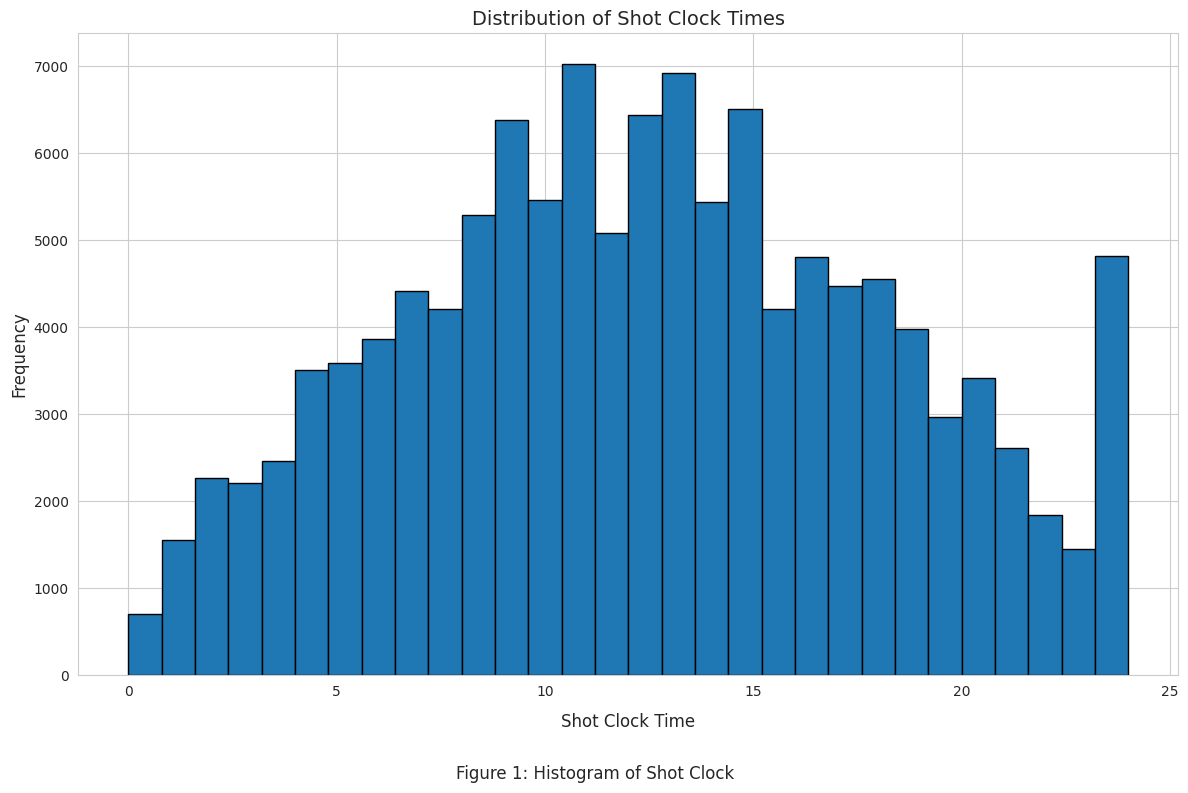

In [22]:
sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))
nba_data.SHOT_CLOCK.hist(bins=30, edgecolor='black')

plt.xlabel('Shot Clock Time', fontsize=12, labelpad=10)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Shot Clock Times', fontsize=14)

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)

plt.figtext(0.5, 0.02, 'Figure 1: Histogram of Shot Clock', ha='center', fontsize=12)

plt.show()

The distribution appears to be sligtly right-skewed.

Given the relatively symmetric distribution, we can use either mean(12.45) or median (12.30) in this case. but if its severly skewed it would be appropriate to use median for imputation as mean tends to get severely influenced by outliers.

I am using median in this case. but we can also use mean since its a relatively symmetric with a slight right skew.

## Imputing missing values for SHOT_CLOCK using median

In [23]:
nba_data['SHOT_CLOCK'].isnull().sum()

5567

In [24]:
# Ensure we are working with a copy to avoid chained assignment warnings
nba_data = nba_data.copy()

# Function to estimate the shot clock
def estimate_shot_clock(game_clock_seconds):
    if isinstance(game_clock_seconds, str):
        minutes, seconds = map(float, game_clock_seconds.split(':'))
        game_clock_seconds = minutes * 60 + seconds

    estimated_shot_clock = game_clock_seconds % 24

    # If estimated shot clock is 0, it's likely a fresh 24
    if estimated_shot_clock == 0:
        estimated_shot_clock = 24

    return round(estimated_shot_clock, 1)

# Apply the estimation correctly
missing_shot_clock_mask = nba_data['SHOT_CLOCK'].isnull()
nba_data.loc[missing_shot_clock_mask, 'SHOT_CLOCK'] = nba_data.loc[missing_shot_clock_mask, 'GAME_CLOCK_SECONDS'].apply(estimate_shot_clock)

# Now fill any remaining NaNs with the median (avoiding inplace=True)
nba_data['SHOT_CLOCK'] = nba_data['SHOT_CLOCK'].fillna(nba_data['SHOT_CLOCK'].median())

print("Shot clock null values:", nba_data['SHOT_CLOCK'].isnull().sum())

# For other numeric columns, use median imputation while avoiding chained assignment
for label in nba_data.select_dtypes(include=[np.number]).columns:
    if label != 'SHOT_CLOCK' and nba_data[label].isnull().sum() > 0:
        nba_data[label + '_is_missing'] = nba_data[label].isnull().astype(int)  # Track missing data
        nba_data[label] = nba_data[label].fillna(nba_data[label].median())  # Fill missing values


Shot clock null values: 0


In [25]:
# Median is 15.0
nba_data['SHOT_CLOCK'][11853]

15.0

In [26]:
# Checking to see if values are treated
nba_data.isnull().sum()

GAME_ID                  0
DATE                     0
HOME_TEAM                0
AWAY_TEAM                0
PLAYER_NAME              0
PLAYER_ID                0
LOCATION                 0
W                        0
FINAL_MARGIN             0
SHOT_NUMBER              0
PERIOD                   0
GAME_CLOCK               0
SHOT_CLOCK               0
DRIBBLES                 0
TOUCH_TIME               0
SHOT_DIST                0
PTS_TYPE                 0
SHOT_RESULT              0
CLOSEST_DEFENDER         0
CLOSEST_DEFENDER_ID      0
CLOSE_DEF_DIST           0
FGM                      0
PTS                      0
MATCH_OUTCOME            0
MATCH_LOCATION           0
GAME_CLOCK_SECONDS       0
GAME_MINUTES             0
HOME_TEAM_CODE           0
AWAY_TEAM_CODE           0
PLAYER_NAME_CODE         0
CLOSEST_DEFENDER_CODE    0
dtype: int64

In [27]:
pinfo.isnull().sum()

Age                  0
BIRTH_PLACE          0
Birthdate            0
COLLEGE             80
Experience           0
PLAYER_HEIGHT        0
POSITION             0
TEAM                 0
PLAYER_WEIGHT        0
BMI                  0
EXPERIENCE_NUM       0
PLAYER_NAME          0
BIRTH_PLACE_CODE     0
COLLEGE_CODE         0
TEAM_CODE            0
PLAYER_NAME_CODE     0
dtype: int64

# Outlier Engineering

In [28]:
def plot_boxplot_and_hist(data, variable, color, fig_number):
    f, (ax_box, ax_hist) = plt.subplots(
        2, sharex=True, figsize=(12, 10), gridspec_kw={"height_ratios": (0.35, 0.65)}
    )

    num_bins = int(np.log2(len(data)) + 1)

    sns.boxplot(x=data[variable], ax=ax_box, color=color)
    sns.histplot(data=data, x=variable, ax=ax_hist, color=color, bins=num_bins, kde=False, stat='density')

    # Add KDE line
    sns.kdeplot(data=data[variable], ax=ax_hist, color='darkred', lw=2)

    ax_box.set(xlabel="")
    ax_hist.set_xlabel(variable, fontsize=12)
    ax_hist.set_ylabel('Density', fontsize=12)

    # Adjust title
    plt.suptitle(f'Distribution of {variable}', fontsize=16, y=0.98, fontweight='bold')

    # Remove the top title from the boxplot subplot
    ax_box.set_title("")

    # Add figure caption
    plt.figtext(0.5, 0.01, f'Figure {fig_number}: Boxplot and Histogram for {variable}',
                ha='center', fontsize=12)

    plt.tight_layout()
    plt.subplots_adjust(top=0.93, bottom=0.1)  # Adjust top margin for title and bottom for caption
    plt.show()

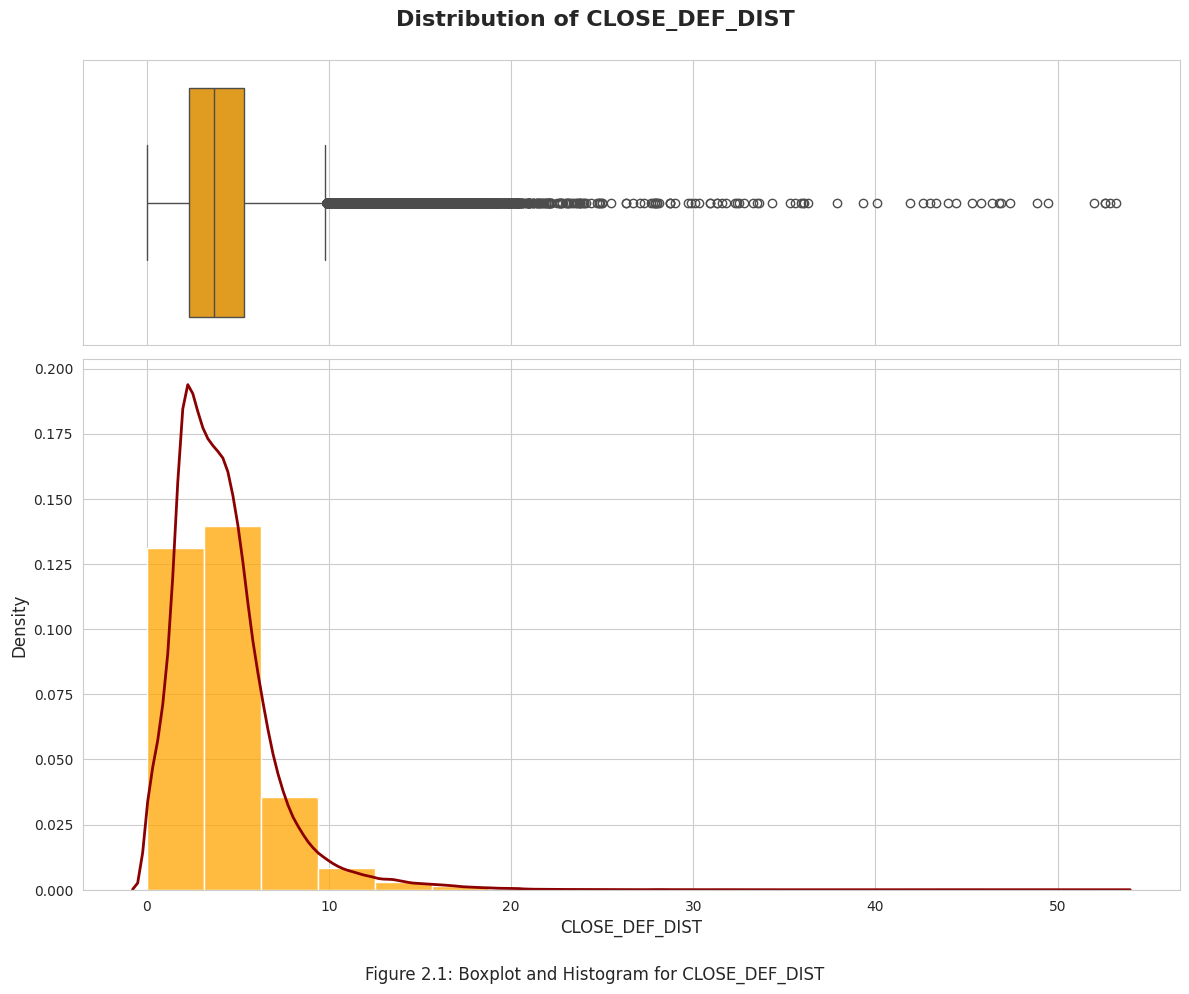


Statistics for CLOSE_DEF_DIST:
count    128069.000000
mean          4.123015
std           2.756446
min           0.000000
25%           2.300000
50%           3.700000
75%           5.300000
max          53.200000
Name: CLOSE_DEF_DIST, dtype: float64


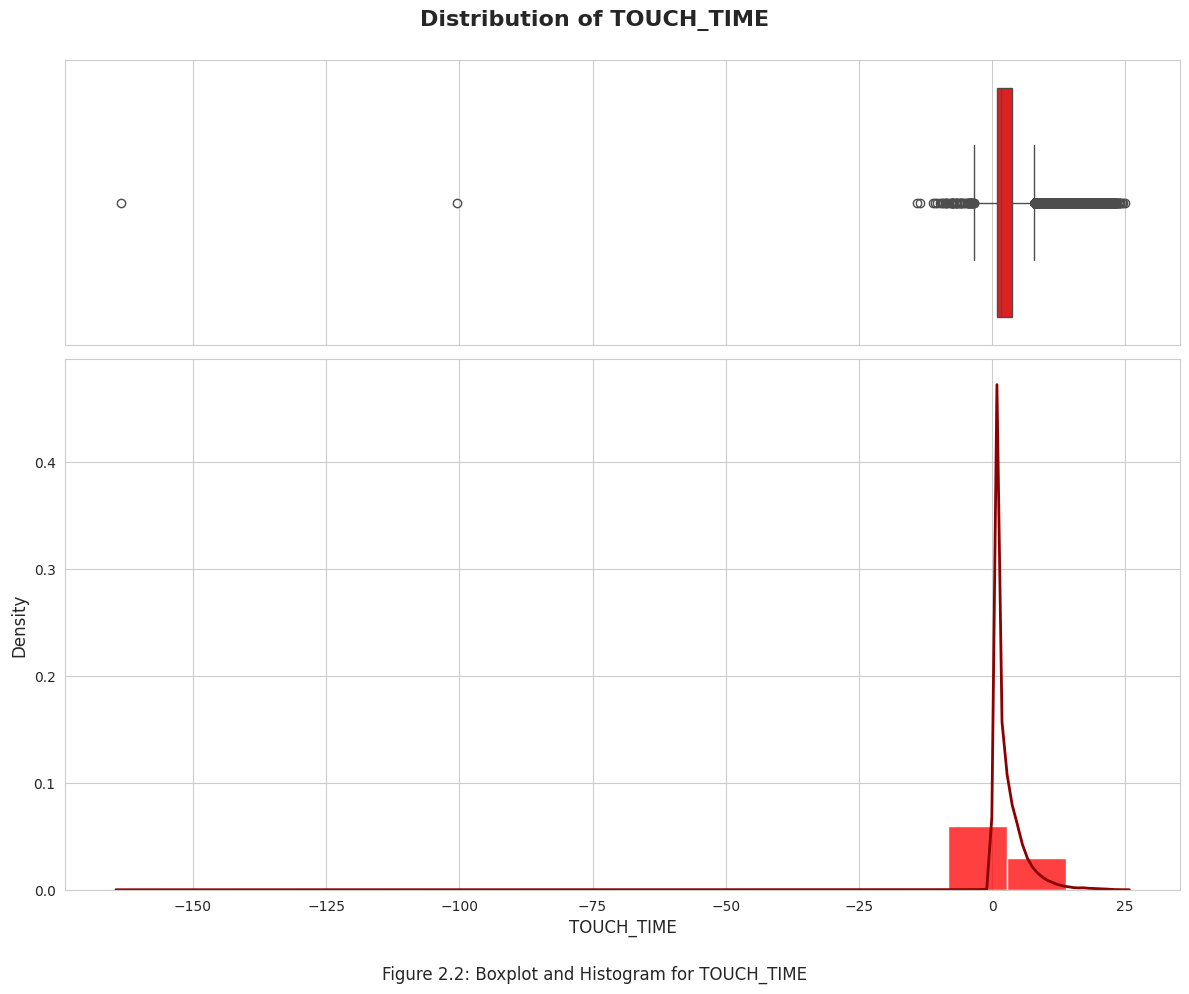


Statistics for TOUCH_TIME:
count    128069.000000
mean          2.765901
std           3.043682
min        -163.600000
25%           0.900000
50%           1.600000
75%           3.700000
max          24.900000
Name: TOUCH_TIME, dtype: float64


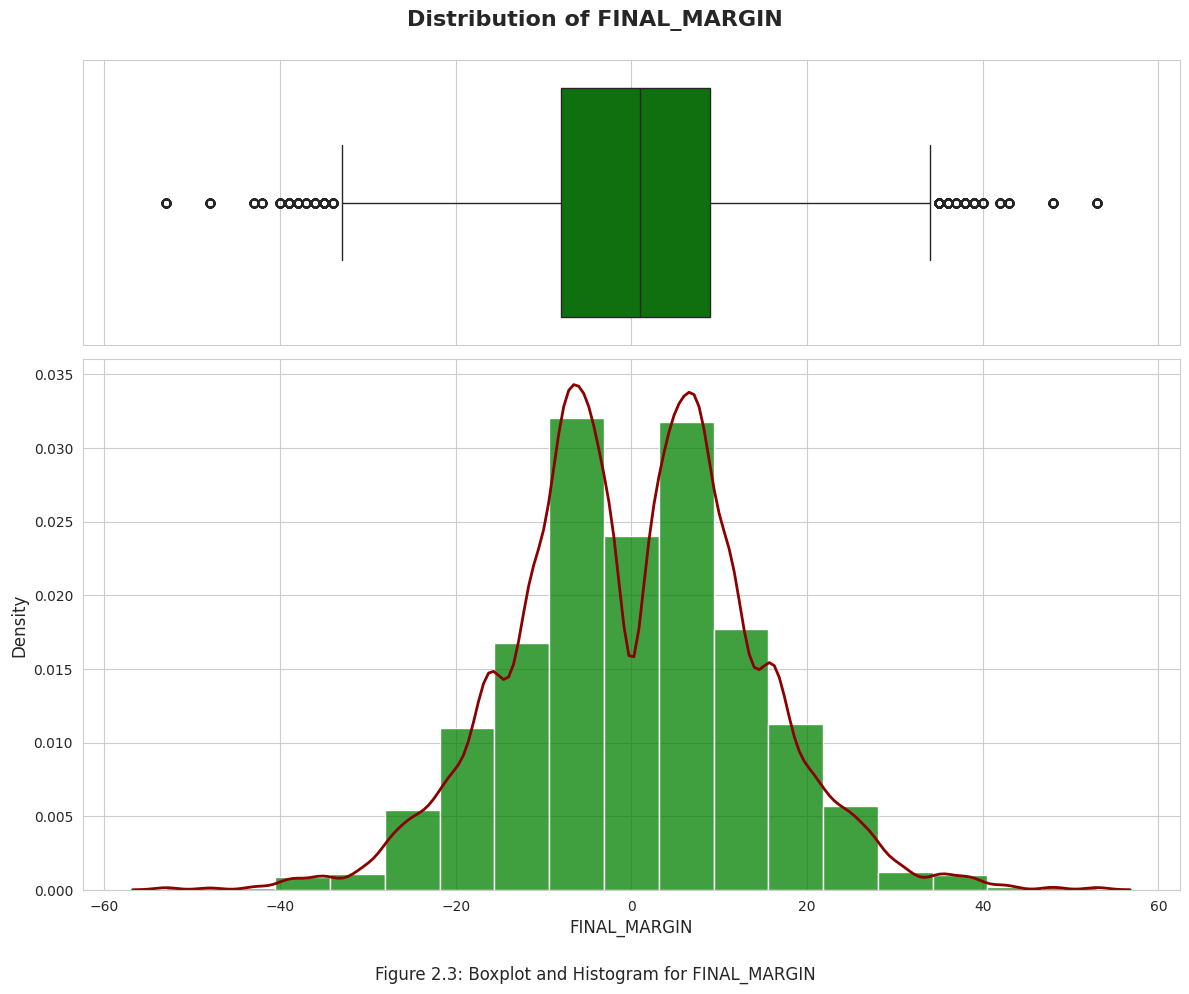


Statistics for FINAL_MARGIN:
count    128069.000000
mean          0.208723
std          13.233267
min         -53.000000
25%          -8.000000
50%           1.000000
75%           9.000000
max          53.000000
Name: FINAL_MARGIN, dtype: float64


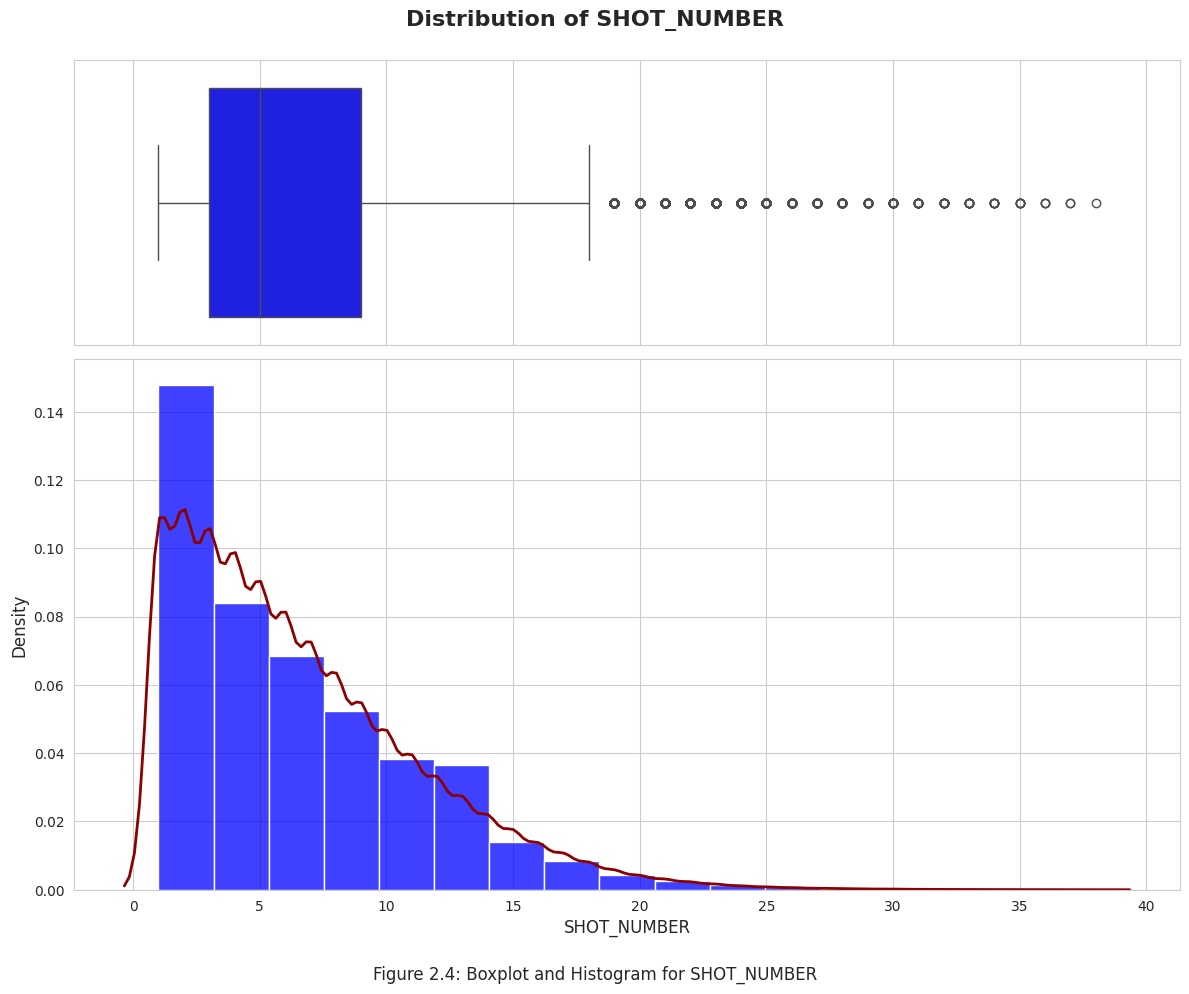


Statistics for SHOT_NUMBER:
count    128069.000000
mean          6.506899
std           4.713260
min           1.000000
25%           3.000000
50%           5.000000
75%           9.000000
max          38.000000
Name: SHOT_NUMBER, dtype: float64


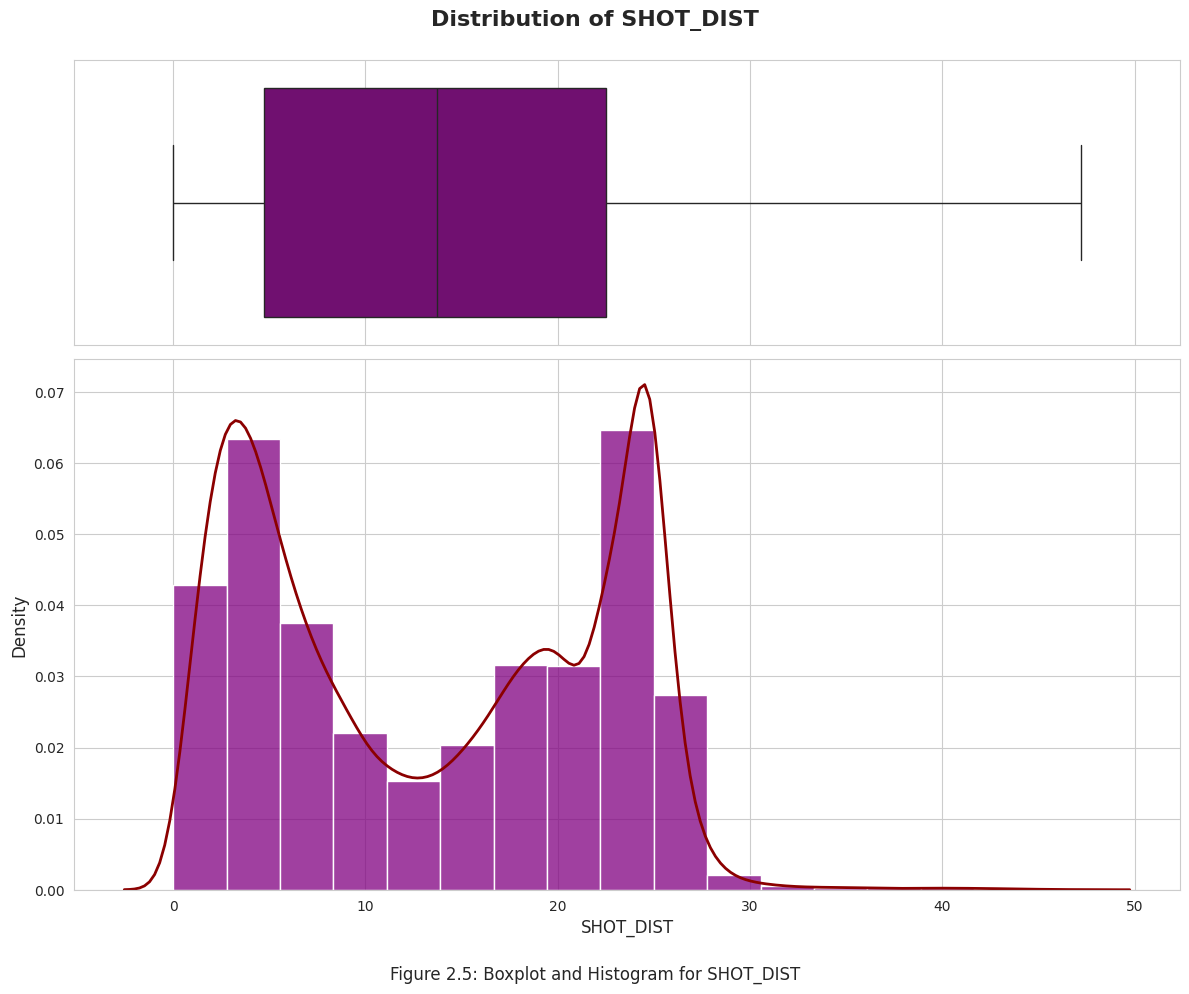


Statistics for SHOT_DIST:
count    128069.000000
mean         13.571504
std           8.888964
min           0.000000
25%           4.700000
50%          13.700000
75%          22.500000
max          47.200000
Name: SHOT_DIST, dtype: float64


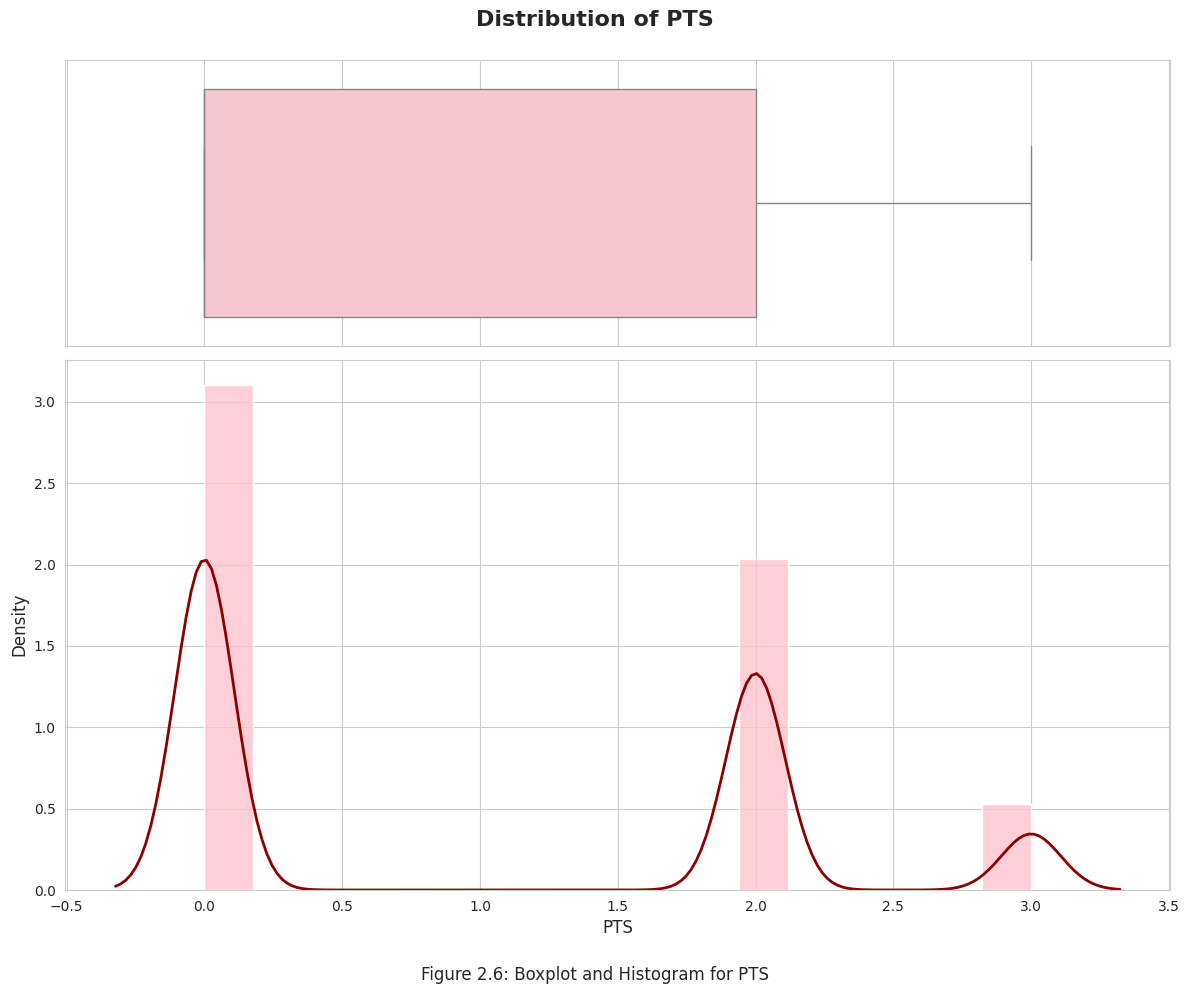


Statistics for PTS:
count    128069.000000
mean          0.997314
std           1.130978
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max           3.000000
Name: PTS, dtype: float64


In [29]:
num_cols = ['CLOSE_DEF_DIST', 'TOUCH_TIME', 'FINAL_MARGIN', 'SHOT_NUMBER', 'SHOT_DIST', 'PTS']

colors = ['orange', 'red', 'green', 'blue', 'purple', 'pink']

for i, (col, color) in enumerate(zip(num_cols, colors), 1):
    fig_number = f"2.{i}"

    plot_boxplot_and_hist(nba_data, col, color=color, fig_number=fig_number)

    print(f"\nStatistics for {col}:")
    print(nba_data[col].describe())

In [30]:
# # Create a copy of the original dataframe to do Outlier Treating
# nba_data_treated = nba_data.copy()

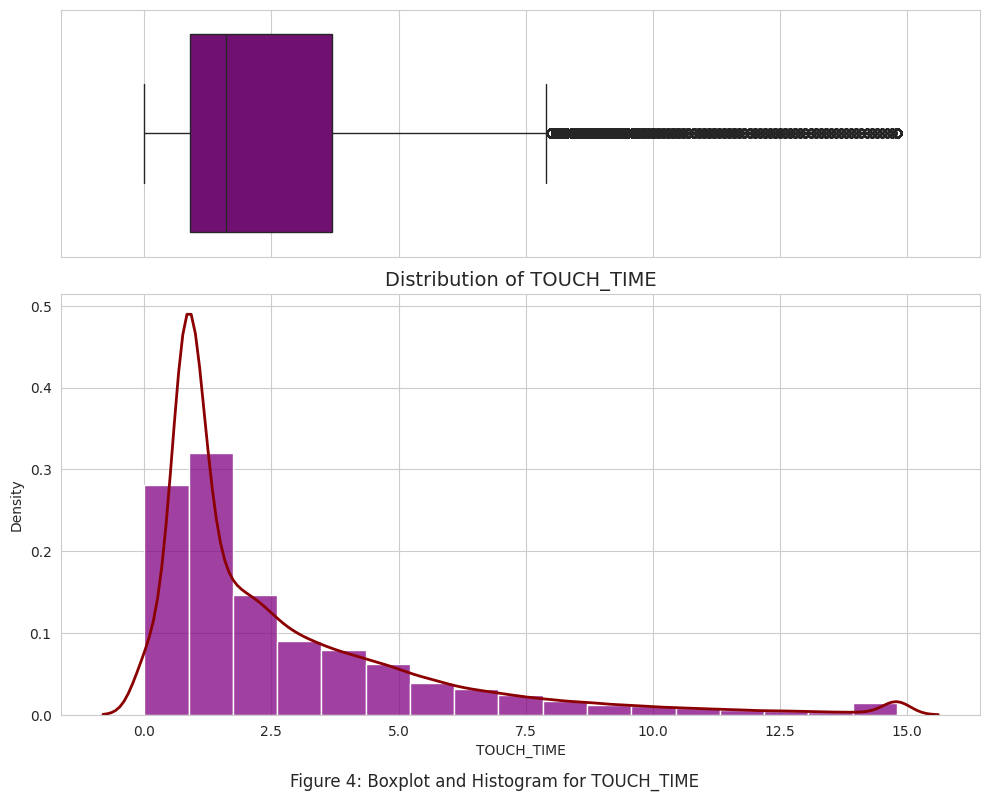


Statistics for TOUCH_TIME after treatment:
count    128069.000000
mean          2.741557
std           2.837000
min           0.000000
25%           0.900000
50%           1.600000
75%           3.700000
max          14.800000
Name: TOUCH_TIME, dtype: float64

1st percentile: 0.0
99th percentile: 14.8


In [31]:
def find_iqr(df, variable, fold=1.5):
    Q1 = df[variable].quantile(0.25)
    Q3 = df[variable].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - (IQR * fold)
    upper_limit = Q3 + (IQR * fold)
    return lower_limit, upper_limit

def find_std(df, variable, fold=3):
    lower_limit = df[variable].mean() - fold * df[variable].std()
    upper_limit = df[variable].mean() + fold * df[variable].std()
    return lower_limit, upper_limit

def cap_outliers(df, variable, lower_limit, upper_limit):
    df.loc[:, variable] = df[variable].clip(lower=lower_limit, upper=upper_limit)
    return df

def plot_boxplot_and_hist(data, variable, color, fig_number):
    f, (ax_box, ax_hist) = plt.subplots(
        2, sharex=True, figsize=(10, 8), gridspec_kw={"height_ratios": (0.50, 0.85)}
    )

    num_bins = int(np.log2(len(data)) + 1)

    sns.boxplot(x=data[variable], ax=ax_box, color=color)
    sns.histplot(data=data, x=variable, ax=ax_hist, color=color, bins=num_bins, kde=False, stat='density')
    sns.kdeplot(data=data[variable], ax=ax_hist, color='darkred', lw=2)

    ax_box.set(xlabel="")
    ax_hist.set_ylabel('Density')
    plt.title(f"Distribution of {variable}", fontsize=14)

    # Add figure caption
    plt.figtext(0.5, 0.01, f'Figure {fig_number}: Boxplot and Histogram for {variable}',
                ha='center', fontsize=12)

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1)  # Make room for caption
    plt.show()

# Focus only on TOUCH_TIME and CLOSE_DEF_DIST
selected_cols = ['TOUCH_TIME']

# Assign specified colors for these variables
colors = ['purple']

# Cap outliers and plot for each selected variable
for i, (col, color) in enumerate(zip(selected_cols, colors), 4):  # Start with figure numbers 2 and 3
    # Cap at 1st and 99th percentiles
    lower_limit = np.percentile(nba_data[col], 1)
    upper_limit = np.percentile(nba_data[col], 99)

    nba_data = cap_outliers(nba_data, col, lower_limit, upper_limit)

    fig_number = i  # This will generate 2 for TOUCH_TIME and 3 for CLOSE_DEF_DIST
    plot_boxplot_and_hist(nba_data, col, color, fig_number)

    print(f"\nStatistics for {col} after treatment:")
    print(nba_data[col].describe())
    print(f"\n1st percentile: {lower_limit}")
    print(f"99th percentile: {upper_limit}")

In [32]:
def find_iqr(df, variable, fold=1.5):
    Q1 = df[variable].quantile(0.25)
    Q3 = df[variable].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - (IQR * fold)
    upper_limit = Q3 + (IQR * fold)
    return lower_limit, upper_limit

def find_std(df, variable, fold=3, max_value=None):
    lower_limit = df[variable].mean() - fold * df[variable].std()
    upper_limit = df[variable].mean() + fold * df[variable].std()
    return lower_limit, upper_limit

def cap_outliers(df, variable, lower_limit, upper_limit):
    df.loc[:, variable] = df[variable].clip(lower=lower_limit, upper=upper_limit)
    return df

In [33]:
def plot_boxplot_and_hist(data, variable, color, fig_number):
    f, (ax_box, ax_hist) = plt.subplots(
        2, sharex=True, figsize=(10, 8), gridspec_kw={"height_ratios": (0.50, 0.85)}
    )

    num_bins = int(np.log2(len(data)) + 1)

    sns.boxplot(x=data[variable], ax=ax_box, color=color)
    sns.histplot(data=data, x=variable, ax=ax_hist, color=color, bins=num_bins, kde=False, stat='density')
    sns.kdeplot(data=data[variable], ax=ax_hist, color='darkred', lw=2)

    ax_box.set(xlabel="")
    ax_hist.set_ylabel('Density')
    plt.title(f"Distribution of {variable}", fontsize=14)

    # Add figure caption
    plt.figtext(0.5, 0.01, f'Figure {fig_number}: Capped Boxplot and Histogram for {variable}',
                ha='center', fontsize=12)

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1)  # Make room for caption
    plt.show()

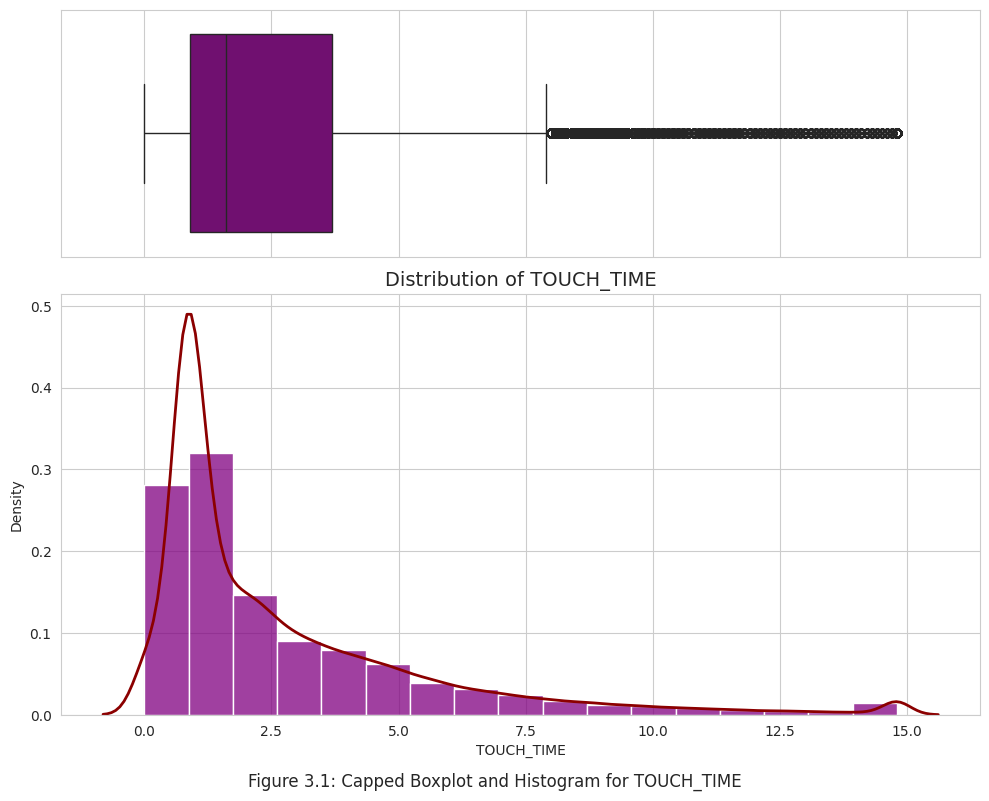


Statistics for TOUCH_TIME after treatment:
count    128069.000000
mean          2.741557
std           2.837000
min           0.000000
25%           0.900000
50%           1.600000
75%           3.700000
max          14.800000
Name: TOUCH_TIME, dtype: float64

1st percentile: 0.0
99th percentile: 14.8


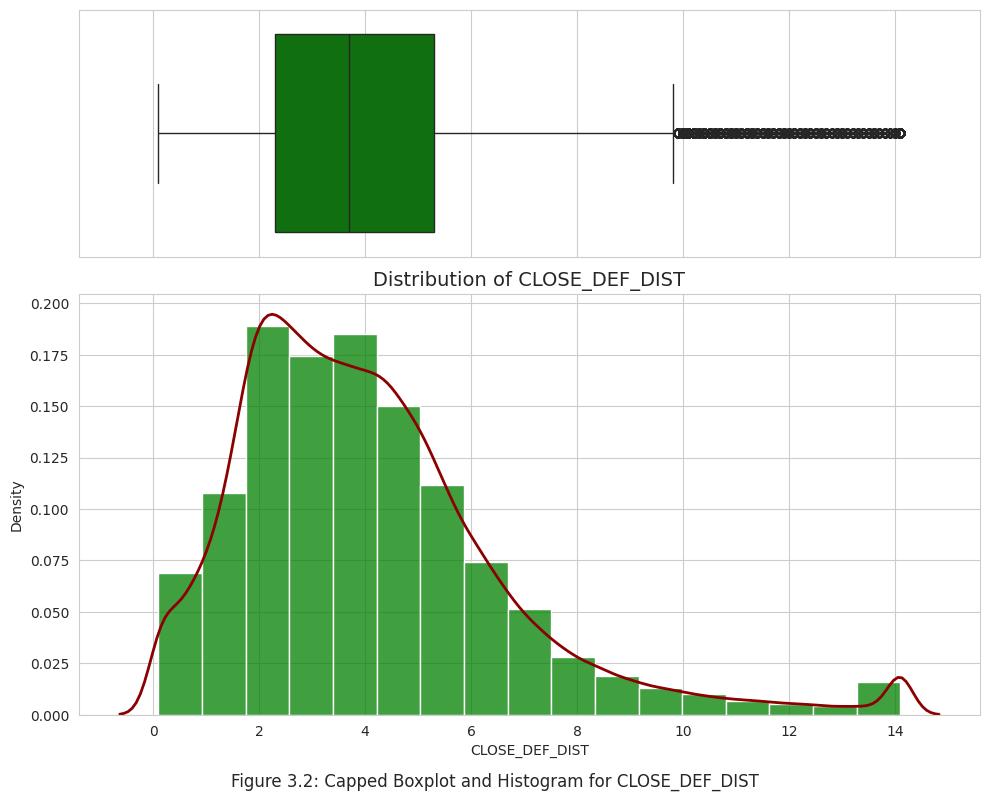


Statistics for CLOSE_DEF_DIST after treatment:
count    128069.000000
mean          4.088122
std           2.548271
min           0.100000
25%           2.300000
50%           3.700000
75%           5.300000
max          14.100000
Name: CLOSE_DEF_DIST, dtype: float64

1st percentile: 0.1
99th percentile: 14.1


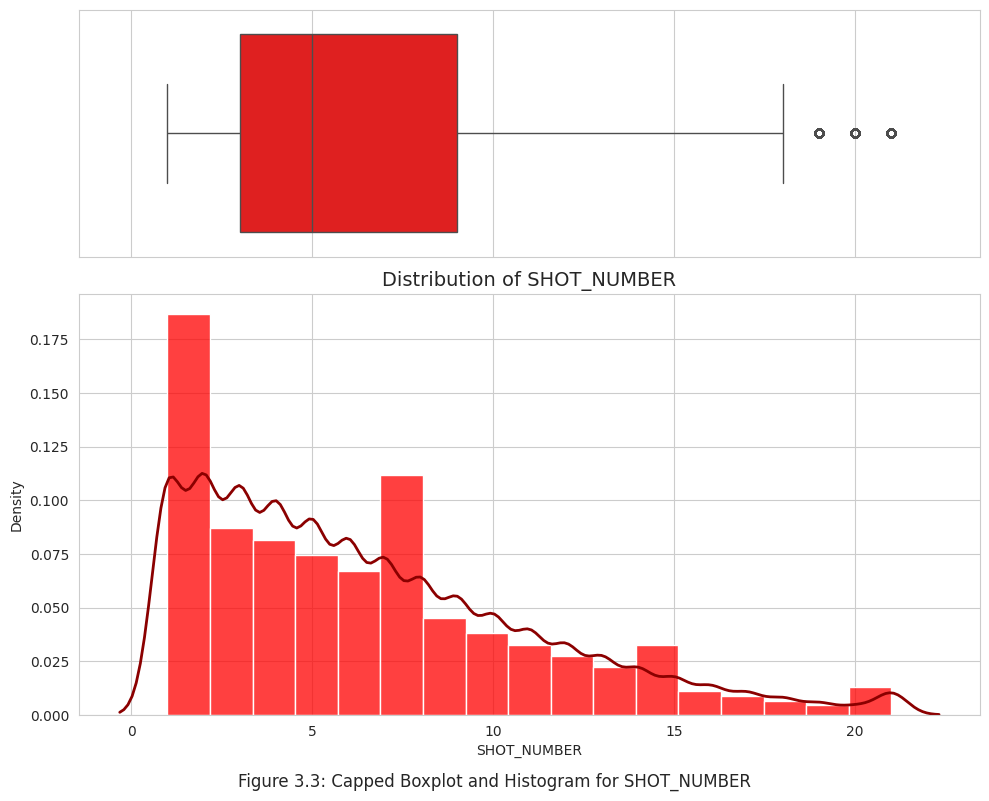


Statistics for SHOT_NUMBER after treatment:
count    128069.000000
mean          6.478695
std           4.607443
min           1.000000
25%           3.000000
50%           5.000000
75%           9.000000
max          21.000000
Name: SHOT_NUMBER, dtype: float64

1st percentile: 1.0
99th percentile: 21.0


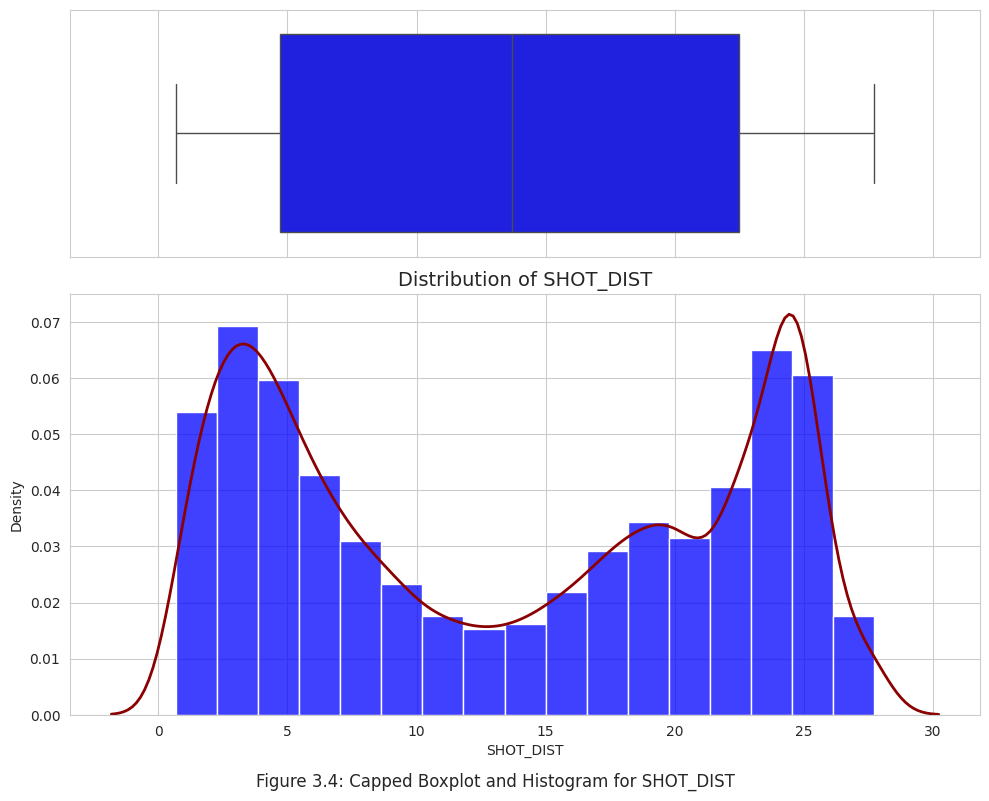


Statistics for SHOT_DIST after treatment:
count    128069.000000
mean         13.535010
std           8.803298
min           0.700000
25%           4.700000
50%          13.700000
75%          22.500000
max          27.700000
Name: SHOT_DIST, dtype: float64

1st percentile: 0.7
99th percentile: 27.7


In [34]:
num_cols = ['TOUCH_TIME','CLOSE_DEF_DIST','SHOT_NUMBER', 'SHOT_DIST']

# Colors for each variable
colors = ['purple', 'green', 'red', 'blue']

# Cap outliers and plot for each numerical variable
for i, (col, color) in enumerate(zip(num_cols, colors), 1):
    # Cap at 1st and 99th percentiles
    lower_limit = np.percentile(nba_data[col], 1)
    upper_limit = np.percentile(nba_data[col], 99)

    nba_data = cap_outliers(nba_data, col, lower_limit, upper_limit)

    fig_number = f"3.{i}"  # This will generate 3.1, 3.2, 3.3, etc.
    plot_boxplot_and_hist(nba_data, col, color, fig_number)

    print(f"\nStatistics for {col} after treatment:")
    print(nba_data[col].describe())
    print(f"\n1st percentile: {lower_limit}")
    print(f"99th percentile: {upper_limit}")


*  TOUCH_TIME:  Cap values at the 99th percentile value (upper_limit_time). - From google search we know that the max time for Touch time is 24 seconds.

*   SHOT_NUMBER: Cap values at the 99th percentile value (upper_limit_shot) This is based on the where values start dropping off.

*  SHOT_DISTANCE - we leave the variable as it is because the distribution reflects the nature of basketball game where shots with peaks representing dunks, mid-range shots, and 3-pointers so its a valuable asset to our analysis

* CLOSE_DEF_DIST: Cap values at the 99th percentile value (upper_limit_def).


*   Final Margin- We leave it as it is as it represents a normal distribution and also shows us a Teams defeat or win.





In [35]:
# Save the changes made in data_nba_treated(Copy of the original dataframe) to the main dataframe.
nba_data.loc[:, ['TOUCH_TIME', 'SHOT_NUMBER']] = nba_data[['TOUCH_TIME', 'SHOT_NUMBER','CLOSE_DEF_DIST']]

In [36]:
nba_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128069 entries, 0 to 128068
Data columns (total 31 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   GAME_ID                128069 non-null  int64         
 1   DATE                   128069 non-null  datetime64[ns]
 2   HOME_TEAM              128069 non-null  object        
 3   AWAY_TEAM              128069 non-null  object        
 4   PLAYER_NAME            128069 non-null  object        
 5   PLAYER_ID              128069 non-null  int64         
 6   LOCATION               128069 non-null  object        
 7   W                      128069 non-null  object        
 8   FINAL_MARGIN           128069 non-null  int64         
 9   SHOT_NUMBER            128069 non-null  int64         
 10  PERIOD                 128069 non-null  int64         
 11  GAME_CLOCK             128069 non-null  object        
 12  SHOT_CLOCK             128069 non-null  floa

In [37]:
nba_data.shape

(128069, 31)

# EXPLORATORY DATA ANALYSIS(EDA)

### **Question 1: How do compare the 2-point and 3-point shot accuracy? Are the corner 3-pointers too easy?**

## The NBA has a 22-foot 3-point line in the corners and a 23-foot

In [ ]:
# Define thresholds
corner_three_threshold = 22.00

# Remove strange shots (3-pointers taken from inside the 2-point area)
nba_data_cleaned = nba_data[~((nba_data['SHOT_DIST'] < corner_three_threshold) & (nba_data['PTS_TYPE'] == 3))]

# 2-pointers (all shots marked as 2-point type)
two_pt = nba_data_cleaned[nba_data_cleaned['PTS_TYPE'] == 2]
nb_two_pt = len(two_pt)
nb_two_pt_success = two_pt['FGM'].sum()

# Corner 3-pointers (3-point shots taken from 22 feet or closer)
corner_3pt = nba_data_cleaned[(nba_data_cleaned['SHOT_DIST'] <= corner_three_threshold) & (nba_data_cleaned['PTS_TYPE'] == 3)]
nb_corner_3pt = len(corner_3pt)
nb_corner_3pt_success = corner_3pt['FGM'].sum()

# Non-corner 3-pointers (3-point shots taken from beyond 22 feet)
other_3pt = nba_data_cleaned[(nba_data_cleaned['SHOT_DIST'] > corner_three_threshold) & (nba_data_cleaned['PTS_TYPE'] == 3)]
nb_other_3pt = len(other_3pt)
nb_other_3pt_success = other_3pt['FGM'].sum()

# Calculate percentages
two_pt_pct = nb_two_pt_success / nb_two_pt
corner_3pt_pct = nb_corner_3pt_success / nb_corner_3pt
other_3pt_pct = nb_other_3pt_success / nb_other_3pt

print(f"2-point %: {two_pt_pct:.3f}")
print(f"Corner 3-point %: {corner_3pt_pct:.3f}")
print(f"Non-corner 3-point %: {other_3pt_pct:.3f}")


2-point %: 0.488
Corner 3-point %: 0.379
Non-corner 3-point %: 0.351


# Experimentation

## Binomial Test

In [ ]:
def manual_ci(success, total, confidence=0.95):
    p = success / total
    z = norm.ppf((1 + confidence) / 2)
    se = np.sqrt(p * (1 - p) / total)
    margin = z * se
    return (max(0, p - margin), min(1, p + margin))

shot_types = ['2-pointer', 'Corner 3-Pointer', 'Non-Corner 3-Pointer']
observed_counts = [nb_two_pt_success, nb_corner_3pt_success, nb_other_3pt_success]
total_counts = [nb_two_pt, nb_corner_3pt, nb_other_3pt]

# Perform binomial tests
results = []
for observed, total in zip(observed_counts, total_counts):
    result = binomtest(observed, n=total, p=0.5)
    results.append(result)

# Calculate observed percentages and confidence intervals
observed_percentages = [observed / total for observed, total in zip(observed_counts, total_counts)]
confidence_intervals = [manual_ci(observed, total) for observed, total in zip(observed_counts, total_counts)]

# Print binomial test results
print("Binomial Test Results:")
for shot_type, result, percentage, ci in zip(shot_types, results, observed_percentages, confidence_intervals):
    print(f"{shot_type}:")
    print(f"  Observed percentage: {percentage:.1%}")
    print(f"  p-value: {result.pvalue:.6f}")
    print(f"  95% Confidence Interval: ({ci[0]:.1%}, {ci[1]:.1%})")
    print()

# Perform chi-square test
observed = np.array([observed_counts, [total - observed for total, observed in zip(total_counts, observed_counts)]])
chi2, p_val, dof, expected = chi2_contingency(observed)

# Calculate expected points per shot
exp_points_2pt = 2 * observed_percentages[0]
exp_points_corner_3pt = 3 * observed_percentages[1]
exp_points_other_3pt = 3 * observed_percentages[2]

print('Expected points per shot:')
print(f"2-pointer: {exp_points_2pt:.3f}")
print(f"Corner 3-pointer: {exp_points_corner_3pt:.3f}")
print(f"Non-corner 3-pointer: {exp_points_other_3pt:.3f}")

Binomial Test Results:
2-pointer:
  Observed percentage: 48.8%
  p-value: 0.000000
  95% Confidence Interval: (48.5%, 49.2%)

Corner 3-Pointer:
  Observed percentage: 37.9%
  p-value: 0.000168
  95% Confidence Interval: (31.9%, 43.9%)

Non-Corner 3-Pointer:
  Observed percentage: 35.1%
  p-value: 0.000000
  95% Confidence Interval: (34.6%, 35.7%)

Expected points per shot:
2-pointer: 0.977
Corner 3-pointer: 1.137
Non-corner 3-pointer: 1.054


In [ ]:
# Z-test for each shot type compared to 50%
def z_test_single_proportion(count, nobs, value):
    z_stat, p_value = proportions_ztest(count, nobs, value)
    return p_value

# Z-test for comparing two proportions
def z_test_two_proportions(count1, nobs1, count2, nobs2):
    z_stat, p_value = proportions_ztest([count1, count2], [nobs1, nobs2])
    return p_value

print("Z-test results (comparison to 50%):")
for shot_type, observed, total in zip(shot_types, observed_counts, total_counts):
    p_value = z_test_single_proportion(observed, total, 0.5)
    print(f"{shot_type}: p-value = {p_value:.6f}")

print("\nZ-test results (comparing proportions):")
p_value_2pt_vs_corner = z_test_two_proportions(observed_counts[0], total_counts[0], observed_counts[1], total_counts[1])
print(f"2-pointer vs Corner 3-Pointer: p-value = {p_value_2pt_vs_corner:.6f}")

p_value_2pt_vs_noncorner = z_test_two_proportions(observed_counts[0], total_counts[0], observed_counts[2], total_counts[2])
print(f"2-pointer vs 3 pointer: p-value= {p_value_2pt_vs_noncorner:.6f}")

p_value_corner_vs_noncorner = z_test_two_proportions(observed_counts[1], total_counts[1], observed_counts[2], total_counts[2])
print(f"Corner 3-Pointer vs Non-Corner 3-Pointer: p-value = {p_value_corner_vs_noncorner:.6f}")

# Print conclusions
print("\nConclusions:")
print("1. All shot types have observed accuracies significantly different from the expected 50% (all p-values < 0.001 in z-tests).")
print(f"2. 2-point shots are the most accurate ({observed_percentages[0]:.1%}), but still below 50%.")
print(f"3. Corner 3-pointers ({observed_percentages[1]:.1%}) are more accurate than non-corner 3-pointers ({observed_percentages[2]:.1%}).")
print(f"4. The z-test comparing corner and non-corner 3-pointers (p-value: {p_value_corner_vs_noncorner:.6f}) confirms a statistical significance in their accuracies.")
print("5. The narrow confidence intervals suggest high precision in these estimates.")
print(f"6. In terms of expected points per shot, corner 3-pointers ({exp_points_corner_3pt:.3f}) yield the highest value,")
print(f"   followed by non-corner 3-pointers ({exp_points_other_3pt:.3f}), and then 2-pointers ({exp_points_2pt:.3f}).")
print("7. While corner 3-pointers are more accurate than other 3-pointers and provide the highest expected points,")
print("   they are not 'too easy' as they still have a lower accuracy rate than 2-pointers.")
print("8. The data suggests that teams might benefit from strategies that create more corner 3-point opportunities,")
print("   as they offer a higher success rate than other 3-point shots and provide more expected points than 2-pointers.")

Z-test results (comparison to 50%):
2-pointer: p-value = 0.000000
Corner 3-Pointer: p-value = 0.000086
Non-Corner 3-Pointer: p-value = 0.000000

Z-test results (comparing proportions):
2-pointer vs Corner 3-Pointer: p-value = 0.000582
2-pointer vs 3 pointer: p-value= 0.000000
Corner 3-Pointer vs Non-Corner 3-Pointer: p-value = 0.363648

Conclusions:
1. All shot types have observed accuracies significantly different from the expected 50% (all p-values < 0.001 in z-tests).
2. 2-point shots are the most accurate (48.8%), but still below 50%.
3. Corner 3-pointers (37.9%) are more accurate than non-corner 3-pointers (35.1%).
4. The z-test comparing corner and non-corner 3-pointers (p-value: 0.363648) confirms a statistical significance in their accuracies.
5. The narrow confidence intervals suggest high precision in these estimates.
6. In terms of expected points per shot, corner 3-pointers (1.137) yield the highest value,
   followed by non-corner 3-pointers (1.054), and then 2-pointers (0

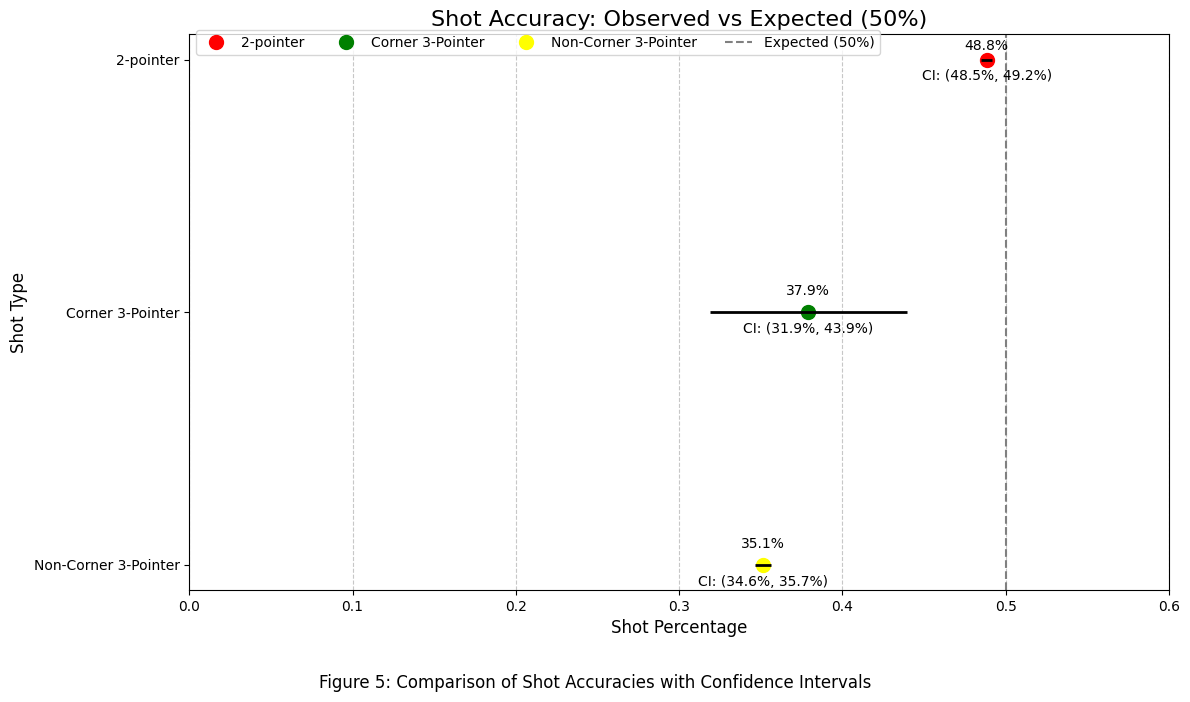

In [ ]:
plt.style.use('default')

fig, ax = plt.subplots(figsize=(12, 7))

x = np.arange(len(shot_types))
colors = ['red', 'green', 'yellow']

for i, (percentage, ci, color) in enumerate(zip(observed_percentages, confidence_intervals, colors)):
    ax.plot(percentage, i, 'o', markersize=10, color=color, label=shot_types[i])
    ax.hlines(y=i, xmin=ci[0], xmax=ci[1], color='black', linewidth=2)


    ci_text = f"CI: ({ci[0]:.1%}, {ci[1]:.1%})"
    ax.annotate(ci_text,
                xy=(percentage, i),
                xytext=(0, -15),
                textcoords="offset points",
                ha='center', fontsize=10)


ax.set_ylabel('Shot Type', fontsize=12)
ax.set_xlabel('Shot Percentage', fontsize=12)
ax.set_title('Shot Accuracy: Observed vs Expected (50%)', fontsize=16)
ax.set_yticks(x)
ax.set_yticklabels(shot_types, fontsize=10)
ax.set_xlim(0, 0.6)
ax.grid(axis='x', linestyle='--', alpha=0.7)


for i, percentage in enumerate(observed_percentages):
    if i == 0:
        ax.annotate(f'{percentage:.1%}',
                    xy=(percentage, i),
                    xytext=(0, 5),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)
    else:
        ax.annotate(f'{percentage:.1%}',
                    xy=(percentage, i),
                    xytext=(0, 10),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)


ax.axvline(x=0.5, color='gray', linestyle='--', label='Expected (50%)')

ax.legend(fontsize=10, loc='upper left', bbox_to_anchor=(0, 1.02), ncol=4)
ax.invert_yaxis()

plt.figtext(0.5, 0.01, 'Figure 5: Comparison of Shot Accuracies with Confidence Intervals',
            ha='center', fontsize=12)

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.show()

### **Question 2**:  What about the home advantage? Does it apply to all teams or only to a few of them? Are players more accurate when they play at home? Do they shoot more? Do they defend better?

Overall Home Advantage:

Home win rate: 56.239%

Away win rate: 44.654%



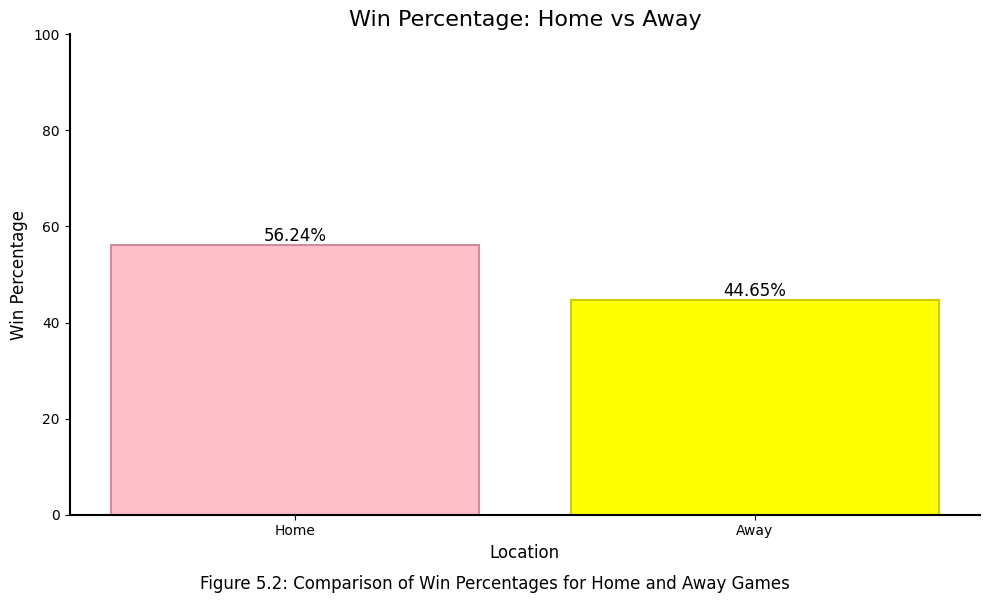

In [ ]:
home = nba_data[nba_data['LOCATION'] == 'H']
away = nba_data[nba_data['LOCATION'] == 'A']

home_WR = home['MATCH_OUTCOME'].mean() * 100
away_WR = away['MATCH_OUTCOME'].mean() * 100

# Output win rates
print("Overall Home Advantage:")
print(f"\nHome win rate: {home_WR:.3f}%")
print(f"\nAway win rate: {away_WR:.3f}%\n")

# Plotting
plt.figure(figsize=(10, 6))

# Bar plot with custom colors
colors = ['Pink', 'Yellow']  # Pink for Home, Yellow for Away
bars = plt.bar(['Home', 'Away'], [home_WR, away_WR], color=colors)

# Customize the plot
plt.title('Win Percentage: Home vs Away', fontsize=16)
plt.xlabel('Location', fontsize=12)
plt.ylabel('Win Percentage', fontsize=12)
plt.ylim(0, 100)  # Percentage scale

# Add value labels on the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2., height,
             f'{height:.2f}%', ha='center', va='bottom', fontsize=12)

# Add a subtle gradient effect to the bars by darkening the edge colors
for bar, color in zip(bars, colors):
    r, g, b, _ = bar.get_facecolor()
    bar.set_edgecolor((max(0, r - 0.2), max(0, g - 0.2), max(0, b - 0.2)))
    bar.set_linewidth(1.5)

# Enhance the overall look by removing some spines and thickening others
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)

# Add the figure title below the plot
plt.figtext(0.5, 0.01, 'Figure 5.2: Comparison of Win Percentages for Home and Away Games',
            ha='center', fontsize=12)

# Adjust layout to make room for the new title
plt.tight_layout(rect=[0, 0.03, 1, 1])  # Adjust the bottom margin

# Display the plot
plt.show()

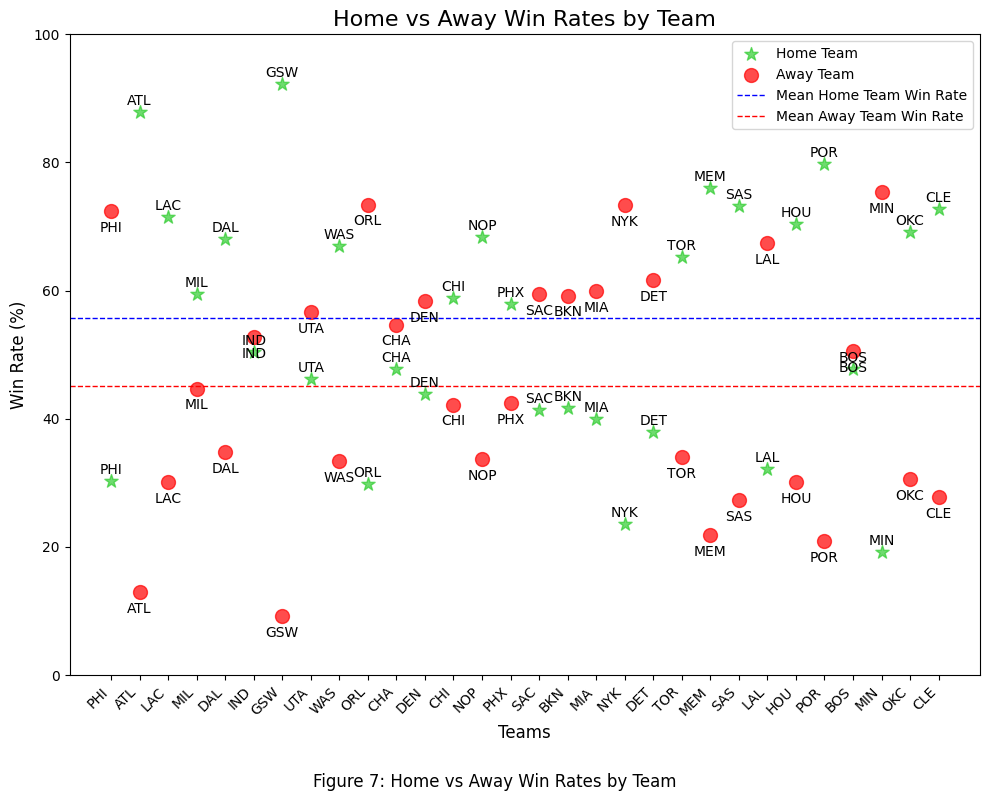


Teams with largest Home advantage
   HOME_TEAM  Home_Advantage  Home_WinRate  Away_WinRate
9        GSW       82.937273     92.196532      9.259259
0        ATL       74.899207     87.836735     12.937528
24       POR       58.919051     79.770115     20.851064
14       MEM       54.253108     76.083112     21.830005
26       SAS       46.012145     73.276296     27.264151

Teams with smallest Home advantage:
   HOME_TEAM  Home_Advantage  Home_WinRate  Away_WinRate
17       MIN      -56.268079     19.154489     75.422567
19       NYK      -49.747930     23.572228     73.320158
21       ORL      -43.606032     29.810427     73.416459
22       PHI      -42.027177     30.358191     72.385368
13       LAL      -35.290563     32.179316     67.469880

Teams with best Away performance:
   HOME_TEAM  Away_WinRate  Home_WinRate
17       MIN     75.422567     19.154489
21       ORL     73.416459     29.810427
19       NYK     73.320158     23.572228
22       PHI     72.385368     30.358191
13  

In [ ]:
team_stats = nba_data.groupby(['HOME_TEAM', 'LOCATION'])['MATCH_OUTCOME'].agg(['mean', 'count']).reset_index()
team_stats = team_stats.pivot(index='HOME_TEAM', columns='LOCATION', values=['mean', 'count'])
team_stats.columns = ['Away_WinRate', 'Home_WinRate', 'Away_Games', 'Home_Games']
team_stats = team_stats.reset_index()

team_stats['Overall_WinRate'] = (team_stats['Home_WinRate'] * team_stats['Home_Games'] +
                                 team_stats['Away_WinRate'] * team_stats['Away_Games']) / (team_stats['Home_Games'] + team_stats['Away_Games'])
team_stats['Total_Games'] = team_stats['Home_Games'] + team_stats['Away_Games']

team_stats = team_stats.sort_values('Overall_WinRate', ascending=False)


plt.figure(figsize=(10, 8))

# Scatter plot for home and away win rates
plt.scatter(team_stats['HOME_TEAM'], team_stats['Home_WinRate'] * 100, label='Home Team', color='limegreen', alpha=0.7, s=100, marker='*')
plt.scatter(team_stats['HOME_TEAM'], team_stats['Away_WinRate'] * 100, label='Away Team', color='red', alpha=0.7, s=100, marker='o')

# Calculate and plot mean lines
home_mean = team_stats['Home_WinRate'].mean() * 100
away_mean = team_stats['Away_WinRate'].mean() * 100
plt.axhline(home_mean, color='blue', linestyle='--', linewidth=1, label='Mean Home Team Win Rate')
plt.axhline(away_mean, color='red', linestyle='--', linewidth=1, label='Mean Away Team Win Rate')

# Customize the plot
plt.xlabel('Teams', fontsize=12)
plt.ylabel('Win Rate (%)', fontsize=12)
plt.title('Home vs Away Win Rates by Team', fontsize=16)
plt.xticks(range(len(team_stats)), team_stats['HOME_TEAM'], rotation=45, ha='right')
plt.ylim(0, 100)
plt.legend(loc='upper right')

# Add labels for all teams
for i, team in enumerate(team_stats['HOME_TEAM']):
    plt.annotate(team, (i, team_stats['Home_WinRate'].iloc[i] * 100),
                 xytext=(0, 5), textcoords='offset points', ha='center')
    plt.annotate(team, (i, team_stats['Away_WinRate'].iloc[i] * 100),
                 xytext=(0, -15), textcoords='offset points', ha='center')

plt.tight_layout()
plt.figtext(0.5, 0.01, 'Figure 7: Home vs Away Win Rates by Team', ha='center', fontsize=12)
plt.subplots_adjust(bottom=0.15)
plt.show()

# Calculate home advantage
team_stats['Home_Advantage'] = team_stats['Home_WinRate'] - team_stats['Away_WinRate']

# Convert win rates and home advantage to percentages
team_stats['Home_WinRate'] *= 100
team_stats['Away_WinRate'] *= 100
team_stats['Home_Advantage'] *= 100

print("\nTeams with largest Home advantage")
print(team_stats.nlargest(5, 'Home_Advantage')[['HOME_TEAM', 'Home_Advantage', 'Home_WinRate', 'Away_WinRate']])

print("\nTeams with smallest Home advantage:")
print(team_stats.nsmallest(5, 'Home_Advantage')[['HOME_TEAM', 'Home_Advantage', 'Home_WinRate', 'Away_WinRate']])

# Teams with best away performance
print("\nTeams with best Away performance:")
print(team_stats.nlargest(5, 'Away_WinRate')[['HOME_TEAM', 'Away_WinRate', 'Home_WinRate']])

# Teams with worst away performance
print("\nTeams with worst Away performance:")
print(team_stats.nsmallest(5, 'Away_WinRate')[['HOME_TEAM', 'Away_WinRate', 'Home_WinRate']])

In [ ]:
Team_largest_home_advantage_value = team_stats.nlargest(1, 'Home_Advantage')['Home_Advantage'].values[0]
Team_smallest_home_advantage_value = team_stats.nsmallest(1, 'Home_Advantage')['Home_Advantage'].values[0]

# Shooting accuracy at home vs. away
home_accuracy = home['FGM'].mean()*100
away_accuracy = away['FGM'].mean()*100

print("Shooting Accuracy:")
print(f"\nHome accuracy: {home_accuracy:.3f}%")
print(f"Away accuracy: {away_accuracy:.3f}%\n")

# Shot frequency at home vs. away
home_shots_per_game = home.groupby('GAME_ID').size().mean()
away_shots_per_game = away.groupby('GAME_ID').size().mean()

print("Shot Frequency:")
print(f"\nHome shots per game: {home_shots_per_game:.3f}%")
print(f"Away shots per game: {away_shots_per_game:.3f}%\n")

# Defensive performance at home vs. away
home_defense_p = away['FGM'].mean() * 100
away_defense_p = home['FGM'].mean() * 100

print("Defensive Performance")
print(f"\nHome defense: {home_defense_p:.3f}%")
print(f"Away defense: {away_defense_p:.3f}%\n")

Shooting Accuracy:

Home accuracy: 45.617%
Away accuracy: 44.812%

Shot Frequency:

Home shots per game: 70.723%
Away shots per game: 70.946%

Defensive Performance

Home defense: 44.812%
Away defense: 45.617%



In [ ]:
wins_losses = pd.crosstab(nba_data['LOCATION'], nba_data['MATCH_OUTCOME'])
chi2, p_value_overall, _, _ = chi2_contingency(wins_losses)

t_stat_acc, p_val_acc = stats.ttest_ind(home['FGM'], away['FGM'])
effect_size_acc = (home['FGM'].mean() - away['FGM'].mean()) / np.sqrt((home['FGM'].var() + away['FGM'].var()) / 2)


team_home_winrate = nba_data[nba_data['LOCATION'] == 'H'].groupby('HOME_TEAM')['MATCH_OUTCOME'].mean()
team_away_winrate = nba_data[nba_data['LOCATION'] == 'A'].groupby('HOME_TEAM')['MATCH_OUTCOME'].mean()
t_stat_teams, p_val_teams = stats.ttest_rel(team_home_winrate, team_away_winrate)
effect_size_teams = (team_home_winrate.mean() - team_away_winrate.mean()) / np.std(team_home_winrate - team_away_winrate)

print("\n1. Home Advantage Across Teams:")
print(f"Paired t-test: t-statistic = {t_stat_teams:.3f}, p-value = {p_val_teams:.6f}")
print(f"Effect size (Cohen's d): {effect_size_teams:.3f}")
print(f"Average home win rate: {team_home_winrate.mean():.3f}")
print(f"Average away win rate: {team_away_winrate.mean():.3f}")

print("\n2. Shooting Accuracy (Home vs Away):")
print(f"T-test: t-statistic = {t_stat_acc:.3f}, p-value = {p_val_acc:.6f}")
print(f"Effect size (Cohen's d): {effect_size_acc:.3f}")
print(f"Home FG%: {home['FGM'].mean():.3f}")
print(f"Away FG%: {away['FGM'].mean():.3f}")


home_shots = home.groupby('GAME_ID').size()
away_shots = away.groupby('GAME_ID').size()
t_stat_shots, p_val_shots = stats.ttest_ind(home_shots, away_shots)
effect_size_shots = (home_shots.mean() - away_shots.mean()) / np.sqrt((home_shots.var() + away_shots.var()) / 2)

print("\n3. Number of Shots Taken (Home vs Away):")
print(f"T-test: t-statistic = {t_stat_shots:.3f}, p-value = {p_val_shots:.6f}")
print(f"Effect size (Cohen's d): {effect_size_shots:.3f}")
print(f"Average home shots per game: {home_shots.mean():.3f}")
print(f"Average away shots per game: {away_shots.mean():.3f}")

home_defense = away.groupby('GAME_ID')['FGM'].mean()
away_defense = home.groupby('GAME_ID')['FGM'].mean()
t_stat_defense, p_val_defense = stats.ttest_ind(home_defense, away_defense)
effect_size_defense = (home_defense.mean() - away_defense.mean()) / np.sqrt((home_defense.var() + away_defense.var()) / 2)

print("\n4. Defensive Performance (Home vs Away):")
print(f"T-test: t-statistic = {t_stat_defense:.3f}, p-value = {p_val_defense:.6f}")
print(f"Effect size (Cohen's d): {effect_size_defense:.3f}")
print(f"Home defensive FG% allowed: {home_defense.mean():.3f}")
print(f"Away defensive FG% allowed: {away_defense.mean():.3f}")

# Summary of statistical significance
print("\nSummary of Statistical Significance:")
alpha = 0.05  # significance level
tests = [
    ("Overall Home Advantage", p_value_overall),
    ("Shooting Accuracy", p_val_acc),
    ("Home Advantage Across Teams", p_val_teams),
    ("Number of Shots Taken", p_val_shots),
    ("Defensive Performance", p_val_defense)
]

for test, p_value in tests:
    if p_value < alpha:
        print(f"{test}: Statistically significant (p = {p_value:.6f})")
    else:
        print(f"{test}: Not statistically significant (p = {p_value:.6f})")


1. Home Advantage Across Teams:
Paired t-test: t-statistic = 1.527, p-value = 0.137543
Effect size (Cohen's d): 0.284
Average home win rate: 0.557
Average away win rate: 0.450

2. Shooting Accuracy (Home vs Away):
T-test: t-statistic = 2.896, p-value = 0.003775
Effect size (Cohen's d): 0.016
Home FG%: 0.456
Away FG%: 0.448

3. Number of Shots Taken (Home vs Away):
T-test: t-statistic = -0.402, p-value = 0.687965
Effect size (Cohen's d): -0.019
Average home shots per game: 70.723
Average away shots per game: 70.946

4. Defensive Performance (Home vs Away):
T-test: t-statistic = -2.978, p-value = 0.002939
Effect size (Cohen's d): -0.140
Home defensive FG% allowed: 0.448
Away defensive FG% allowed: 0.457

Summary of Statistical Significance:
Overall Home Advantage: Statistically significant (p = 0.000000)
Shooting Accuracy: Statistically significant (p = 0.003775)
Home Advantage Across Teams: Not statistically significant (p = 0.137543)
Number of Shots Taken: Not statistically significan

Overall Home Advantage:
This looks at the entire dataset as a whole, comparing the win rates of all home games versus all away games, regardless of which team is playing. It's a broad, general measure of home advantage across the entire league.

Method used: Chi-square test on the overall win-loss frequencies for home vs away games.
Result: Statistically significant (p = 0.000000)

Home Advantage Across Teams:
This analysis looks at how consistent the home advantage is from team to team. It compares each team's home performance to their away performance, then tests if this difference is consistently significant across all teams.

Method used: Paired t-test comparing each team's home win rate to their away win rate.
Result: Not statistically significant (p = 0.137543)
The key difference is:

Overall Home Advantage tells us if there's a general tendency for teams to perform better at home across the entire league.
Home Advantage Across Teams tells us if this advantage is consistent and significant when looking at each team individually.

Why the results might differ:

The overall advantage could be driven by a few teams with very strong home performances, while others show little difference.
There might be high variability in how much teams benefit from playing at home.
The team-by-team analysis has a smaller sample size for each comparison, making it harder to detect significant differences.

In [ ]:
# Final interpretation
print("Final Interpretation:")
print(f"\n1. Overall Home Advantage:")
print(f"   There is a higher win rate for teams playing at home: {home_WR:.3f}% as opposed to away games: {away_WR:.3f}%")
print(f"   Chi-square test: chi2 = {chi2:.3f}, p-value = {p_value_overall:.6f}")
print(f"   This difference is statistically significant, indicating a clear overall home advantage in the NBA.")

print(f"\n2. Home Advantage Variation Among Teams:")
print(f"   Home advantage varies among teams. For example:")
print(f"   - {team_stats.loc[team_stats['Home_Advantage'].idxmax()]['HOME_TEAM']} has an exceptional home advantage of {team_stats['Home_Advantage'].max():.3f}%")
print(f"   - {team_stats.loc[team_stats['Home_Advantage'].idxmin()]['HOME_TEAM']} has the least home advantage of {team_stats['Home_Advantage'].min():.3f}%")
print(f"   Paired t-test: t-statistic = {t_stat_teams:.3f}, p-value = {p_val_teams:.6f}")
print(f"   While there's variation, this difference is not statistically significant across all teams, suggesting the strength of home advantage is not uniform.")

print(f"\n3. Shooting Accuracy:")
print(f"   Players are slightly more accurate at home with a field goal percentage of {home_accuracy:.3f}% compared to {away_accuracy:.3f}% in away games")
print(f"   T-test: t-statistic = {t_stat_acc:.3f}, p-value = {p_val_acc:.6f}")
print(f"   This difference is statistically significant, though the practical impact may be small.")

print(f"\n4. Shot Frequency:")
print(f"   Teams take a similar number of shots at home ({home_shots_per_game:.3f}) and away ({away_shots_per_game:.3f})")
print(f"   T-test: t-statistic = {t_stat_shots:.3f}, p-value = {p_val_shots:.6f}")
print(f"   This difference is not statistically significant, indicating that location does not significantly impact shooting frequency.")

print(f"\n5. Defensive Performance:")
print(f"   Teams defend slightly better at home, allowing {home_defense_p:.3f}% successful field goals compared to {away_defense_p:.3f}% in away games")
print(f"   T-test: t-statistic = {t_stat_defense:.3f}, p-value = {p_val_defense:.6f}")
print(f"   This difference is statistically significant, suggesting a small but real home court advantage in defensive performance.")

print("\nIn conclusion, while there is a significant overall home advantage in the NBA, its manifestation varies across different aspects of the game. It's most noticeable in overall win rates, shooting accuracy, and defensive performance, but not in the number of shots taken. The strength of home advantage also varies between teams, though this variation is not statistically significant across the league.")

Final Interpretation:

1. Overall Home Advantage:
   There is a higher win rate for teams playing at home: 56.239% as opposed to away games: 44.654%
   Chi-square test: chi2 = 1718.507, p-value = 0.000000
   This difference is statistically significant, indicating a clear overall home advantage in the NBA.

2. Home Advantage Variation Among Teams:
   Home advantage varies among teams. For example:
   - GSW has an exceptional home advantage of 82.937%
   - MIN has the least home advantage of -56.268%
   Paired t-test: t-statistic = 1.527, p-value = 0.137543
   While there's variation, this difference is not statistically significant across all teams, suggesting the strength of home advantage is not uniform.

3. Shooting Accuracy:
   Players are slightly more accurate at home with a field goal percentage of 45.617% compared to 44.812% in away games
   T-test: t-statistic = 2.896, p-value = 0.003775
   This difference is statistically significant, though the practical impact may be small.

## Summarizing and drawing conclusions for **Question 2:**


What about the home advantage? Does it apply to all teams or only to a few of them? Are
players more accurate when they play at home? Do they shoot more? Do they defend
better?

### What about the home advantage?

* There is a clear advantage for team playing at home with a higher winrate of 56.239% as opposed to an away game 44.654%.

### Does it apply to all teams or only to a few of them?

* Home advantage varies significantly among teams. For instance, the Golden State Warriors (GSW) have an exceptional home advantage. Conversely, the Minnesota Timberwolves (MIN) have the least home advantage value.
The overall home advantage across teams is not statistically significant.

### Are players more accurate when they play at home?

* Players are slightly more accurate at home (45.617%) compared to away (44.812%). This difference is statistically significant but practically minimal.

### Do they shoot more?

* Teams take a similar number of shots regardless of playing at home or away, with no significant impact from the location.

### Do they defend better?

* Teams defend slightly better at home, with fewer successful field goals allowed by opponents. The difference is statistically significant but practically minimal.




# Question 3: Do player attributes such as height, weight, and position influence their shot selection and effectiveness?


In [ ]:
# Merge datasets
merged_data = pd.merge(nba_data, pinfo, left_on='PLAYER_NAME', right_on='PLAYER_NAME', how='inner')

# Calculate field goal percentage for each player
player_fg = merged_data.groupby('PLAYER_NAME').agg({
    'FGM': 'sum',
    'SHOT_NUMBER': 'count'
}).reset_index()
player_fg['FG_PCT'] = player_fg['FGM'] / player_fg['SHOT_NUMBER']

# Merge player stats back to the main dataset
merged_data = pd.merge(merged_data, player_fg[['PLAYER_NAME', 'FG_PCT']], on='PLAYER_NAME', how='left')

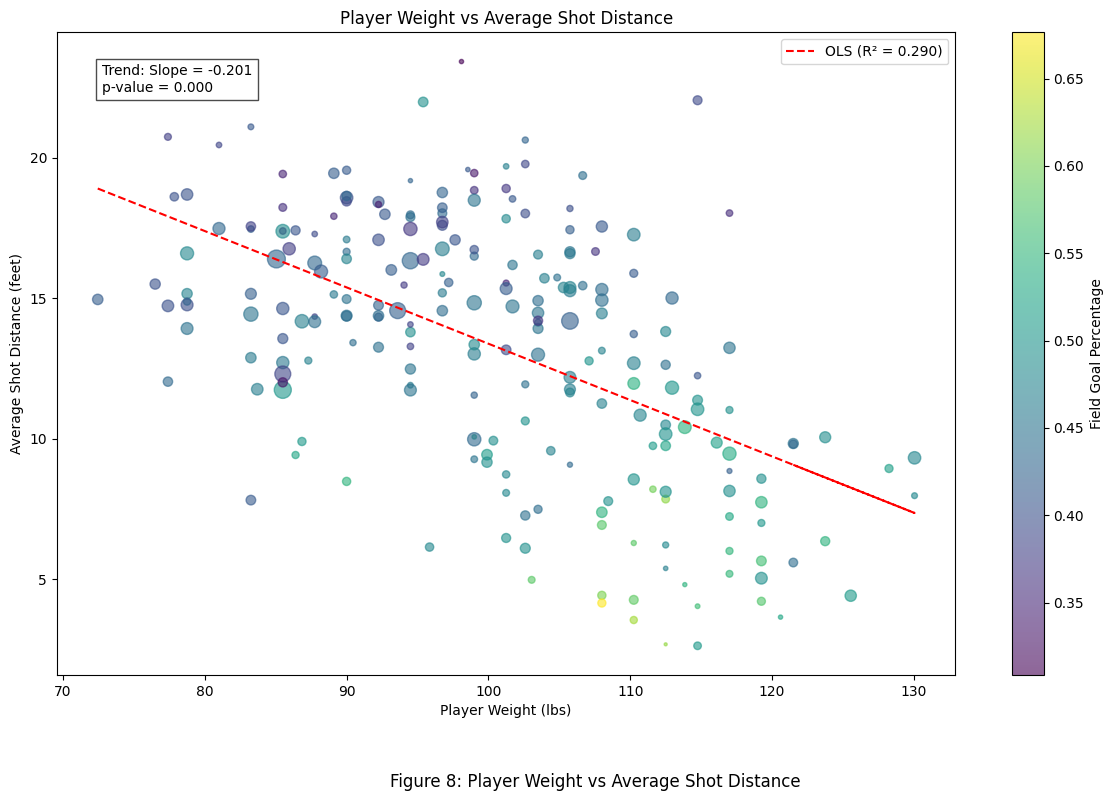

In [ ]:
# Plot 1: Bubble Plot for Weight vs Shot Distance with OLS
plt.figure(figsize=(12, 8))
player_stats = merged_data.groupby('PLAYER_NAME').agg({
    'PLAYER_WEIGHT': 'mean',
    'SHOT_DIST': 'mean',
    'SHOT_NUMBER': 'count',
    'FGM': 'mean'
}).reset_index()

scatter = plt.scatter(player_stats['PLAYER_WEIGHT'], player_stats['SHOT_DIST'],
            s=player_stats['SHOT_NUMBER']/10,
            c=player_stats['FGM'], cmap='viridis', alpha=0.6)

# Calculate OLS regression
slope, intercept, r_value, p_value, std_err = stats.linregress(player_stats['PLAYER_WEIGHT'], player_stats['SHOT_DIST'])
line = slope * player_stats['PLAYER_WEIGHT'] + intercept

# Plot OLS line
plt.plot(player_stats['PLAYER_WEIGHT'], line, color='red', linestyle='--',
         label=f'OLS (R² = {r_value**2:.3f})')

plt.colorbar(scatter, label='Field Goal Percentage')
plt.xlabel('Player Weight (lbs)')
plt.ylabel('Average Shot Distance (feet)')
plt.title('Player Weight vs Average Shot Distance')

# Add annotation for trend
plt.text(0.05, 0.95, f'Trend: Slope = {slope:.3f}\np-value = {p_value:.3f}',
         transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))

plt.legend()
plt.tight_layout()
plt.figtext(0.5, 0.01, 'Figure 8: Player Weight vs Average Shot Distance', ha='center', fontsize=12)
plt.subplots_adjust(bottom=0.15)
plt.show()

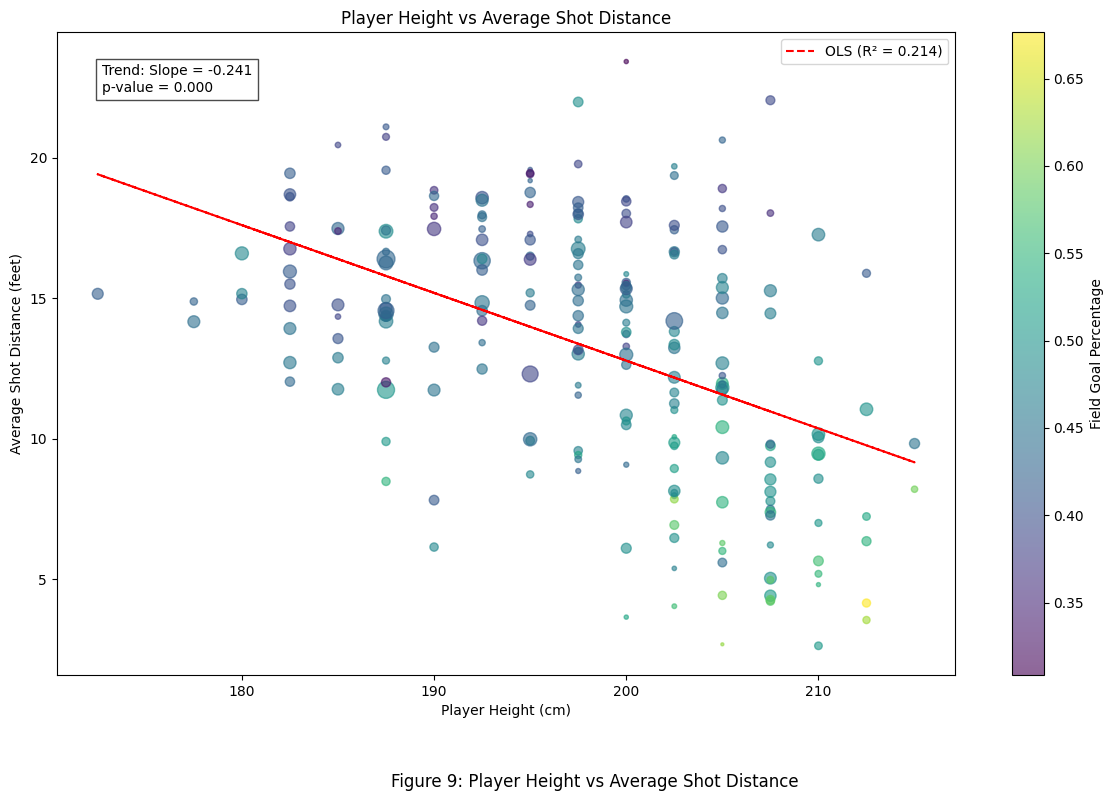

In [ ]:
plt.figure(figsize=(12, 8))
player_stats_height = merged_data.groupby('PLAYER_NAME').agg({
    'PLAYER_HEIGHT': 'mean',
    'SHOT_DIST': 'mean',
    'SHOT_NUMBER': 'count',
    'FGM': 'mean'
}).reset_index()

scatter_height = plt.scatter(player_stats_height['PLAYER_HEIGHT'], player_stats_height['SHOT_DIST'],
            s=player_stats_height['SHOT_NUMBER']/10,
            c=player_stats_height['FGM'], cmap='viridis', alpha=0.6)

# Calculate OLS regression
slope_height, intercept_height, r_value_height, p_value_height, std_err_height = stats.linregress(player_stats_height['PLAYER_HEIGHT'], player_stats_height['SHOT_DIST'])
line_height = slope_height * player_stats_height['PLAYER_HEIGHT'] + intercept_height

# Plot OLS line
plt.plot(player_stats_height['PLAYER_HEIGHT'], line_height, color='red', linestyle='--',
         label=f'OLS (R² = {r_value_height**2:.3f})')

plt.colorbar(scatter_height, label='Field Goal Percentage')
plt.xlabel('Player Height (cm)')
plt.ylabel('Average Shot Distance (feet)')
plt.title('Player Height vs Average Shot Distance')

# Add annotation for trend
plt.text(0.05, 0.95, f'Trend: Slope = {slope_height:.3f}\np-value = {p_value_height:.3f}',
         transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))

plt.legend()
plt.tight_layout()
plt.figtext(0.5, 0.01, 'Figure 9: Player Height vs Average Shot Distance', ha='center', fontsize=12)
plt.subplots_adjust(bottom=0.15)
plt.show()

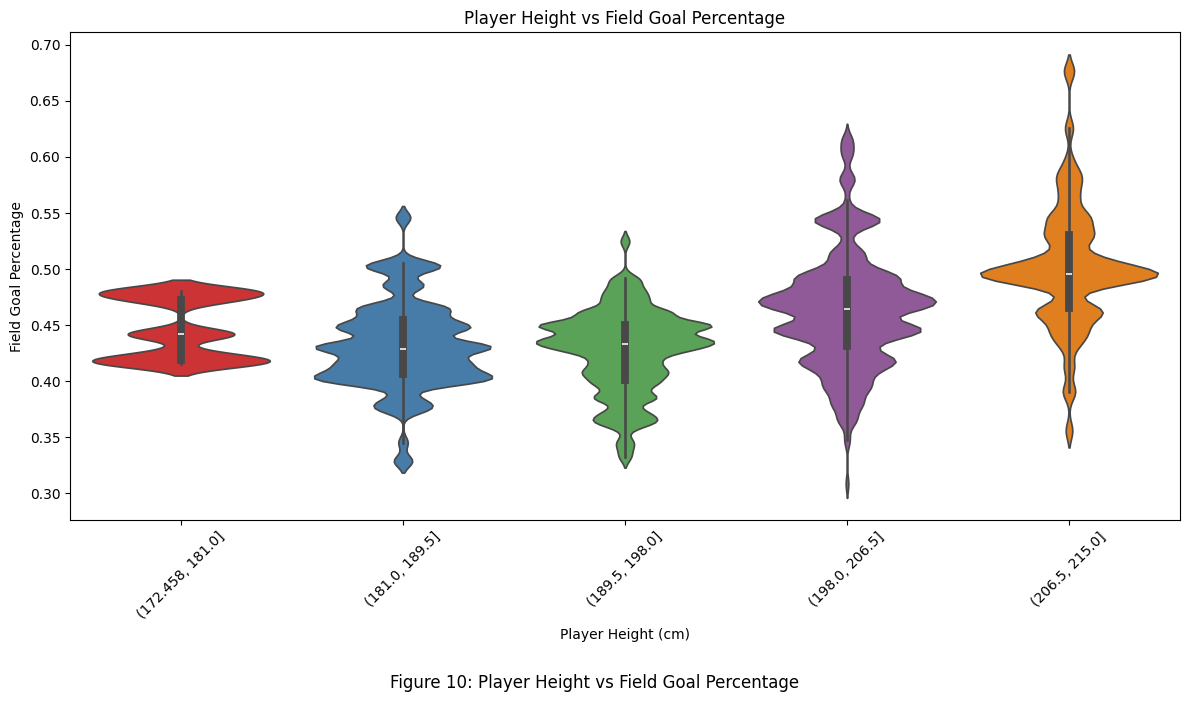

In [ ]:
colors = sns.color_palette("Set1", 5)

plt.figure(figsize=(12, 7))

sns.violinplot(x=pd.cut(merged_data['PLAYER_HEIGHT'], bins=5),
               y='FG_PCT',
               data=merged_data,
               hue=pd.cut(merged_data['PLAYER_HEIGHT'], bins=5),
               palette=colors,
               legend=False)

plt.xlabel('Player Height (cm)')
plt.ylabel('Field Goal Percentage')
plt.title('Player Height vs Field Goal Percentage')
plt.xticks(rotation=45)
plt.tight_layout()
plt.figtext(0.5, 0.01, 'Figure 10: Player Height vs Field Goal Percentage', ha='center', fontsize=12)
plt.subplots_adjust(bottom=0.25)
plt.show()

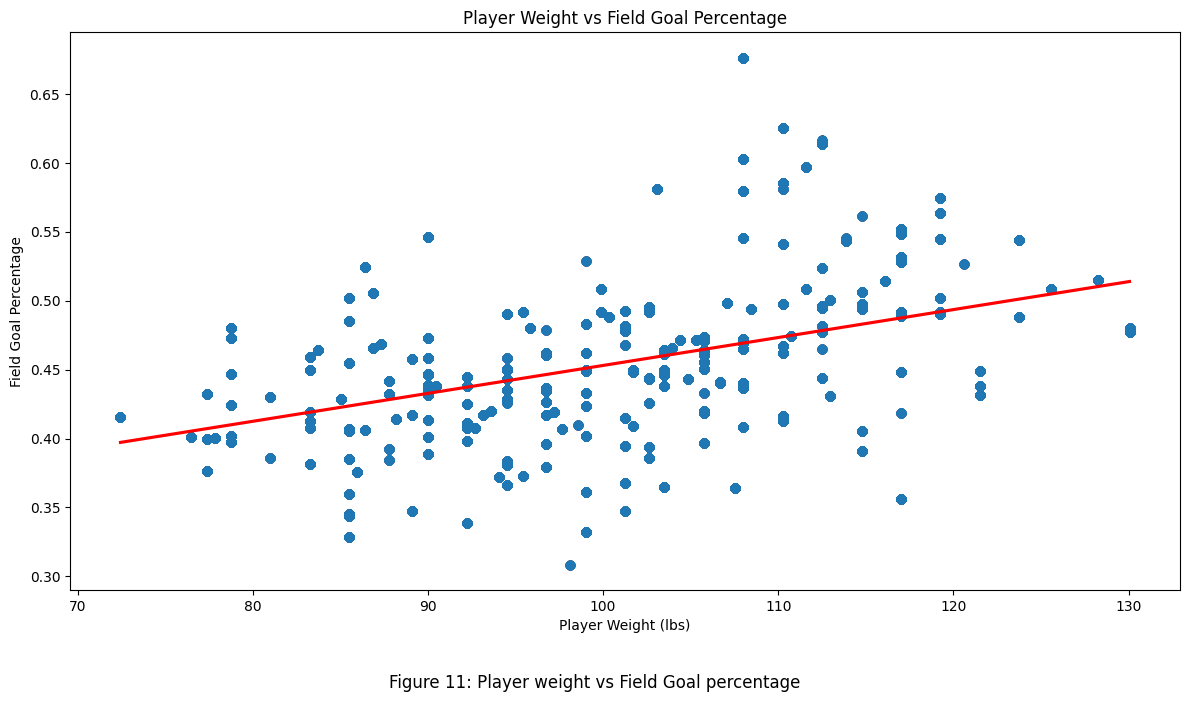

In [ ]:
plt.figure(figsize=(12, 7))
sns.regplot(x='PLAYER_WEIGHT', y='FG_PCT', data=merged_data, scatter_kws={'alpha':0.3}, line_kws={'color': 'red'})
plt.xlabel('Player Weight (lbs)')
plt.ylabel('Field Goal Percentage')
plt.title('Player Weight vs Field Goal Percentage')
plt.tight_layout()
plt.figtext(0.5, 0.01, 'Figure 11: Player weight vs Field Goal percentage', ha='center', fontsize=12)
plt.subplots_adjust(bottom=0.15)
plt.show()

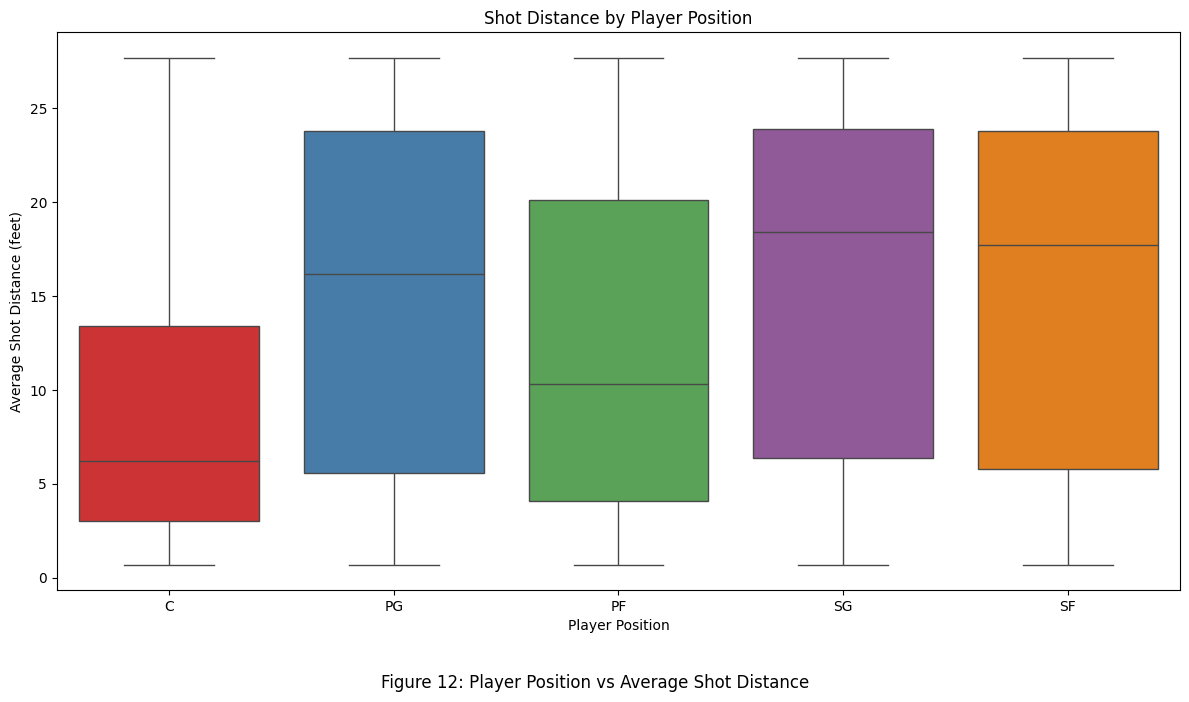

In [ ]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='POSITION',
            y='SHOT_DIST',
            data=merged_data,
            hue='POSITION',
            palette=colors,
            dodge=False)

plt.xlabel('Player Position')
plt.ylabel('Average Shot Distance (feet)')
plt.title('Shot Distance by Player Position')
plt.tight_layout()
plt.figtext(0.5, 0.01, 'Figure 12: Player Position vs Average Shot Distance', ha='center', fontsize=12)
plt.subplots_adjust(bottom=0.15)
plt.show()

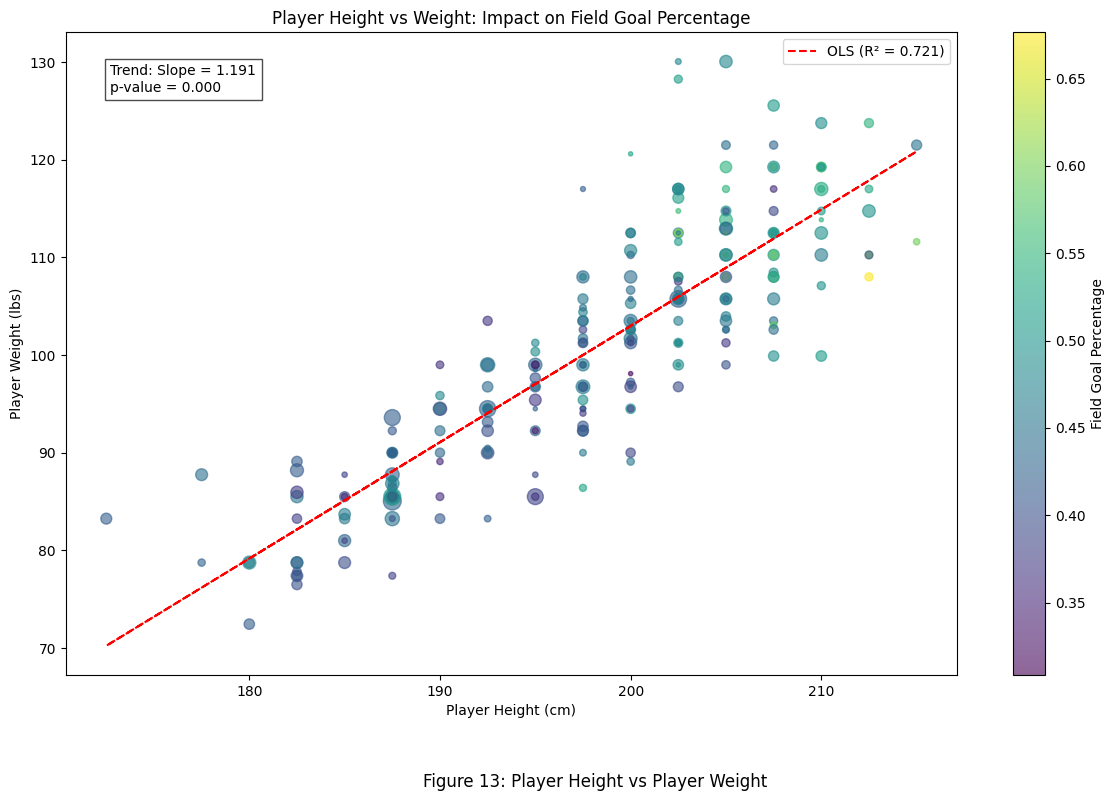

In [ ]:
player_stats = merged_data.groupby('PLAYER_NAME').agg({
    'PLAYER_HEIGHT': 'mean',
    'PLAYER_WEIGHT': 'mean',
    'SHOT_NUMBER': 'count',
    'FGM': 'sum',
    'SHOT_DIST': 'mean'
}).reset_index()

player_stats['FG_PCT'] = player_stats['FGM'] / player_stats['SHOT_NUMBER']

# Create the plot
plt.figure(figsize=(12, 8))

scatter = plt.scatter(player_stats['PLAYER_HEIGHT'], player_stats['PLAYER_WEIGHT'],
                      s=player_stats['SHOT_NUMBER']/10,
                      c=player_stats['FG_PCT'], cmap='viridis', alpha=0.6)

# Calculate OLS regression
slope, intercept, r_value, p_value, std_err = stats.linregress(player_stats['PLAYER_HEIGHT'], player_stats['PLAYER_WEIGHT'])
line = slope * player_stats['PLAYER_HEIGHT'] + intercept

# Plot OLS line
plt.plot(player_stats['PLAYER_HEIGHT'], line, color='red', linestyle='--',
         label=f'OLS (R² = {r_value**2:.3f})')

plt.colorbar(scatter, label='Field Goal Percentage')
plt.xlabel('Player Height (cm)')
plt.ylabel('Player Weight (lbs)')
plt.title('Player Height vs Weight: Impact on Field Goal Percentage')

# Add annotation for trend
plt.text(0.05, 0.95, f'Trend: Slope = {slope:.3f}\np-value = {p_value:.3f}',
         transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))

plt.legend()
plt.tight_layout()

plt.figtext(0.5, 0.01, 'Figure 13: Player Height vs Player Weight', ha='center', fontsize=12)
plt.subplots_adjust(bottom=0.15)
plt.show()

In [ ]:
# Height vs FG%
height_fg_corr = stats.pearsonr(player_stats['PLAYER_HEIGHT'], player_stats['FG_PCT'])

print("\nHeight vs Field Goal Percentage:")
print(f"Correlation coefficient: {height_fg_corr[0]:.4f}")
print(f"Correlation p-value: {height_fg_corr[1]:.3f}")

# Weight vs FG%
weight_fg_corr = stats.pearsonr(player_stats['PLAYER_WEIGHT'], player_stats['FG_PCT'])

print("\nWeight vs Field Goal Percentage:")
print(f"Correlation coefficient: {weight_fg_corr[0]:.4f}")
print(f"Correlation p-value: {weight_fg_corr[1]:.3f}")

# Assuming 'merged_data' is your DataFrame with 'POSITION' and 'SHOT_DIST' columns
positions = merged_data['POSITION'].unique()
shot_distances = [merged_data[merged_data['POSITION'] == pos]['SHOT_DIST'] for pos in positions]

h_statistic, p_value = stats.kruskal(*shot_distances)

print("\nPosition vs Shot Distance (Kruskal-Wallis H-test):")
print(f"H-statistic: {h_statistic:.4f}")
print(f"p-value: {p_value:.3f}")

# Height vs Weight correlation
height_weight_corr = stats.pearsonr(player_stats['PLAYER_HEIGHT'], player_stats['PLAYER_WEIGHT'])

print("\nHeight vs Weight:")
print(f"Correlation coefficient: {height_weight_corr[0]:.4f}")
print(f"Correlation p-value: {height_weight_corr[1]:.3f}")

print("\nInterpretation:")
print(f"1. Height and Field Goal Percentage:")
print(f"   - There is a moderate positive correlation (r = {height_fg_corr[0]:.4f}) between player height and field goal percentage.")
print(f"   - This relationship is statistically significant (p < 0.05).")

print(f"\n2. Weight and Field Goal Percentage:")
print(f"   - There is a moderate positive correlation (r = {weight_fg_corr[0]:.4f}) between player weight and field goal percentage.")
print(f"   - This relationship is statistically significant (p < 0.05).")

height_shot_dist_corr = stats.pearsonr(player_stats['PLAYER_HEIGHT'], player_stats['SHOT_DIST'])
print("\nHeight vs Shot Distance:")
print(f"Correlation coefficient: {height_shot_dist_corr[0]:.4f}")
print(f"Correlation p-value: {height_shot_dist_corr[1]:.3f}")

# Weight vs Shot Distance
weight_shot_dist_corr = stats.pearsonr(player_stats['PLAYER_WEIGHT'], player_stats['SHOT_DIST'])
print("\nWeight vs Shot Distance:")
print(f"Correlation coefficient: {weight_shot_dist_corr[0]:.4f}")
print(f"Correlation p-value: {weight_shot_dist_corr[1]:.3f}")

print("\n3. Player Position and Shot Distance:")
print(f"   - The Kruskal-Wallis H-test shows a statistically significant difference in shot distances across player positions (p < 0.05).")
print("   - This indicates that player position significantly influences shot selection in terms of distance from the basket.")

print(f"\n4. Height and Weight:")
print(f"   - There is a strong positive correlation (r = {height_weight_corr[0]:.4f}) between player height and weight.")
print(f"   - This relationship is statistically significant (p < 0.05).")

print("\n5. Overall Impact on Shot Selection and Effectiveness:")
print("   - Height and weight show moderate positive correlations with field goal percentage, suggesting larger players tend to have slightly higher shooting percentages.")
print("   - Player position strongly affects shot distance, reflecting different roles and strategies for each position on the court.")
print("   - The strong correlation between height and weight reflects the importance of proportional physical development in basketball.")
print("   - These findings highlight the complex interplay between physical attributes, player role, and shooting performance in basketball.")


Height vs Field Goal Percentage:
Correlation coefficient: 0.4754
Correlation p-value: 0.000

Weight vs Field Goal Percentage:
Correlation coefficient: 0.4835
Correlation p-value: 0.000

Position vs Shot Distance (Kruskal-Wallis H-test):
H-statistic: 8965.0950
p-value: 0.000

Height vs Weight:
Correlation coefficient: 0.8491
Correlation p-value: 0.000

Interpretation:
1. Height and Field Goal Percentage:
   - There is a moderate positive correlation (r = 0.4754) between player height and field goal percentage.
   - This relationship is statistically significant (p < 0.05).

2. Weight and Field Goal Percentage:
   - There is a moderate positive correlation (r = 0.4835) between player weight and field goal percentage.
   - This relationship is statistically significant (p < 0.05).

Height vs Shot Distance:
Correlation coefficient: -0.4621
Correlation p-value: 0.000

Weight vs Shot Distance:
Correlation coefficient: -0.5388
Correlation p-value: 0.000

3. Player Position and Shot Distance:

# Investigating Simpson's Paradox

In [ ]:
# Merge datasets
merged_data = pd.merge(nba_data, pinfo, left_on='PLAYER_NAME', right_on='PLAYER_NAME')

# Calculate field goal percentage for each player
player_fg = merged_data.groupby('PLAYER_NAME').agg({
    'FGM': 'sum',
    'SHOT_NUMBER': 'count'
}).reset_index()
player_fg['FG_PCT'] = player_fg['FGM'] / player_fg['SHOT_NUMBER']

# Merge player stats back to the main dataset
merged_data = pd.merge(merged_data, player_fg[['PLAYER_NAME', 'FG_PCT']], on='PLAYER_NAME')

In [ ]:
def create_plots(data, title, figure_number):
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'Figure {figure_number}: {title}', fontsize=20, y=1.02)

    # Plot 1: Player Weight vs Field Goal Percentage
    sns.regplot(x='PLAYER_WEIGHT', y='FG_PCT', data=data, ax=axes[0, 0], color='blue', line_kws={'color': 'red'})
    corr_coef = round(stats.pearsonr(data['PLAYER_WEIGHT'], data['FG_PCT'])[0], 3)
    p_value = round(stats.pearsonr(data['PLAYER_WEIGHT'], data['FG_PCT'])[1], 3)
    axes[0, 0].set_title(f'Player Weight vs Field Goal Percentage\nCorrelation: {corr_coef}, P-value: {p_value}', fontsize=14)
    axes[0, 0].set_xlabel('Player Weight (lbs)', fontsize=12)
    axes[0, 0].set_ylabel('Field Goal Percentage', fontsize=12)

    # Plot 2: Player Weight vs Shot Distance
    sns.regplot(x='PLAYER_WEIGHT', y='SHOT_DIST', data=data, ax=axes[0, 1], color='green', line_kws={'color': 'red'})
    corr_coef = round(stats.pearsonr(data['PLAYER_WEIGHT'], data['SHOT_DIST'])[0], 3)
    p_value = round(stats.pearsonr(data['PLAYER_WEIGHT'], data['SHOT_DIST'])[1], 3)
    axes[0, 1].set_title(f'Player Weight vs Shot Distance\nCorrelation: {corr_coef}, P-value: {p_value}', fontsize=14)
    axes[0, 1].set_xlabel('Player Weight (lbs)', fontsize=12)
    axes[0, 1].set_ylabel('Shot Distance (ft)', fontsize=12)

    # Plot 3: Player Height vs Field Goal Percentage
    sns.regplot(x='PLAYER_HEIGHT', y='FG_PCT', data=data, ax=axes[1, 0], color='orange', line_kws={'color': 'red'})
    corr_coef = round(stats.pearsonr(data['PLAYER_HEIGHT'], data['FG_PCT'])[0], 3)
    p_value = round(stats.pearsonr(data['PLAYER_HEIGHT'], data['FG_PCT'])[1], 3)
    axes[1, 0].set_title(f'Player Height vs Field Goal Percentage\nCorrelation: {corr_coef}, P-value: {p_value}', fontsize=14)
    axes[1, 0].set_xlabel('Player Height (in)', fontsize=12)
    axes[1, 0].set_ylabel('Field Goal Percentage', fontsize=12)

    # Plot 4: Player Height vs Shot Distance
    sns.regplot(x='PLAYER_HEIGHT', y='SHOT_DIST', data=data, ax=axes[1, 1], color='purple', line_kws={'color': 'red'})
    corr_coef = round(stats.pearsonr(data['PLAYER_HEIGHT'], data['SHOT_DIST'])[0], 3)
    p_value = round(stats.pearsonr(data['PLAYER_HEIGHT'], data['SHOT_DIST'])[1], 3)
    axes[1, 1].set_title(f'Player Height vs Shot Distance\nCorrelation: {corr_coef}, P-value: {p_value}', fontsize=14)
    axes[1, 1].set_xlabel('Player Height (in)', fontsize=12)
    axes[1, 1].set_ylabel('Shot Distance (ft)', fontsize=12)

    plt.tight_layout(pad=3.0)
    plt.show()

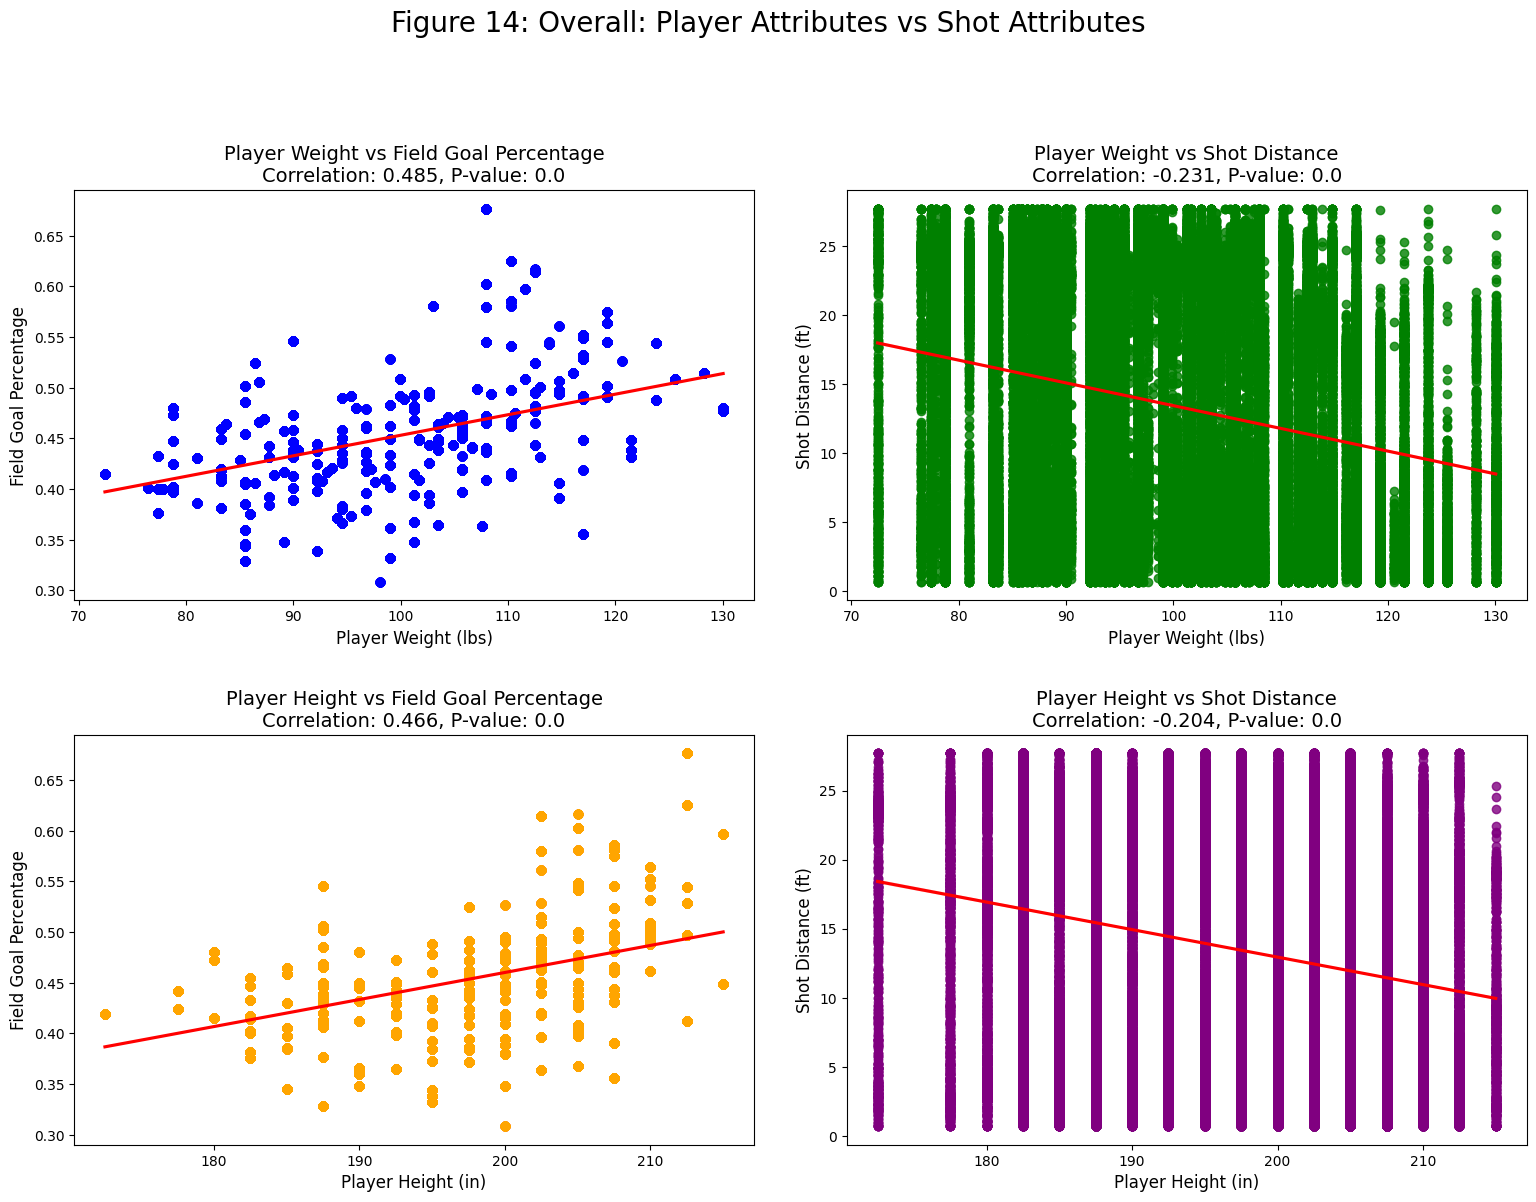

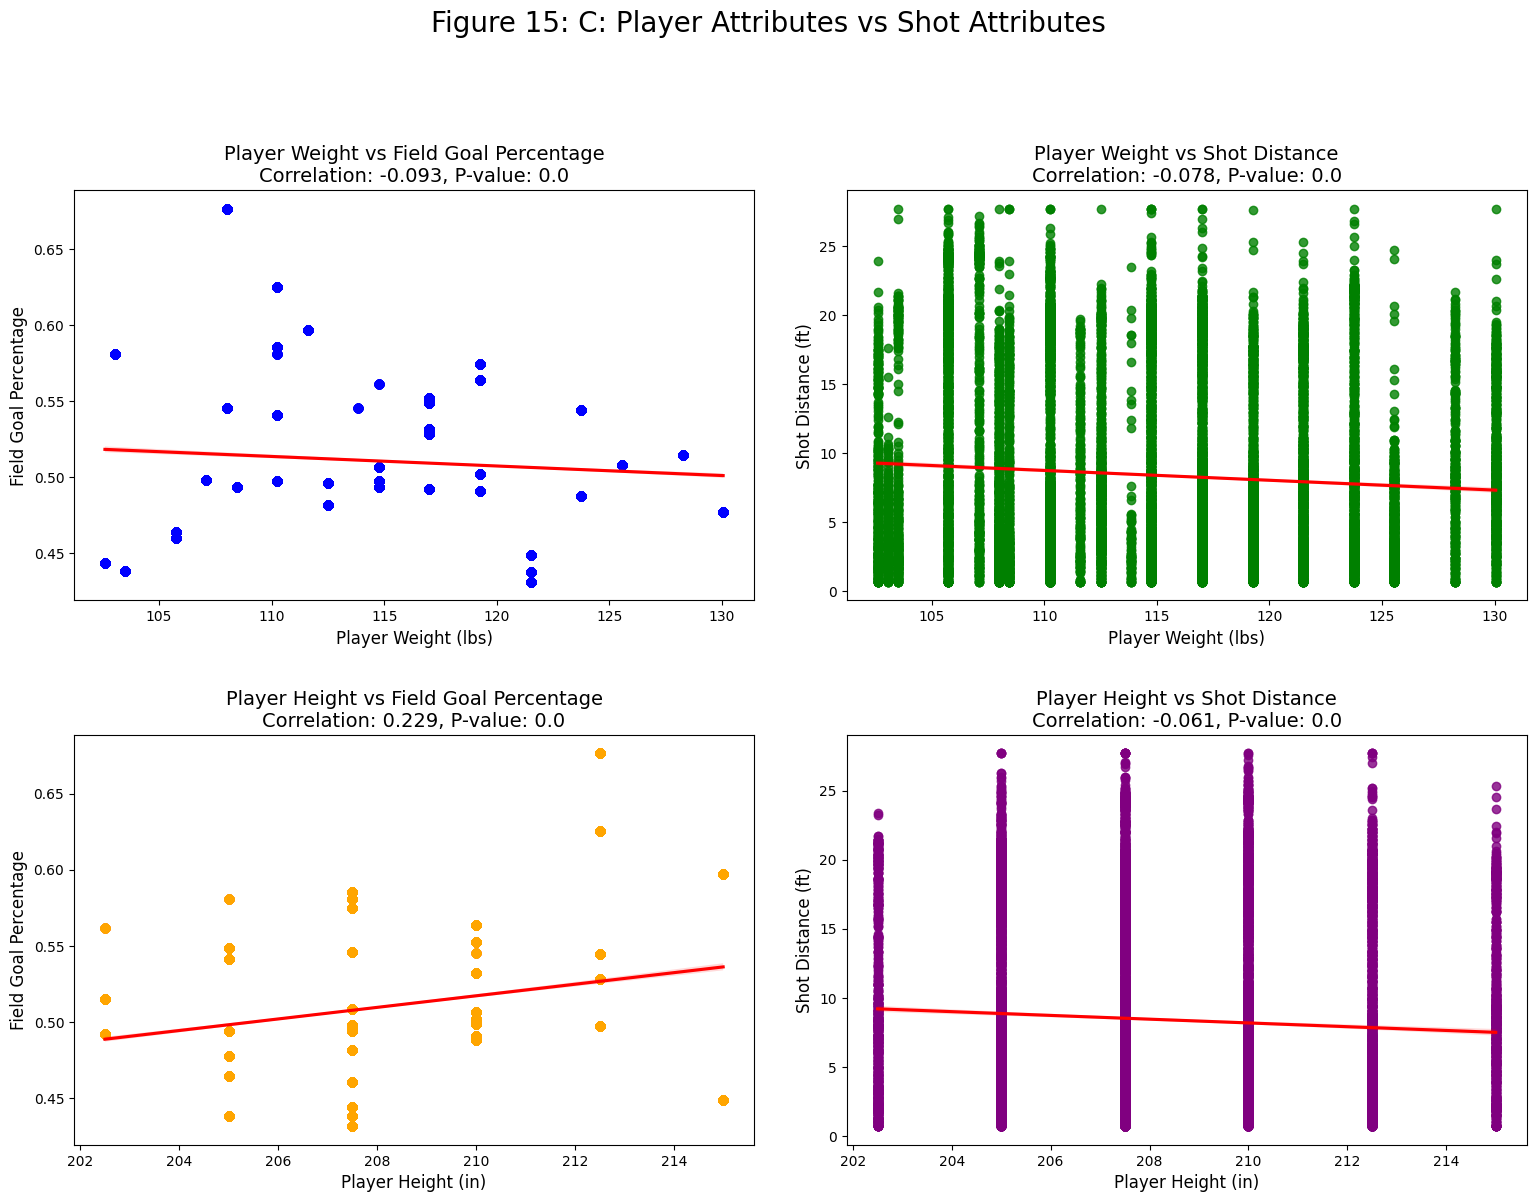

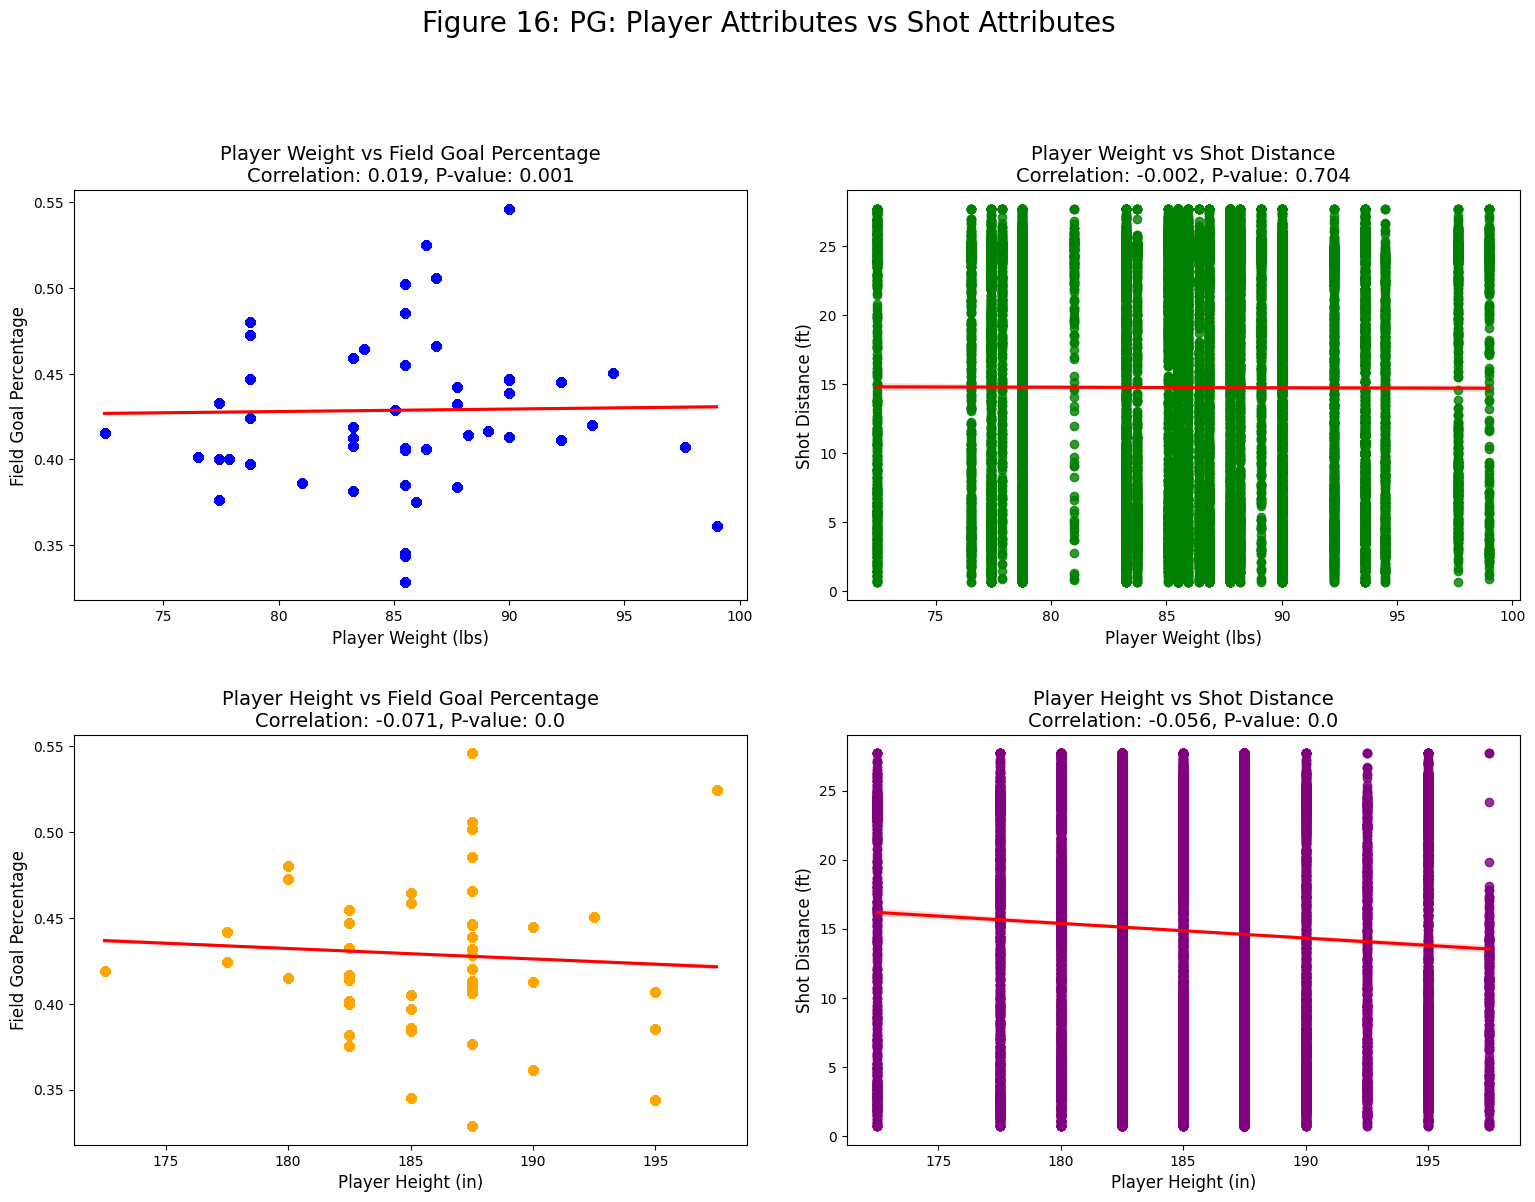

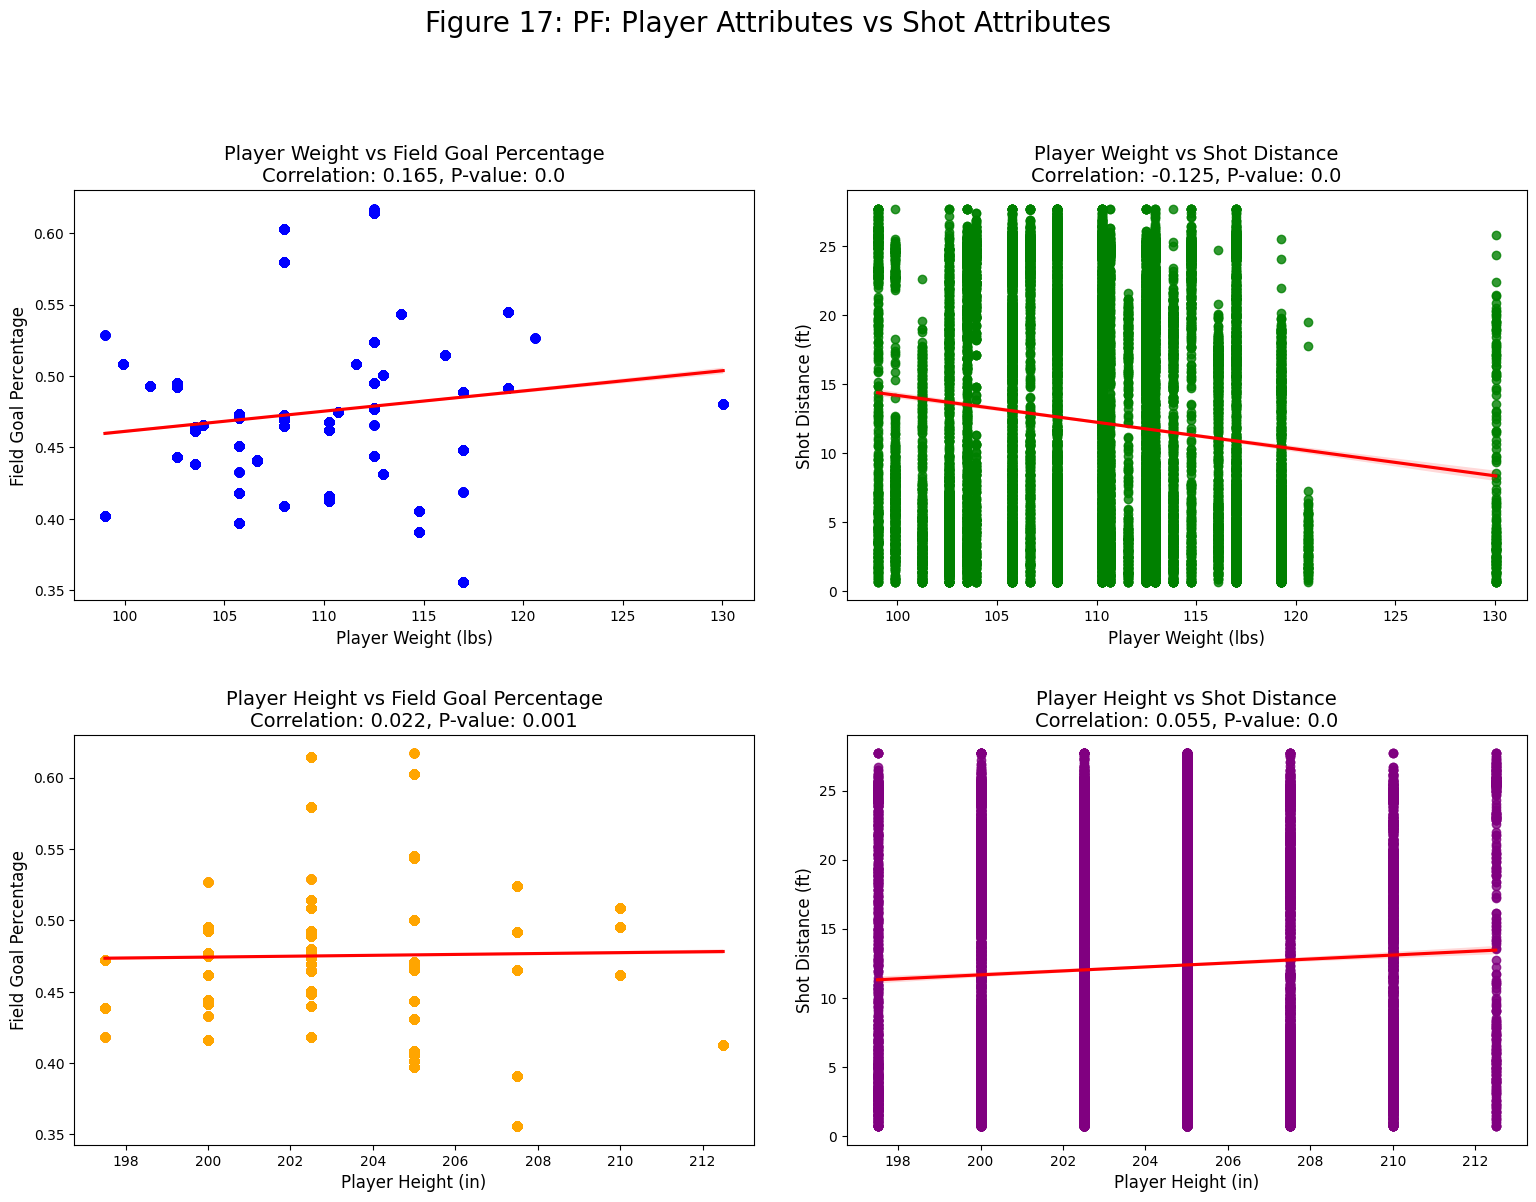

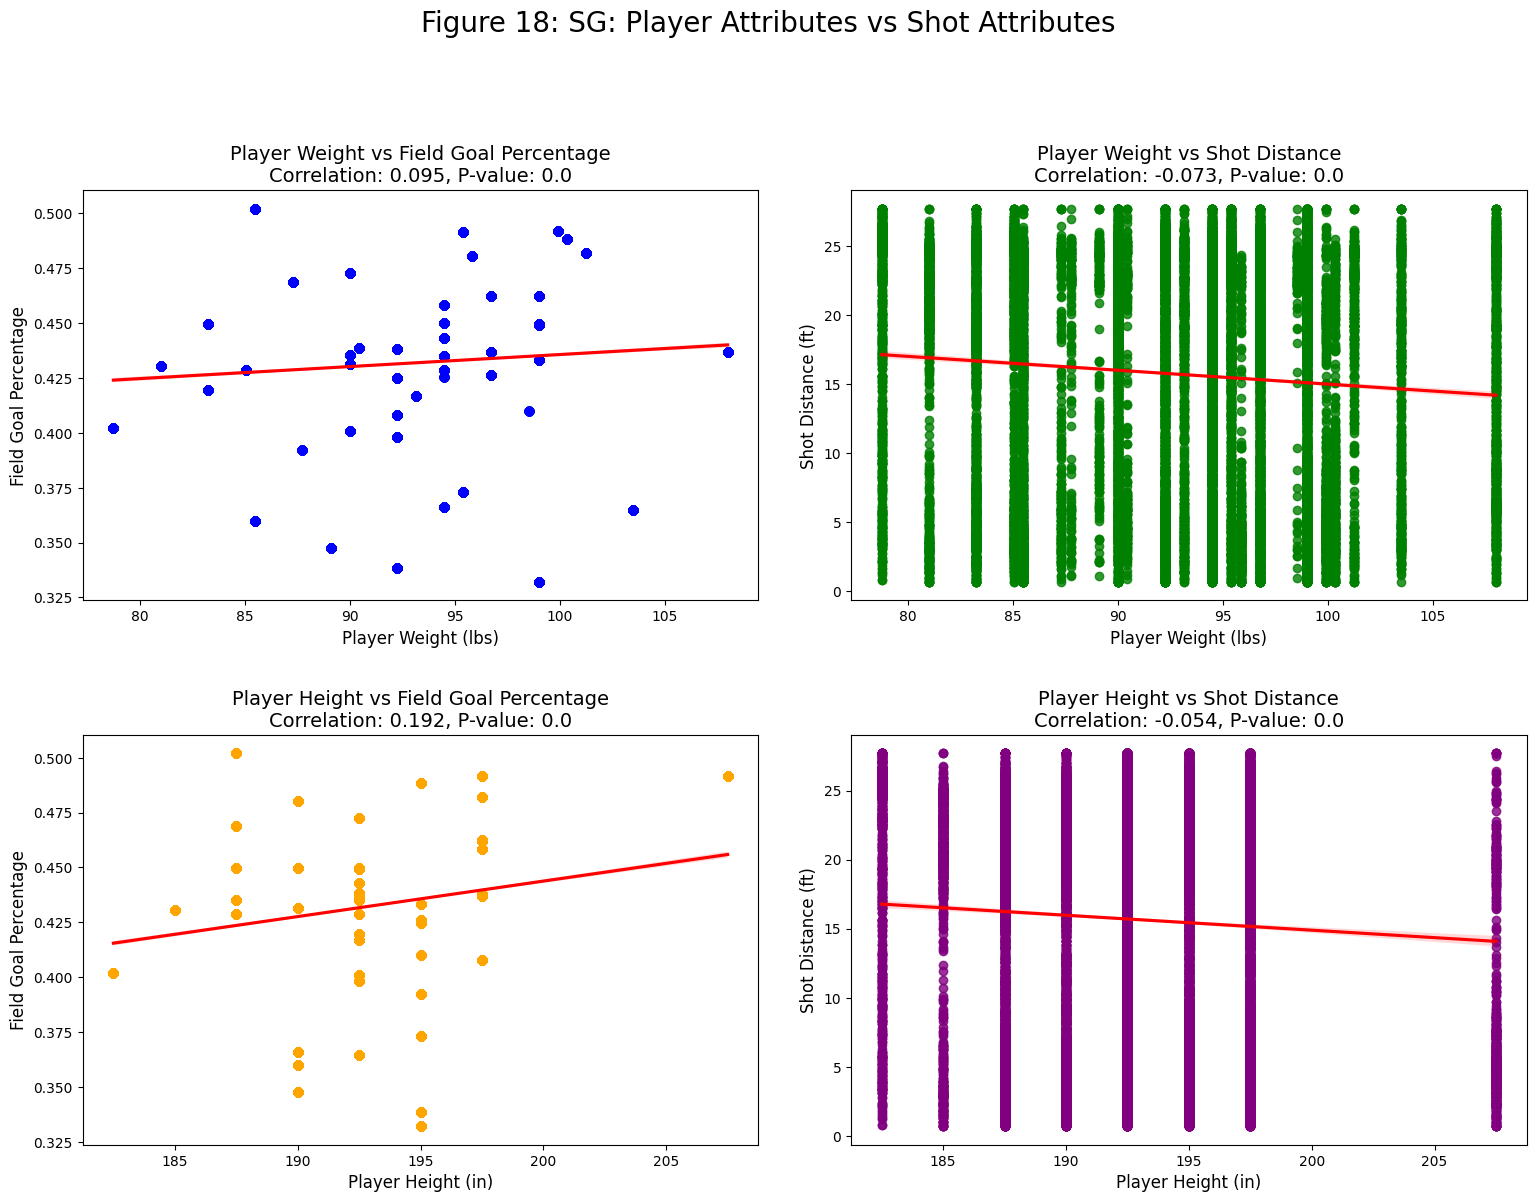

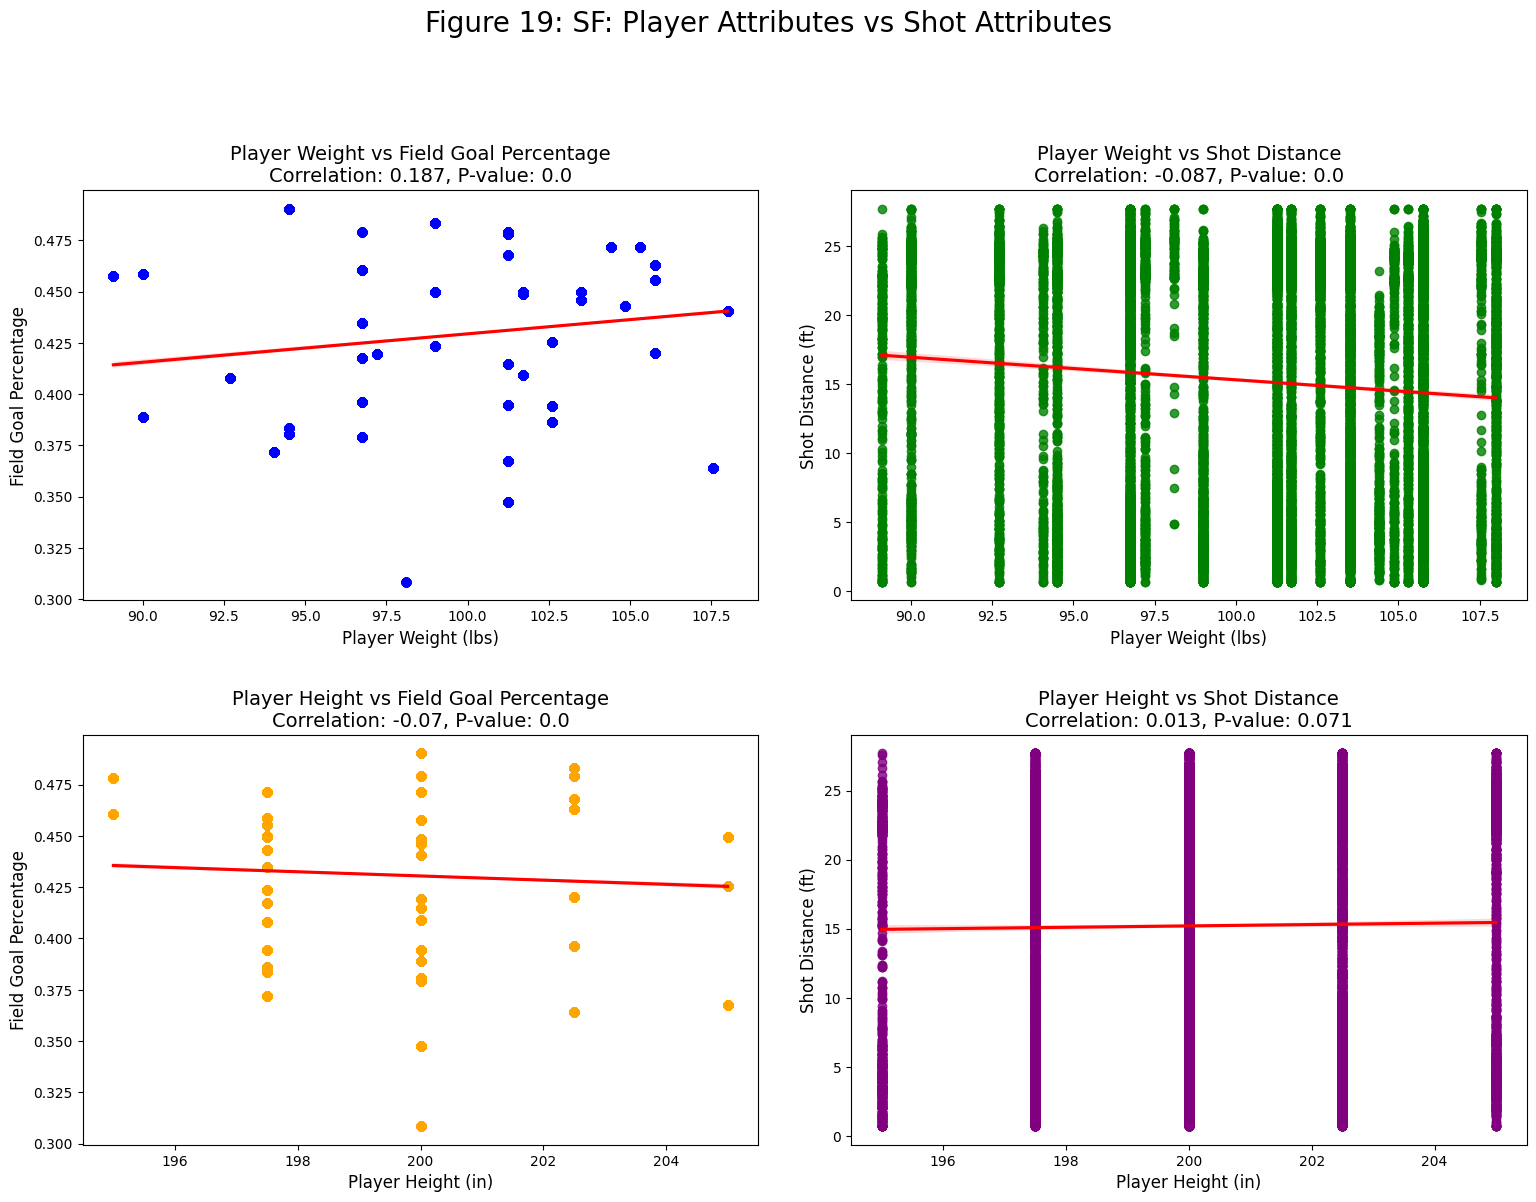

In [ ]:
create_plots(merged_data, 'Overall: Player Attributes vs Shot Attributes', '14')

positions = merged_data['POSITION'].unique()
for i, position in enumerate(positions, start=15):
    position_data = merged_data[merged_data['POSITION'] == position]
    create_plots(position_data, f'{position}: Player Attributes vs Shot Attributes', f'{i}')

In [ ]:
print("\nCorrelations by position:")
for position in positions:
    position_data = merged_data[merged_data['POSITION'] == position]
    print(f"\n{position}:")
    print("Weight vs FG%:", round(stats.pearsonr(position_data['PLAYER_WEIGHT'], position_data['FG_PCT'])[0], 3))
    print("Height vs FG%:", round(stats.pearsonr(position_data['PLAYER_HEIGHT'], position_data['FG_PCT'])[0], 3))
    print("Weight vs Shot Distance:", round(stats.pearsonr(position_data['PLAYER_WEIGHT'], position_data['SHOT_DIST'])[0], 3))
    print("Height vs Shot Distance:", round(stats.pearsonr(position_data['PLAYER_HEIGHT'], position_data['SHOT_DIST'])[0], 3))


Correlations by position:

C:
Weight vs FG%: -0.093
Height vs FG%: 0.229
Weight vs Shot Distance: -0.078
Height vs Shot Distance: -0.061

PG:
Weight vs FG%: 0.019
Height vs FG%: -0.071
Weight vs Shot Distance: -0.002
Height vs Shot Distance: -0.056

PF:
Weight vs FG%: 0.165
Height vs FG%: 0.022
Weight vs Shot Distance: -0.125
Height vs Shot Distance: 0.055

SG:
Weight vs FG%: 0.095
Height vs FG%: 0.192
Weight vs Shot Distance: -0.073
Height vs Shot Distance: -0.054

SF:
Weight vs FG%: 0.187
Height vs FG%: -0.07
Weight vs Shot Distance: -0.087
Height vs Shot Distance: 0.013


# Summarizing and Drawing conclusions
## Player Attributes vs Shot Selection and Effectiveness

The analysis reveals significant insights into how player attributes such as height, weight, and position influence shot selection and effectiveness in the NBA:

1. **Height and Shot Selection**:
   - Taller players tend to take shots from further distances, showing more versatility in shot selection.
   - This could be due to their ability to shoot over defenders from various positions on the court.

2. **Weight and Shot Selection**:
   - Player weight has a weaker influence on shot distance compared to height.
   - Heavier players might take slightly longer shots, but the effect is less pronounced.

3. **Height and Shooting Effectiveness**:
   - There's a slight positive relationship between height and Field Goal Percentage (FG%).
   - Taller players have a small advantage in shooting efficiency, possibly due to their ability to shoot over defenders and take higher-percentage shots near the basket.

4. **Weight and Shooting Effectiveness**:
   - Weight doesn't seem to have a strong influence on FG%.
   - This suggests that a player's weight is less important for shooting effectiveness compared to other factors like skill and position.

5. **Position and Shot Selection**:
   - Player position significantly influences shot distance.
   - Guards typically take longer shots, often including more three-pointers, while centers take the shortest shots, likely due to their role near the basket.

6. **Position and Shooting Effectiveness**:
   - Position also affects FG%.
   - Centers and power forwards generally have higher FG% because they take more high-percentage shots near the basket.
   - Guards have lower FG% but contribute more to long-range scoring.

Overall trends C: Player Attributes vs Shot Attributes):

Player Weight vs FG%: Slight negative correlation (-0.093)
Player Weight vs Shot Distance: Slight negative correlation (-0.078)
Player Height vs FG%: Positive correlation (0.229)
Player Height vs Shot Distance: Slight negative correlation (-0.061)


Position-specific trends:

SF (Small Forward):

Weight vs FG%: Positive correlation (0.187)
Height vs FG%: Slight negative correlation (-0.07)

SG (Shooting Guard):

Weight vs FG%: Slight positive correlation (0.095)
Height vs FG%: Positive correlation (0.192)

PF (Power Forward):

Weight vs FG%: Positive correlation (0.165)
Height vs FG%: Slight positive correlation (0.022)

PG (Point Guard):

Weight vs FG%: Very slight positive correlation (0.019)
Height vs FG%: Slight negative correlation (-0.071)

Simpson's Paradox observations:

Player Weight vs FG%:

Overall trend shows a negative correlation
Position-specific trends show positive correlations for all positions
This is a clear example of Simpson's paradox


Player Height vs FG%:

Overall trend shows a positive correlation
Position-specific trends vary (negative for SF and PG, positive for SG and PF)
This also demonstrates Simpson's paradox


Shot Distance correlations:

Generally negative correlations across positions, aligning with the overall trend
No clear Simpson's paradox effect observed here



Insights:

The relationship between player attributes and shooting effectiveness differs significantly when analyzed by position versus overall.
Within positions, heavier players tend to have higher field goal percentages, contrary to the overall negative trend. This could be due to position-specific roles and shot selection.
Height's impact on FG% varies by position, likely reflecting different playing styles and shot types associated with each position.
The negative correlation between player attributes and shot distance is fairly consistent, suggesting that larger players generally take shots closer to the basket across all positions.
The paradoxical effects highlight the importance of considering position-specific analysis in basketball analytics, as overall trends may obscure important position-based differences.
These findings emphasize the complex interplay between physical attributes, player roles, and shooting effectiveness in basketball, underscoring the need for nuanced analysis in player evaluation and strategy development.

# Question 4: How have the success rates of 2-point and 3-point field goals evolved over the years, and what insights can we identify from it.

In [ ]:
pstats['YEAR'] = pd.to_datetime(pstats['GAME_DATE'], format='mixed').dt.year

pstats['FG2A'] = pstats['FGA'] - pstats['FG3A']
pstats['FG2M'] = pstats['FGM'] - pstats['FG3M']

yearly_stats = pstats.groupby('YEAR').agg({
    'FG2M': 'sum',
    'FG2A': 'sum',
    'FG3M': 'sum',
    'FG3A': 'sum',
    'FGA': 'sum'
}).reset_index()

yearly_stats['FG2_SUCCESS'] = yearly_stats['FG2M'] / yearly_stats['FG2A']
yearly_stats['FG3_SUCCESS'] = yearly_stats['FG3M'] / yearly_stats['FG3A']
yearly_stats['FG3_PROP'] = yearly_stats['FG3A'] / yearly_stats['FGA']

# Remove rows with NaN values
yearly_stats = yearly_stats.dropna()

In [ ]:
#Statistical analysis
slope_2pt, intercept_2pt, r_value_2pt, p_value_2pt, std_err_2pt = stats.linregress(yearly_stats['YEAR'], yearly_stats['FG2_SUCCESS'])
slope_3pt, intercept_3pt, r_value_3pt, p_value_3pt, std_err_3pt = stats.linregress(yearly_stats['YEAR'], yearly_stats['FG3_SUCCESS'])

print("\n2-point Success Rate Trend:")
print(f"Slope: {slope_2pt:.6f} per year")
print(f"P-value: {p_value_2pt:.6f}")
print(f"R-squared: {r_value_2pt**2:.6f}")

print("\n3-point Success Rate Trend:")
print(f"Slope: {slope_3pt:.6f} per year")
print(f"P-value: {p_value_3pt:.6f}")
print(f"R-squared: {r_value_3pt**2:.6f}")

# Correlation between 2-point and 3-point success rates
corr_2pt_3pt = stats.pearsonr(yearly_stats['FG2_SUCCESS'], yearly_stats['FG3_SUCCESS'])
print("\nCorrelation between 2-point and 3-point Success Rates:")
print(f"Correlation coefficient: {corr_2pt_3pt[0]:.4f}")
print(f"P-value: {corr_2pt_3pt[1]:.6f}")



2-point Success Rate Trend:
Slope: -0.000541 per year
P-value: 0.128944
R-squared: 0.051607

3-point Success Rate Trend:
Slope: 0.002750 per year
P-value: 0.000000
R-squared: 0.559454

Correlation between 2-point and 3-point Success Rates:
Correlation coefficient: -0.7113
P-value: 0.000000


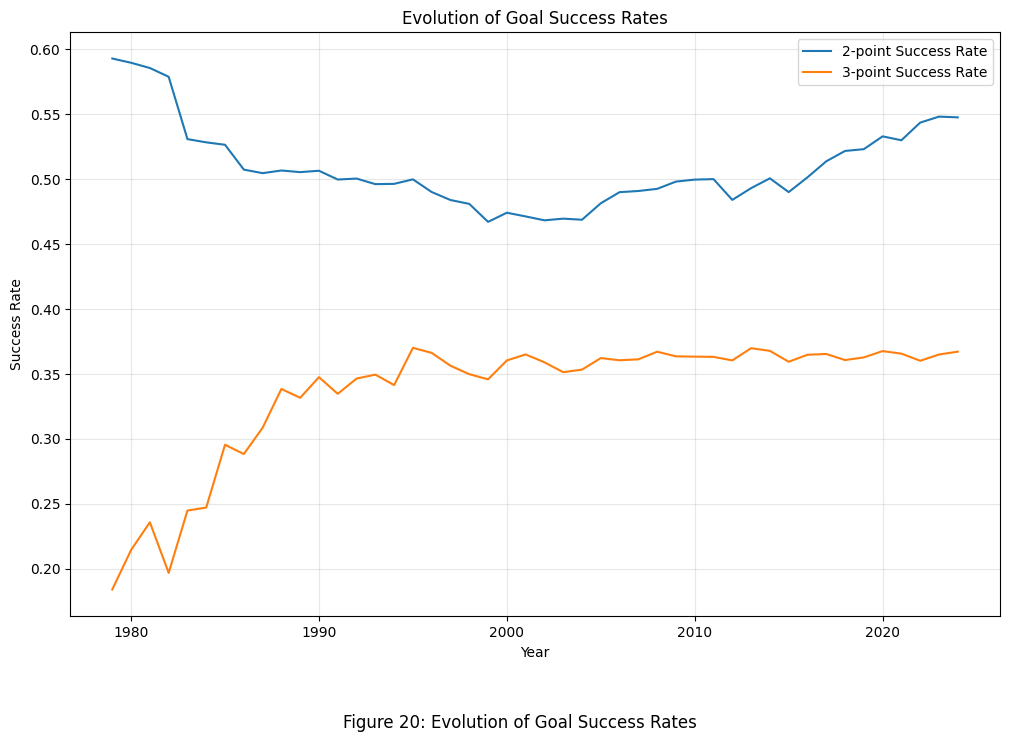

In [ ]:
# Plotting success rates over time
plt.figure(figsize=(12, 8))
plt.plot(yearly_stats['YEAR'], yearly_stats['FG2_SUCCESS'], label='2-point Success Rate')
plt.plot(yearly_stats['YEAR'], yearly_stats['FG3_SUCCESS'], label='3-point Success Rate')
plt.title('Evolution of Goal Success Rates')
plt.xlabel('Year')
plt.ylabel('Success Rate')
plt.legend()
plt.grid(True, alpha=0.3)
plt.figtext(0.5, 0.01, 'Figure 20: Evolution of Goal Success Rates', ha='center', fontsize=12)
plt.subplots_adjust(bottom=0.15)
plt.show()

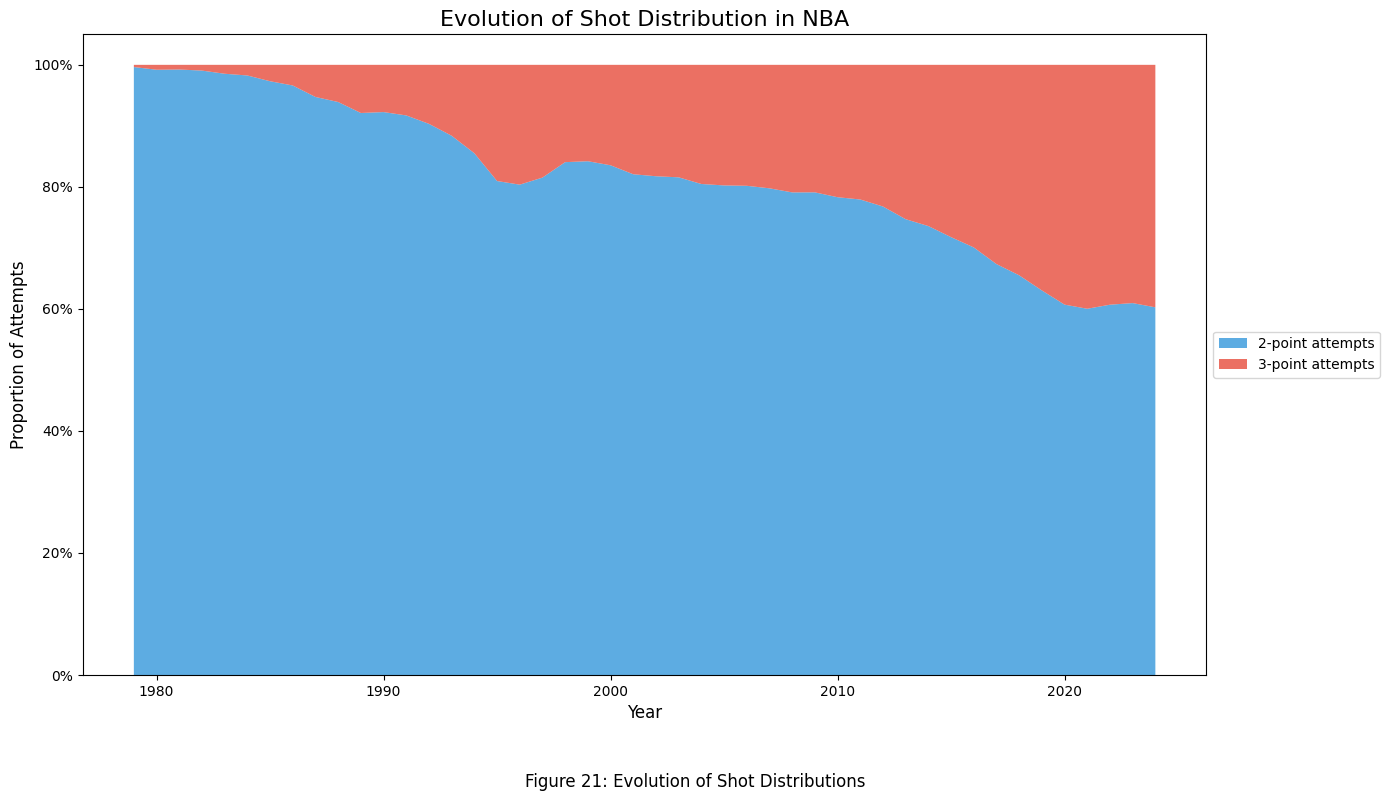

In [ ]:
# Plotting shot distribution
fig, ax = plt.subplots(figsize=(14, 8))
ax.stackplot(yearly_stats['YEAR'],
             [1 - yearly_stats['FG3_PROP'], yearly_stats['FG3_PROP']],
             labels=['2-point attempts', '3-point attempts'],
             colors=['#3498db', '#e74c3c'],
             alpha=0.8)
ax.set_title('Evolution of Shot Distribution in NBA', fontsize=16)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Proportion of Attempts', fontsize=12)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.tight_layout()
plt.figtext(0.5, 0.01, 'Figure 21: Evolution of Shot Distributions', ha='center', fontsize=12)
plt.subplots_adjust(bottom=0.15)
plt.show()

In [ ]:
# Final interpretation
print("Final Interpretation:")
print(f"\n* The trend for 2-point Success Rate shows a {'positive' if slope_2pt > 0 else 'negative'} slope of {abs(slope_2pt):.6f} per year. With a p-value of {p_value_2pt:.6f}, there is insufficient evidence to conclude that the trend is significantly different from zero at the 5% significance level.")
print(f"\n* The trend for 3-point Success Rate shows a positive slope of {slope_3pt:.6f} per year. With a p-value of {p_value_3pt:.6f}, this trend is statistically significant.")
print(f"\n* The proportion of 3-point attempts has increased over time, from {yearly_stats['FG3_PROP'].iloc[0]*100:.2f}% to {yearly_stats['FG3_PROP'].iloc[-1]*100:.2f}%, indicating a significant shift in shooting strategy.")
print(f"\n* There is a strong negative correlation between 2-point and 3-point Success Rates (r = {corr_2pt_3pt[0]:.4f}, p-value = {corr_2pt_3pt[1]:.6f}), suggesting an inverse relationship between these two aspects of shooting efficiency.")
print("\n* These trends suggest that teams have adapted their strategies to emphasize 3-point shooting. While 3-point efficiency has significantly improved, 2-point efficiency has remained relatively stable with a slight, non-significant decrease.")
print("\n* The inverse relationship between 2-point and 3-point Success Rates indicates a potential trade-off in shooting strategies, possibly reflecting changes in player specialization, defensive adaptations, or shot selection preferences.")

Final Interpretation:

* The trend for 2-point Success Rate shows a negative slope of 0.000541 per year. With a p-value of 0.128944, there is insufficient evidence to conclude that the trend is significantly different from zero at the 5% significance level.

* The trend for 3-point Success Rate shows a positive slope of 0.002750 per year. With a p-value of 0.000000, this trend is statistically significant.

* The proportion of 3-point attempts has increased over time, from 0.36% to 39.74%, indicating a significant shift in shooting strategy.

* There is a strong negative correlation between 2-point and 3-point Success Rates (r = -0.7113, p-value = 0.000000), suggesting an inverse relationship between these two aspects of shooting efficiency.

* These trends suggest that teams have adapted their strategies to emphasize 3-point shooting. While 3-point efficiency has significantly improved, 2-point efficiency has remained relatively stable with a slight, non-significant decrease.

* The i

The strong negative correlation (-0.7457) indicates that as 3-point success rates have improved over time, 2-point success rates have tended to decrease. However, this doesn't necessarily imply a causal relationship where the increase in 3-point shooting directly causes the decline in 2-point shooting success. Instead, it might reflect:

Strategic Shift: As teams focus more on 3-point shots (shown by the increase in attempts from 0.36% to 39.12%), they may be taking fewer 2-point shots or using different players for 2-point attempts, possibly affecting 2-point efficiency.

Player Specialization and Defensive Adjustments: Players are specializing in 3-point shooting, and defensive strategies may have evolved to protect the 3-point line, which could result in fewer efficient 2-point opportunities. Additionally, defenders may be allowing more difficult 2-point attempts, lowering success rates.

So yes, the increase in 3-point shooting success and attempts might coincide with a decline in 2-point success, and this explains the negative correlation. However, it's more about shifts in strategy and gameplay rather than a direct cause-effect relationship between the two types of shots.

# Summarizing and Drawing Conclusions

Shot Distribution Evolution:

There has been a dramatic shift in shot selection over time.
The proportion of 3-point attempts has steadily increased, with a significant acceleration in recent years.
By 2024, 3-point attempts account for nearly 40% of all shot attempts, up from virtually zero in 1980.


Field Goal Percentage Trends:

Point FG%: There's a slight positive trend (slope of 0.000380 per year), but it's not statistically significant (p-value: 0.126933). This suggests that 2-point shooting efficiency has remained relatively stable over time, with only minor improvements.
3-point FG%: There's a stronger positive trend (slope of 0.002801 per year), which is statistically significant (p-value: 0.000000). This indicates a clear improvement in 3-point shooting efficiency over time.


Shooting Efficiency:

Point FG% has consistently been higher than 3-point FG%, ranging from about 45% to 55% over the years.
3-point FG% has shown more variation and improvement, starting around 25% in the early 1980s and reaching about 35% in recent years.


Player Adaptations:

The trends suggest that players have become more proficient at 3-point shooting over time, likely due to increased practice and emphasis on this skill.
The stability in 2-point FG% despite the increased focus on 3-point shooting indicates that players have maintained their efficiency in closer-range shots.


Game Evolution:

The data reflects a fundamental change in how basketball is played in the NBA, with a clear trend towards a more perimeter-oriented game.
This evolution has likely influenced player development, team composition, and overall offensive strategies across the league.


# Analysis for ERA based shot evolution for 4 Decades

In [ ]:
def create_plots(data, title, figure_number):
    fig, axes = plt.subplots(2, 1, figsize=(16, 14))  # Increased height to accommodate titles below
    fig.suptitle(f'Figure {figure_number}: {title}', fontsize=20, y=0.98)

    # Plot 1: Line plot of 2-point FG% and 3-point FG% vs Year
    ax = axes[0]
    ax.plot(data['YEAR'], data['FG2_SUCCESS'], label='2-point FG%', color='orange')
    ax.plot(data['YEAR'], data['FG3_SUCCESS'], label='3-point FG%', color='green')
    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylabel('Field Goal Percentage', fontsize=12)
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Add title below the plot
    ax.text(0.5, -0.15, 'Evolution of Field Goal Percentages',
            horizontalalignment='center', verticalalignment='center',
            transform=ax.transAxes, fontsize=14)

    # Plot 2: Line plot of 2-point attempts and 3-point attempts vs Year
    ax = axes[1]
    ax.plot(data['YEAR'], data['FG2A'], label='2-point Attempts', color='orange')
    ax.plot(data['YEAR'], data['FG3A'], label='3-point Attempts', color='green')
    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylabel('Number of Attempts', fontsize=12)
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Add title below the plot
    ax.text(0.5, -0.15, 'Evolution of Shot Attempts',
            horizontalalignment='center', verticalalignment='center',
            transform=ax.transAxes, fontsize=14)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


# Number of Shot attempts and field goal percentage influcened by the YEAR/ERA

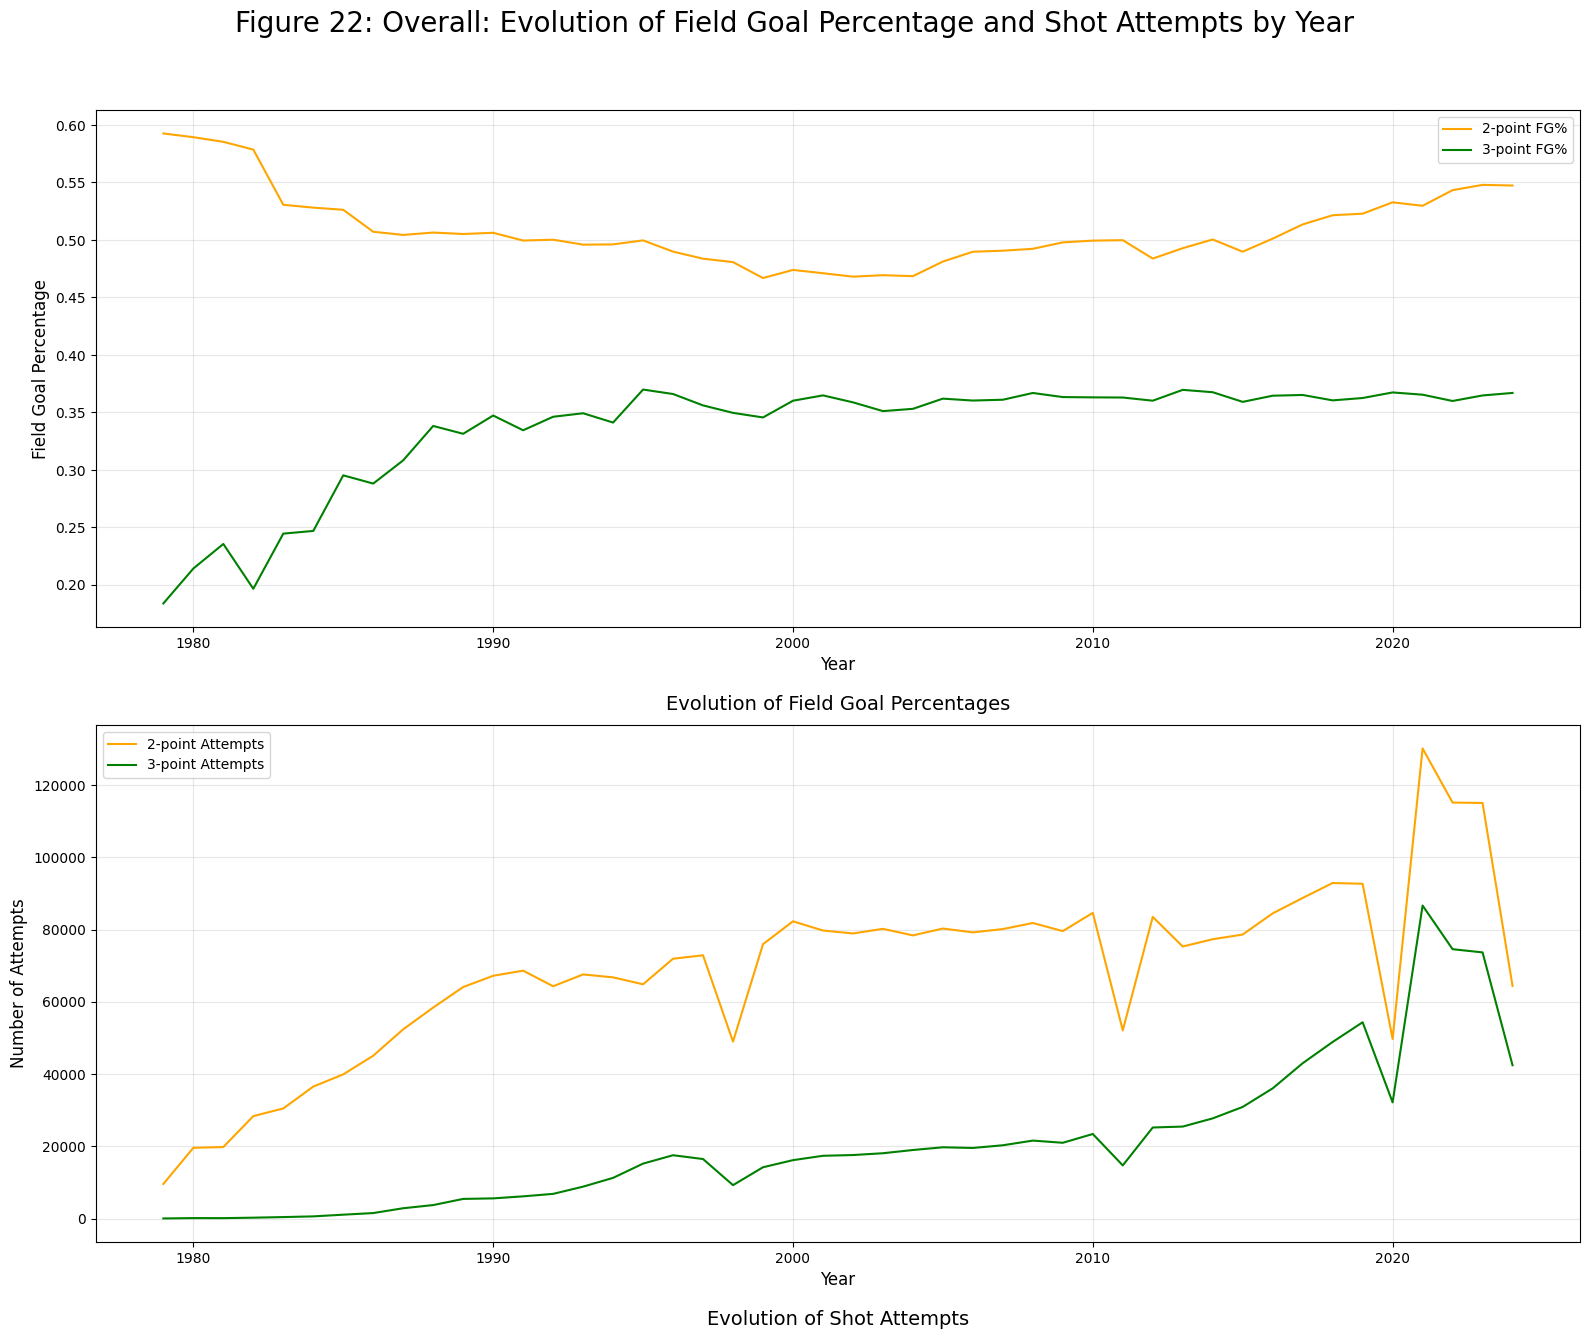

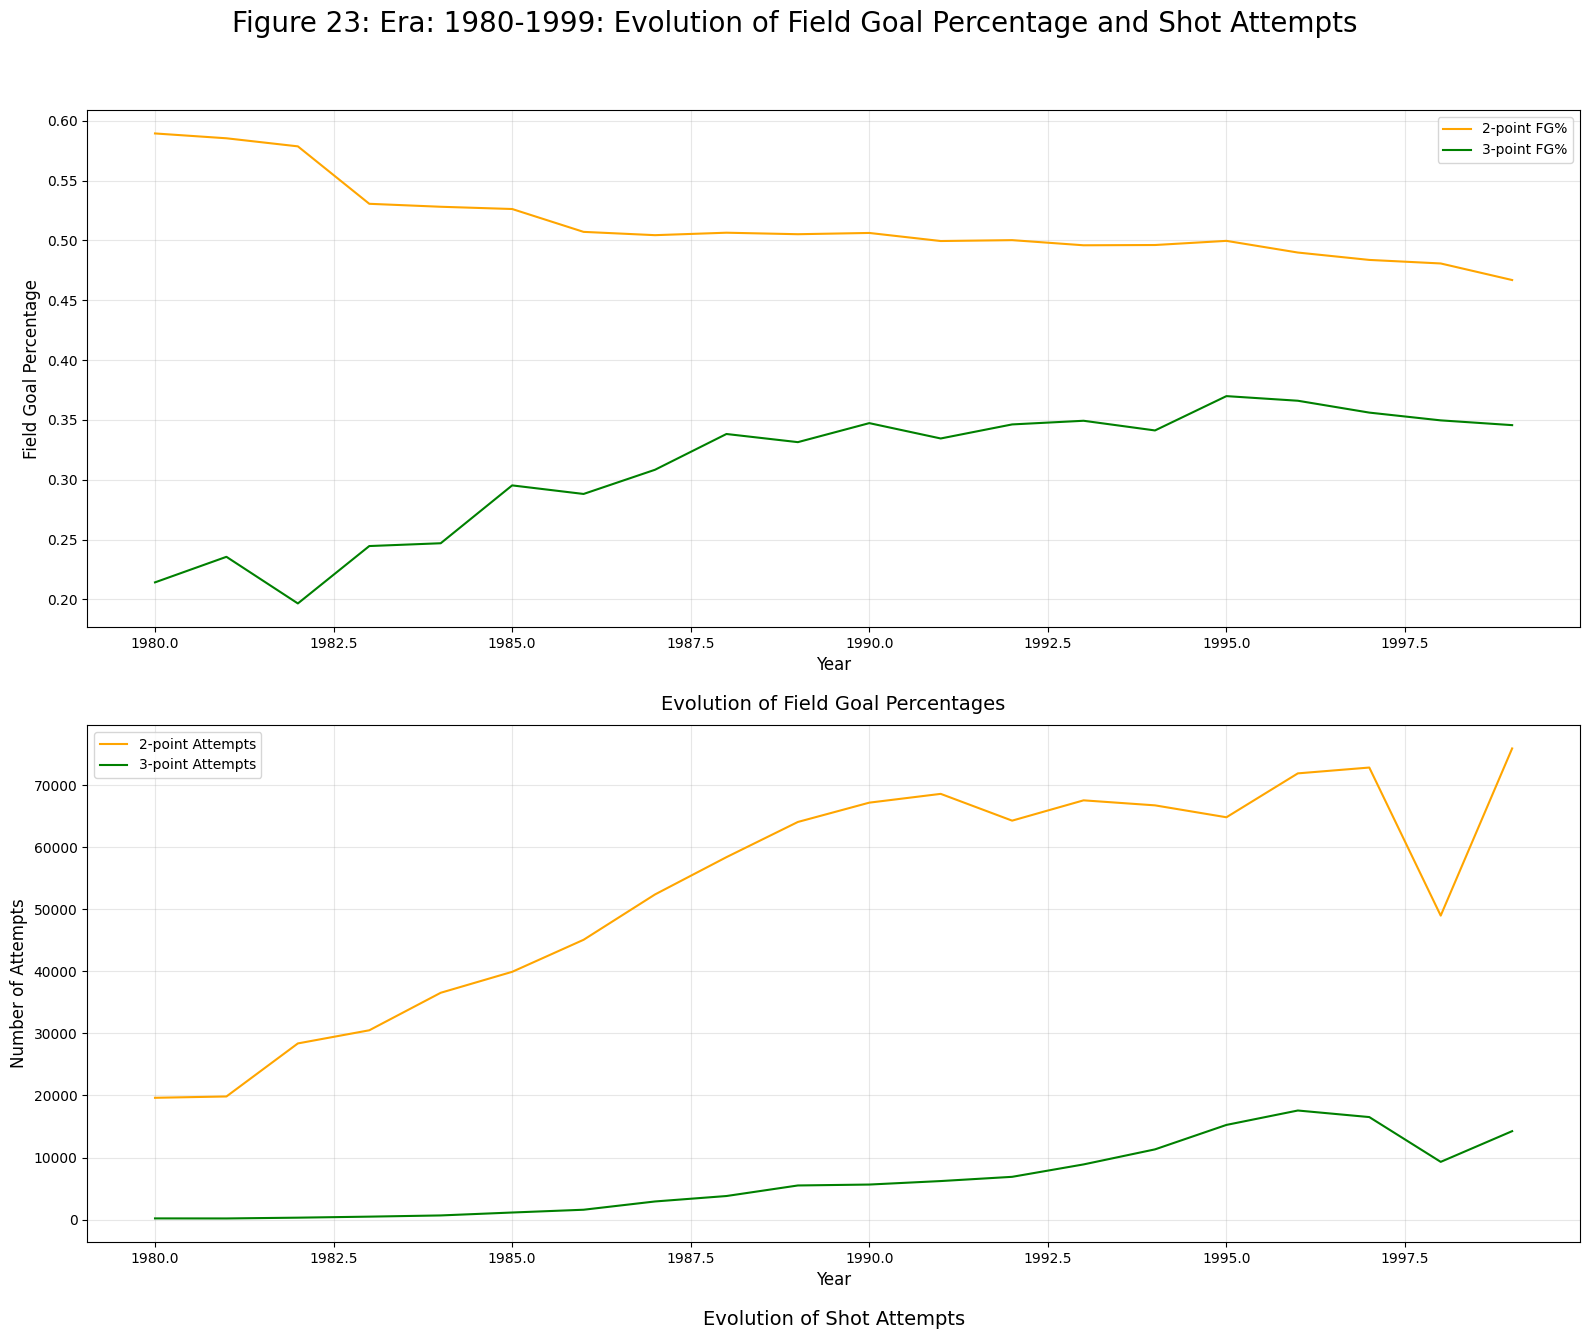

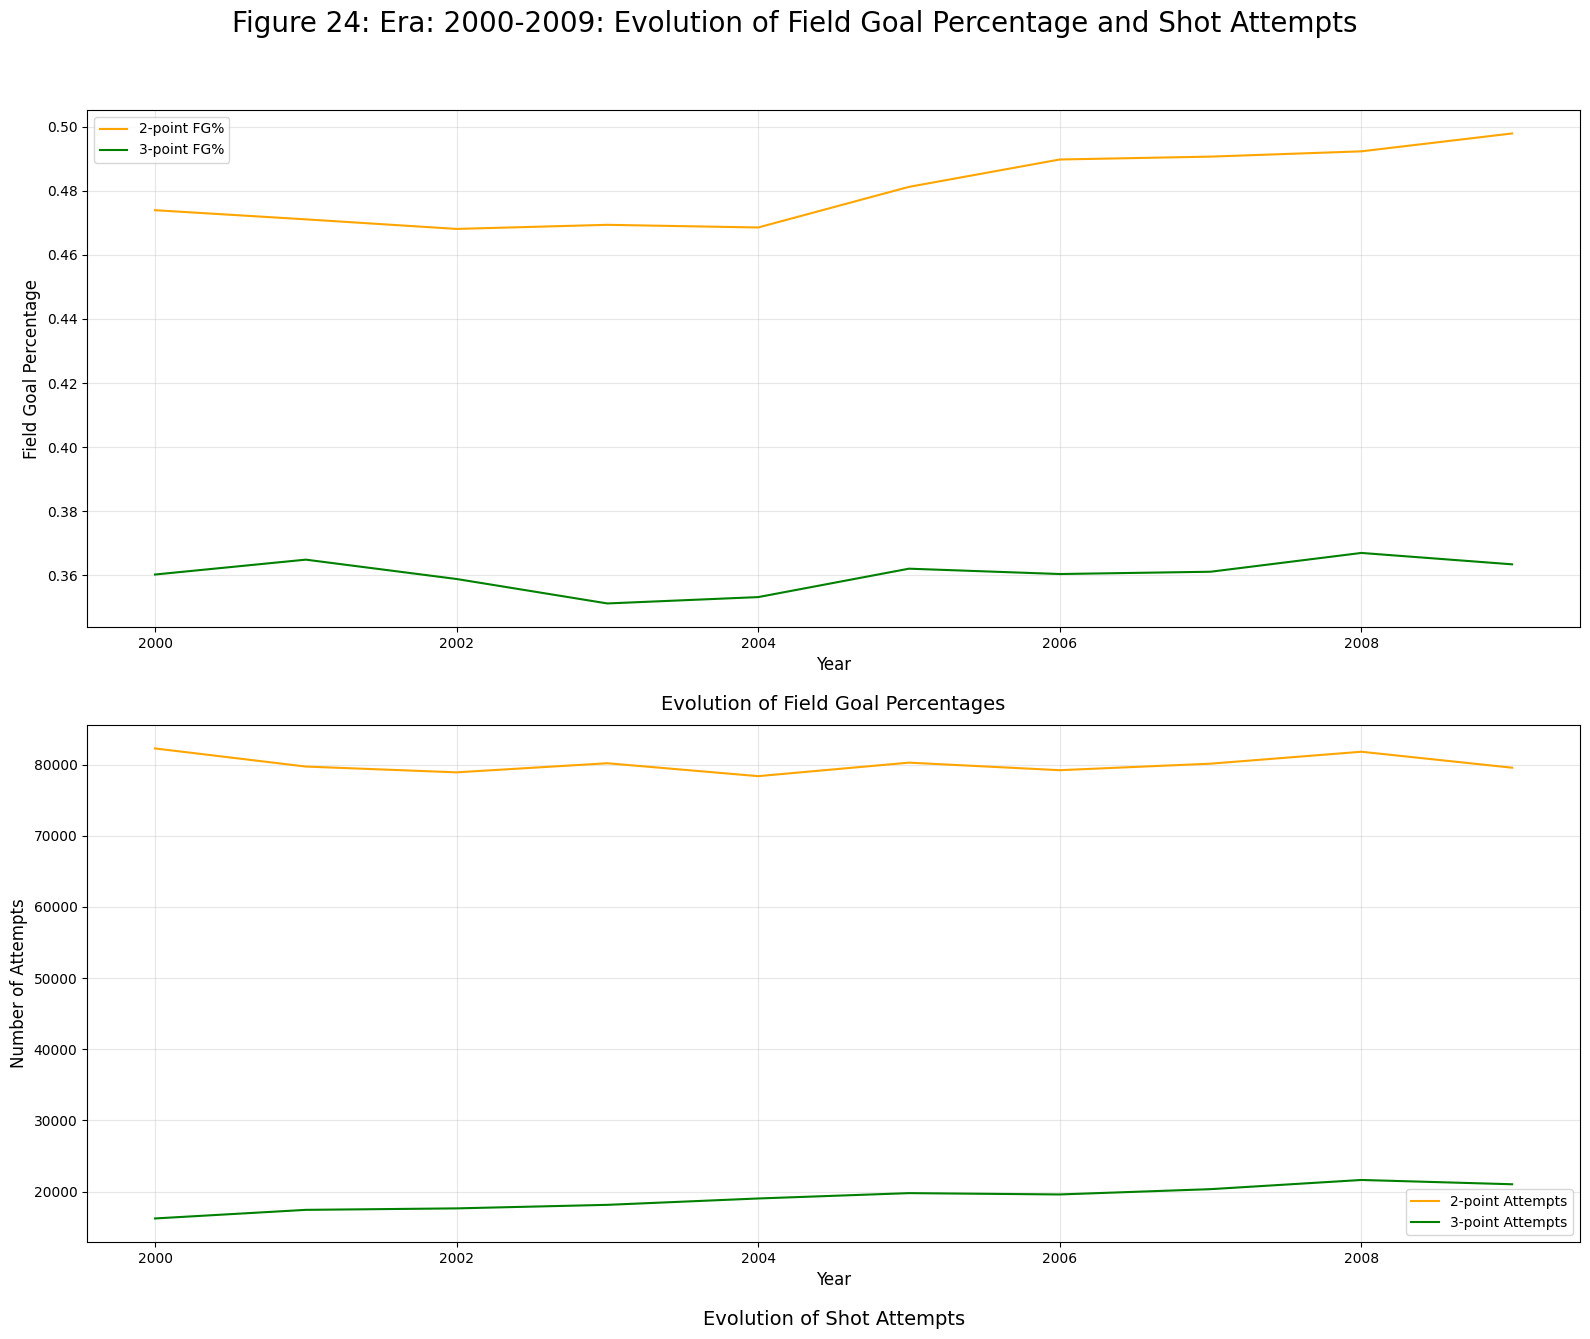

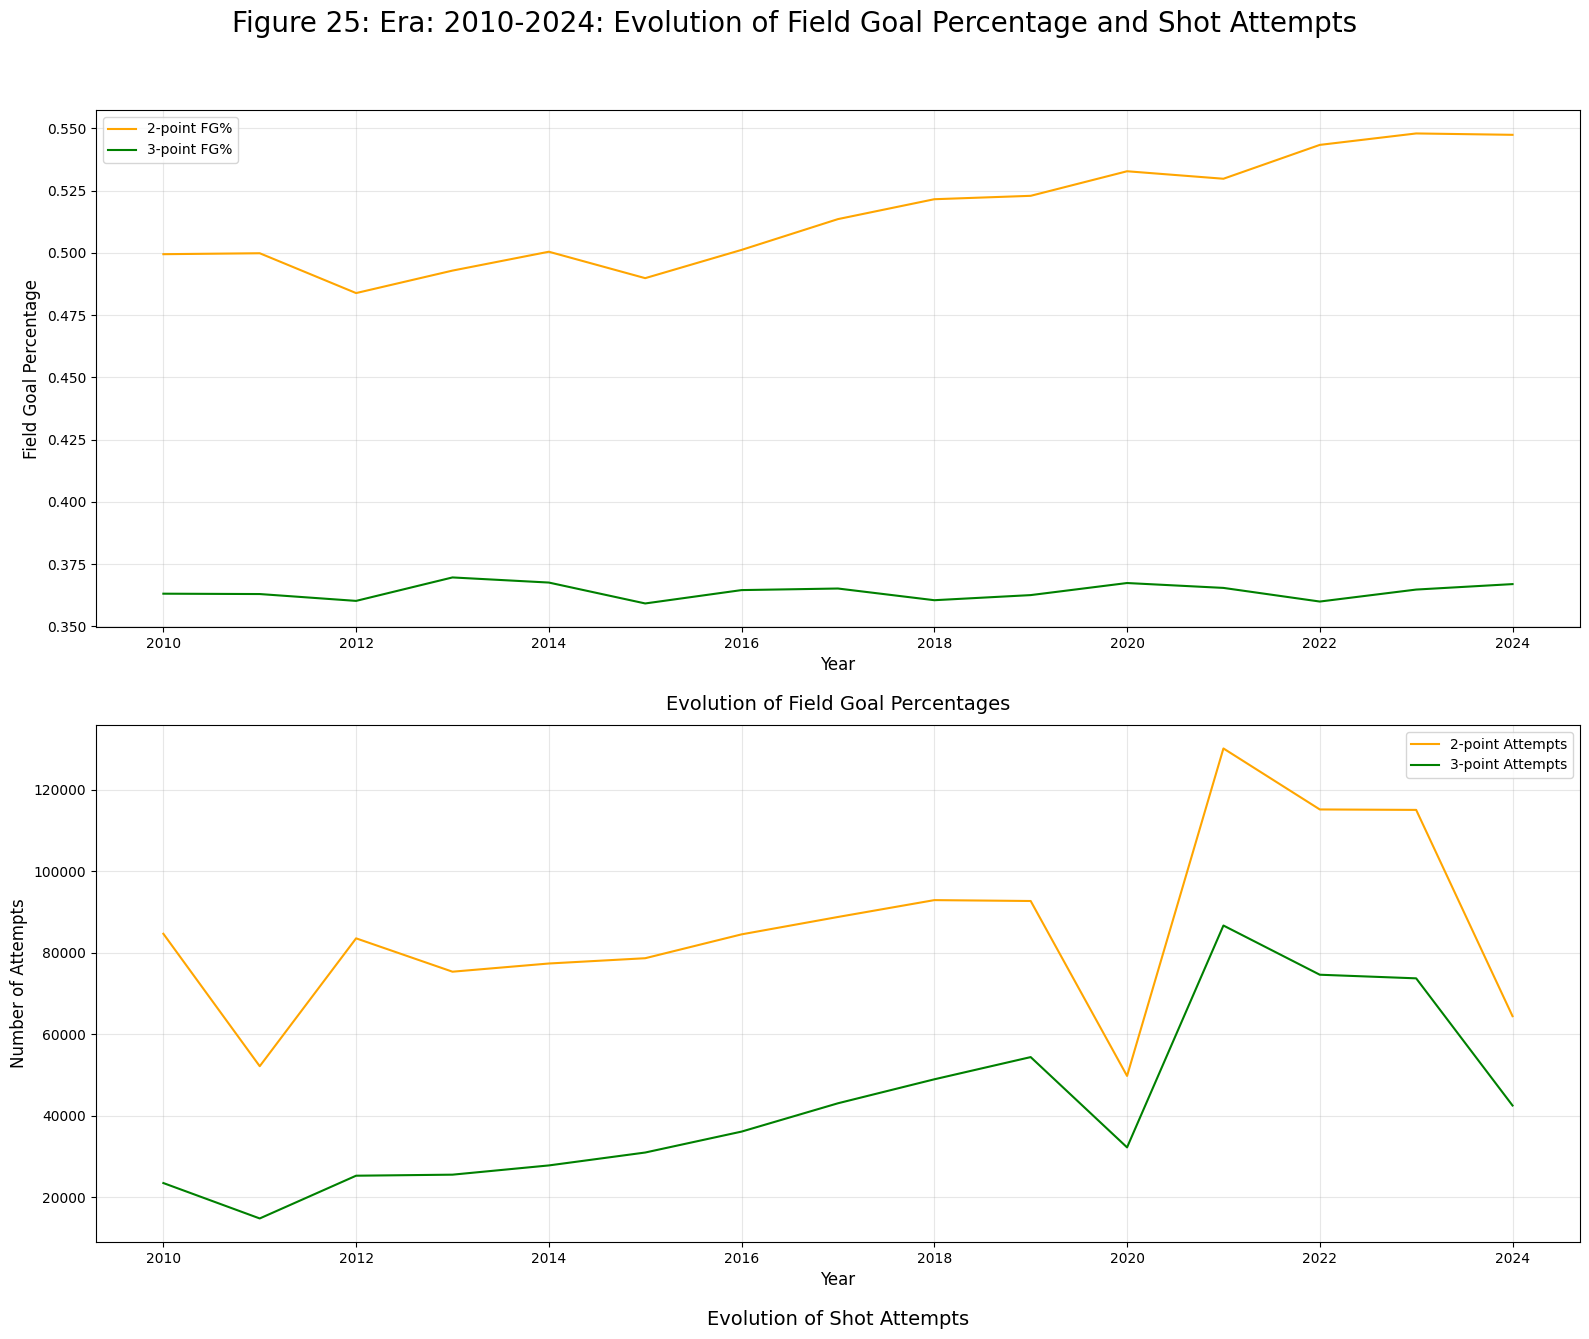

In [ ]:
create_plots(yearly_stats, 'Overall: Evolution of Field Goal Percentage and Shot Attempts by Year', '22')

# Create plots by era
eras = [
    (1980, 1999),
    (2000, 2009),
    (2010, 2024)
]

for i, (start_year, end_year) in enumerate(eras, start=23):
    era_data = yearly_stats[(yearly_stats['YEAR'] >= start_year) & (yearly_stats['YEAR'] <= end_year)]
    create_plots(era_data, f'Era: {start_year}-{end_year}: Evolution of Field Goal Percentage and Shot Attempts', f'{i}')

In [ ]:
# Overall correlations
print("Overall correlations:")
fg2_corr = stats.pearsonr(yearly_stats['YEAR'], yearly_stats['FG2_SUCCESS'])
fg3_corr = stats.pearsonr(yearly_stats['YEAR'], yearly_stats['FG3_SUCCESS'])
print(f"2-point FG% vs Year: statistic={fg2_corr.statistic:.3f}, p-value={fg2_corr.pvalue:.3f}")
print(f"3-point FG% vs Year: statistic={fg3_corr.statistic:.3f}, p-value={fg3_corr.pvalue:.3f}")

# Correlations by era
print("\nCorrelations by era:")
for start_year, end_year in eras:
    era_data = yearly_stats[(yearly_stats['YEAR'] >= start_year) & (yearly_stats['YEAR'] <= end_year)]
    print(f"\nEra: {start_year}-{end_year}")

    fg2_corr_era = stats.pearsonr(era_data['YEAR'], era_data['FG2_SUCCESS'])
    fg3_corr_era = stats.pearsonr(era_data['YEAR'], era_data['FG3_SUCCESS'])

    print(f"2-point FG% vs Year: statistic={fg2_corr_era.statistic:.3f}, p-value={fg2_corr_era.pvalue:.3f}")
    print(f"3-point FG% vs Year: statistic={fg3_corr_era.statistic:.3f}, p-value={fg3_corr_era.pvalue:.3f}")


Overall correlations:
2-point FG% vs Year: statistic=-0.227, p-value=0.129
3-point FG% vs Year: statistic=0.748, p-value=0.000

Correlations by era:

Era: 1980-1999
2-point FG% vs Year: statistic=-0.884, p-value=0.000
3-point FG% vs Year: statistic=0.890, p-value=0.000

Era: 2000-2009
2-point FG% vs Year: statistic=0.881, p-value=0.001
3-point FG% vs Year: statistic=0.342, p-value=0.333

Era: 2010-2024
2-point FG% vs Year: statistic=0.925, p-value=0.000
3-point FG% vs Year: statistic=0.110, p-value=0.697


In [ ]:
# Final interpretation
print("Final Interpretation:")

# Overall correlation results
fg2_statistic = -0.227  # Overall 2-point FG% statistic
fg2_pvalue = 0.129      # Overall 2-point FG% p-value
fg3_statistic = 0.748   # Overall 3-point FG% statistic
fg3_pvalue = 0.000      # Overall 3-point FG% p-value

print(f"\n* The overall trend for the 2-point FG% shows a negative correlation of {fg2_statistic:.3f} with a p-value of {fg2_pvalue:.3f}. This indicates that there is insufficient evidence to conclude a significant trend over the years.")
print(f"\n* In contrast, the overall trend for the 3-point FG% demonstrates a positive correlation of {fg3_statistic:.3f} with a highly significant p-value of {fg3_pvalue:.3f}, suggesting a strong upward trend in 3-point shooting efficiency.")

# Correlations by era
era_results = {
    "1980-1999": {"fg2_statistic": -0.884, "fg2_pvalue": 0.000, "fg3_statistic": 0.890, "fg3_pvalue": 0.000},
    "2000-2009": {"fg2_statistic": 0.881, "fg2_pvalue": 0.001, "fg3_statistic": 0.342, "fg3_pvalue": 0.333},
    "2010-2024": {"fg2_statistic": 0.925, "fg2_pvalue": 0.000, "fg3_statistic": 0.110, "fg3_pvalue": 0.697},
}

for era, results in era_results.items():
    fg2_statistic_era = results["fg2_statistic"]
    fg2_pvalue_era = results["fg2_pvalue"]
    fg3_statistic_era = results["fg3_statistic"]
    fg3_pvalue_era = results["fg3_pvalue"]

    print(f"\n* In the era of {era}:")
    print(f"  - The correlation for the 2-point FG% is {fg2_statistic_era:.3f} (p-value = {fg2_pvalue_era:.3f}), indicating a strong negative trend in this period.")
    print(f"  - The correlation for the 3-point FG% is {fg3_statistic_era:.3f} (p-value = {fg3_pvalue_era:.3f}), highlighting a significant positive trend in 3-point shooting efficiency.")

print("\n* These trends suggest a fundamental shift in basketball strategy over the decades, with teams increasingly favoring 3-point shots.")
print("\n* The inverse relationship between 2-point and 3-point FG% across different eras underscores the potential trade-offs in shooting strategies, which may be influenced by evolving player roles, defensive tactics, and changes in game dynamics.")


Final Interpretation:

* The overall trend for the 2-point FG% shows a negative correlation of -0.227 with a p-value of 0.129. This indicates that there is insufficient evidence to conclude a significant trend over the years.

* In contrast, the overall trend for the 3-point FG% demonstrates a positive correlation of 0.748 with a highly significant p-value of 0.000, suggesting a strong upward trend in 3-point shooting efficiency.

* In the era of 1980-1999:
  - The correlation for the 2-point FG% is -0.884 (p-value = 0.000), indicating a strong negative trend in this period.
  - The correlation for the 3-point FG% is 0.890 (p-value = 0.000), highlighting a significant positive trend in 3-point shooting efficiency.

* In the era of 2000-2009:
  - The correlation for the 2-point FG% is 0.881 (p-value = 0.001), indicating a strong negative trend in this period.
  - The correlation for the 3-point FG% is 0.342 (p-value = 0.333), highlighting a significant positive trend in 3-point shooting

Results and Drawing Conclusions for Partial Correlation Analysis:
Year vs 2PT%:

There is a significant negative relationship (r = -0.3411, p = 0.0204).
This suggests that 2-point shooting efficiency has decreased over time, even when accounting for the increasing proportion of 3-point attempts.

Year vs 3PT%:

There is no significant relationship (r = 0.2748, p = 0.0646), although there's a positive trend.
This indicates that 3-point shooting efficiency has stayed relatively consistent over the years, independent of the increase in 3-point attempt frequency.

2PT% vs 3PT%:

There is a significant negative relationship (r = -0.5780, p = 0.0000).
This relationship between 2-point and 3-point percentages, controlling for year, suggests that as teams focus more on 3-point shooting, their 2-point efficiency tends to decrease.

Overall Conclusions:

The evolution of 2-point shooting efficiency over time shows a decline. This could be due to defenses becoming stronger and contesting close-range shots as the threat of 3-pointers increased.
The trend in 3-point shooting efficiency has remained relatively stable. Despite the dramatic increase in 3-point attempts over the years, the efficiency hasn't significantly improved, suggesting that the increase in volume hasn't compromised quality.
The strong negative relationship between 2-point and 3-point shooting percentages indicates a trade-off in team strategies. Teams that excel in 3-point shooting might be sacrificing some of their 2-point efficiency, possibly due to shot selection or player specialization.
These results suggest that the NBA has evolved towards a more perimeter-oriented game, but this shift hasn't necessarily led to improved overall shooting efficiency. Instead, it has changed the distribution of shot types and altered defensive strategies.
Factors that might explain these trends include:

Increased defensive focus on protecting the paint, making 2-point shots more challenging.
Specialization of players for 3-point shooting, potentially at the expense of mid-range and close-range scoring skills.
Changes in offensive strategies that prioritize 3-point attempts and shots at the rim, reducing emphasis on mid-range shots.


Implications for NBA strategy and player development:

Teams may need to find a balance between 3-point shooting and maintaining 2-point efficiency to optimize overall offensive performance.
Player development programs might focus on creating versatile scorers who can maintain efficiency from both 2-point and 3-point range.
Defensive strategies will likely continue to evolve, attempting to contest 3-point shots while still protecting against efficient 2-point attempts.
The value of players who can efficiently score from both inside and outside the arc may increase, as they can help teams maintain a balanced offensive approach.

## Feature Engineering

In [38]:
nba_data['SHOT_DIFFICULTY'] = nba_data['SHOT_DIST'] / (nba_data['CLOSE_DEF_DIST'].replace(0, 0.1) + 1) * (24 - nba_data['SHOT_CLOCK'])

nba_data['SHOT_CLOCK_REMAINING'] = 24 - nba_data['SHOT_CLOCK']

features = [
    'SHOT_DIFFICULTY' , 'SHOT_CLOCK_REMAINING'
]

# Model Building

## Question 5:  Can we develop a machine learning model to predict the outcome of individual shots in NBA games based on various contextual factors, player attributes, and in-game situations provided in the dataset?


Imbalance Ratio
70,164 /57,905 = 1.21

So the imbalance ratio is 1.21:1, meaning Class 0 is only slightly more frequent than Class 1.

This is NOT a severe imbalance typically, anything above 2:1 or 3:1 is problematic.

In [39]:
nba_data['SHOT_RESULT'].value_counts()

SHOT_RESULT
0    70164
1    57905
Name: count, dtype: int64

In [40]:
merged_data = pd.merge(nba_data, pinfo, on='PLAYER_NAME', how='left')
merged_data = pd.merge(merged_data, pstats, on=['PLAYER_ID', 'GAME_ID'], how='left')

In [41]:
features_to_keep = [
    # Shot-related Context
    'SHOT_DIST',             # Distance of the shot from the basket
    'CLOSE_DEF_DIST',        # Distance of the nearest defender when the shot was taken.
    'SHOT_DIFFICULTY',       # Shot Difficulty
    "SHOT_NUMBER",           # Confidence and rhythm of shooter




    # Player Physical Attributes
    'Age',                 # Player age
    'EXPERIENCE_NUM',      # Years of experience
    'PLAYER_HEIGHT',       # Height
    'PLAYER_WEIGHT',       # Weight
    'BMI',                 # Body Mass Index



    # Team Context
    'HOME_TEAM_CODE',      # Home team
    'AWAY_TEAM_CODE',      # Away team
    'MATCH_LOCATION',      # Home/Away

    # Time Context
    'SHOT_CLOCK_REMAINING', # Shot Clock Remaining
    'TOUCH_TIME',         # Touch Time of the ball
    'GAME_MINUTES',        # Time in game


    # Target Variable
    'SHOT_RESULT'         # (1=made, 0=missed)
]
nba_data_ml = merged_data[features_to_keep]

In [42]:
nba_data_ml.isnull().sum()

SHOT_DIST                   0
CLOSE_DEF_DIST              0
SHOT_DIFFICULTY             0
SHOT_NUMBER                 0
Age                     23087
EXPERIENCE_NUM          23087
PLAYER_HEIGHT           23087
PLAYER_WEIGHT           23087
BMI                     23087
HOME_TEAM_CODE              0
AWAY_TEAM_CODE              0
MATCH_LOCATION              0
SHOT_CLOCK_REMAINING        0
TOUCH_TIME                  0
GAME_MINUTES                0
SHOT_RESULT                 0
dtype: int64

# Handling missing values for the new dataset and engineering features

In [43]:
nba_data_ml.loc[:, 'PLAYER_HEIGHT'] = nba_data_ml['PLAYER_HEIGHT'].transform(lambda x: x.fillna(x.median()))
nba_data_ml.loc[:, 'PLAYER_WEIGHT'] = nba_data_ml['PLAYER_WEIGHT'].transform(lambda x: x.fillna(x.median()))
nba_data_ml.loc[:, 'BMI'] = nba_data_ml['BMI'].transform(lambda x: x.fillna(x.median()))
nba_data_ml.loc[:, 'EXPERIENCE_NUM'] = nba_data_ml['EXPERIENCE_NUM'].transform(lambda x: x.fillna(x.median()))
nba_data_ml.loc[:, 'Age'] = nba_data_ml['Age'].fillna(nba_data_ml['Age'].median())
missing_values = nba_data_ml.isnull().sum()
print(missing_values)

SHOT_DIST               0
CLOSE_DEF_DIST          0
SHOT_DIFFICULTY         0
SHOT_NUMBER             0
Age                     0
EXPERIENCE_NUM          0
PLAYER_HEIGHT           0
PLAYER_WEIGHT           0
BMI                     0
HOME_TEAM_CODE          0
AWAY_TEAM_CODE          0
MATCH_LOCATION          0
SHOT_CLOCK_REMAINING    0
TOUCH_TIME              0
GAME_MINUTES            0
SHOT_RESULT             0
dtype: int64


In [44]:
nba_data_ml.to_csv('nba_data_cleaned',index=False)

### Preparing the data for building the Machine learning model

### Creating X and Y splits (Dependent and Independent variables)

In [45]:
X = nba_data_ml.drop('SHOT_RESULT', axis=1)
y = nba_data_ml['SHOT_RESULT']

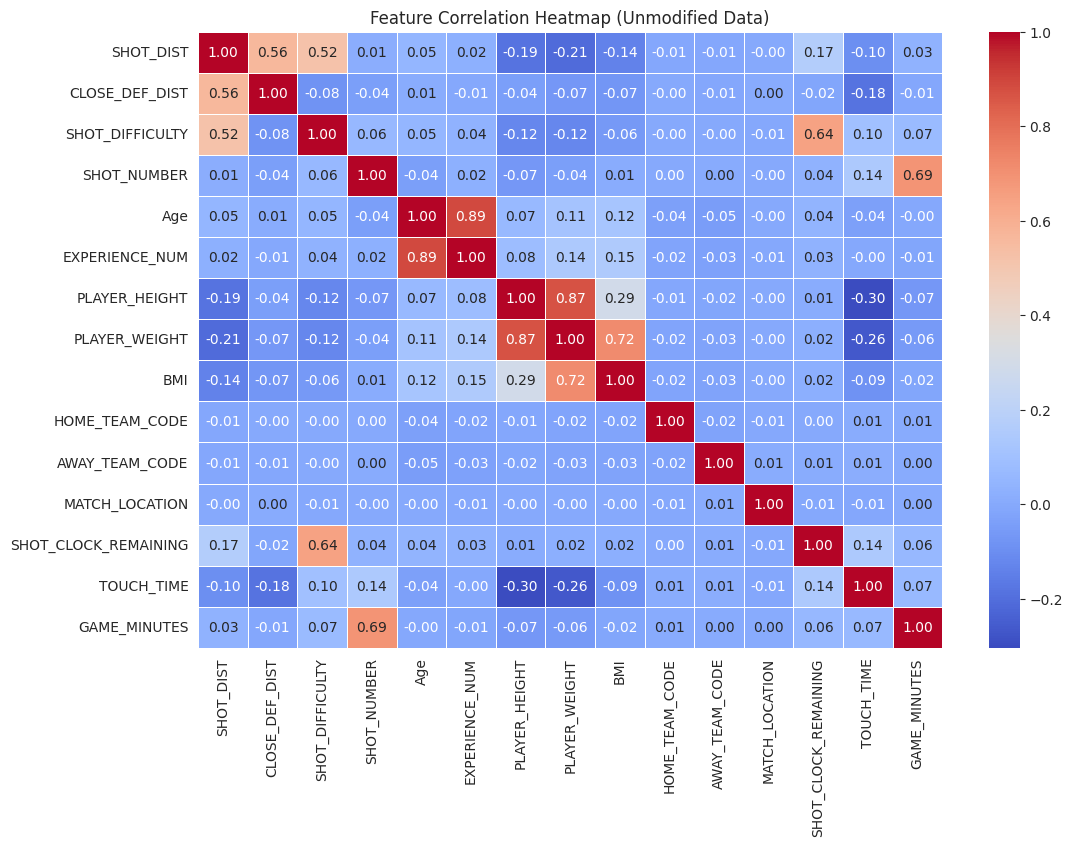

In [46]:
# Compute correlation matrix without modifying features based on VIF
corr_matrix = X.corr()

# Plot heatmap to visualize correlations separately from VIF calculations
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap (Unmodified Data)")
plt.show()

# Creating train-test splits

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SMOTE not needed as dataset is not highly imbalanced

Its on 55% 0 and 45% 1 imbalance

In [48]:
# smote = SMOTE(sampling_strategy='auto', random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [49]:
X_train.shape, y_train.shape

((107560, 15), (107560,))

In [50]:
X_test.shape, y_test.shape

((26890, 15), (26890,))

## Performing Feature Scaling

In [51]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Initializing the model and defining the fit and score function

In [52]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=200, max_depth=10),
    "Naive Bayes": GaussianNB(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier()
}

### Work in progress need to expirement with different models such as SVC, GaussianNB(Naive Bayes) etc..

# Base models:


*  Logistic Regression
*  KNN
* Random Forest
*  Naive Bayes
*  Gradient Boosting
*  AdaBoost




In [53]:
def fit_and_score(models, X_train_scaled, X_test_scaled, y_train, y_test):
    np.random.seed(42)
    model_scores = {}
    fitted_models = {}
    for name, model in models.items():
        model.fit(X_train_scaled, y_train)
        fitted_models[name] = model
        y_pred = model.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, y_pred)
        model_scores[name] = accuracy
        print(f"\nModel: {name}")
        print(f"Accuracy: {accuracy:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
    return model_scores, fitted_models

In [54]:
model_scores, fitted_models = fit_and_score(models, X_train_scaled, X_test_scaled, y_train, y_test)


Model: Logistic Regression
Accuracy: 0.6107

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.73      0.67     14677
           1       0.59      0.47      0.52     12213

    accuracy                           0.61     26890
   macro avg       0.61      0.60      0.60     26890
weighted avg       0.61      0.61      0.60     26890


Model: KNN
Accuracy: 0.5650

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.64      0.62     14677
           1       0.52      0.48      0.50     12213

    accuracy                           0.57     26890
   macro avg       0.56      0.56      0.56     26890
weighted avg       0.56      0.57      0.56     26890


Model: Random Forest
Accuracy: 0.6191

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.85      0.71     14677
           1       0.65      0.34      0.45     1221

In [55]:
def evaluate_model(model, X_train_scaled, X_test_scaled, y_train, y_test, model_name):
    y_train_pred = model.predict(X_train_scaled)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    y_test_pred = model.predict(X_test_scaled)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    overall_accuracy = (train_accuracy + test_accuracy) / 2
    if hasattr(model, "predict_proba"):
        y_test_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
        roc_auc = roc_auc_score(y_test, y_test_pred_proba)
    else:
        roc_auc = None
    return pd.DataFrame({
        'Model': [model_name],
        'Train Accuracy': [train_accuracy],
        'Test Accuracy': [test_accuracy],
        'Overall Accuracy': [overall_accuracy],
        'ROC AUC': [roc_auc]
    })

results = pd.DataFrame()
for name, model in fitted_models.items():
    results = pd.concat([results, evaluate_model(model, X_train_scaled, X_test_scaled, y_train, y_test, name)], ignore_index=True)

results.set_index('Model', inplace=True)
results = results.round(4)

print("\nModel Comparison:")
display(results)


Model Comparison:


Train Accuracy  Test Accuracy  Overall Accuracy  ROC AUC
Model                                                                        
Logistic Regression          0.6086         0.6107            0.6097   0.6305
KNN                          0.7225         0.5650            0.6438   0.5760
Random Forest                0.6453         0.6191            0.6322   0.6424
Naive Bayes                  0.5868         0.5835            0.5852   0.6109
Gradient Boosting            0.6250         0.6193            0.6222   0.6414
AdaBoost                     0.6151         0.6131            0.6141   0.6301

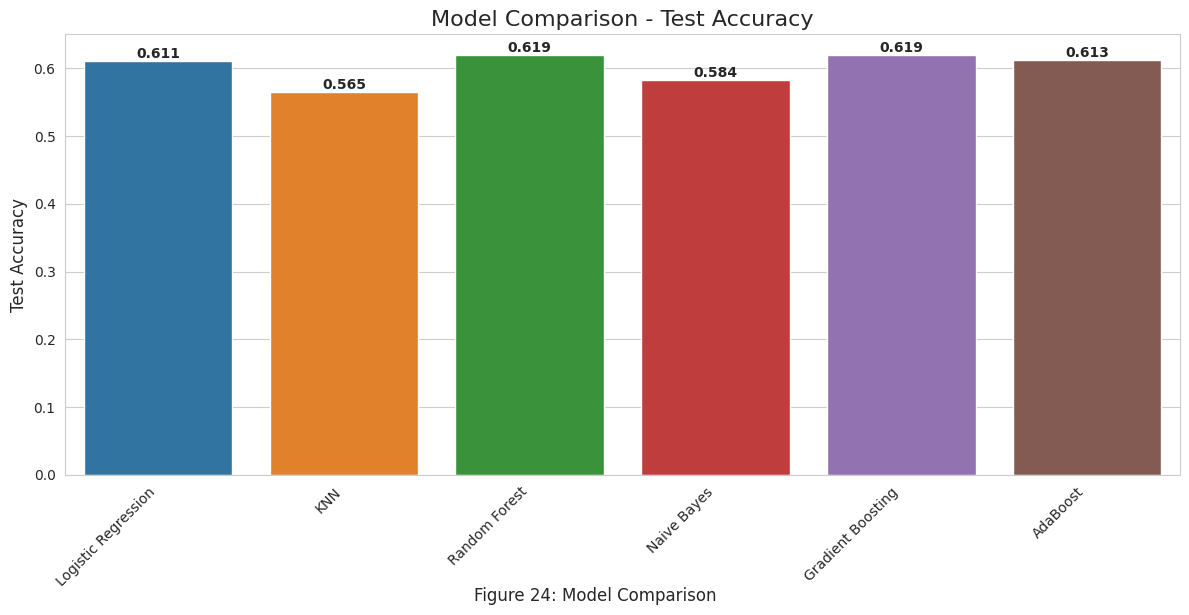

In [56]:
plt.figure(figsize=(12, 6))
plot_data = pd.DataFrame({
    'Model': results.index,
    'Test Accuracy': results['Test Accuracy']
})
ax = sns.barplot(x='Model', y='Test Accuracy', data=plot_data, hue='Model', dodge=False)
plt.title('Model Comparison - Test Accuracy', fontsize=16)
plt.ylabel('Test Accuracy', fontsize=12)
ax.set_xlabel(None)
plt.xticks(rotation=45, ha='right')
for i, v in enumerate(plot_data['Test Accuracy']):
    ax.text(i, v, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.figtext(0.5, -0.01, 'Figure 24: Model Comparison', ha='center', fontsize=12)
plt.show()

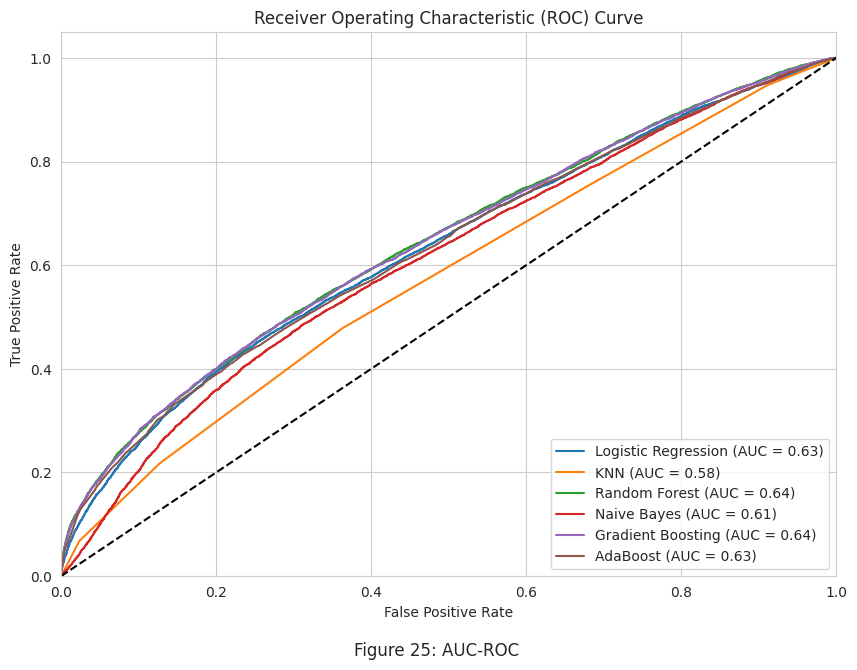

In [57]:
plt.figure(figsize=(10, 8))
for name, model in fitted_models.items():
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_test, y_pred_proba):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.subplots_adjust(bottom=0.2)
plt.figtext(0.5, 0.1, 'Figure 25: AUC-ROC', ha='center', fontsize=12)
plt.show()

# Hyperparameter Tuning and Cross Validation (Optimization)

In [58]:
tuned_models = {
    "Logistic Regression": {
        'model': LogisticRegression(max_iter=1000),
        'params': {
            'C': np.logspace(-3, 2, 10),
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear', 'saga']
        }
    },

    "KNN": {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': list(range(3, 21, 2)),
            'weights': ['uniform', 'distance'],
            'metric': ['minkowski'],
        }
    },

  "Random Forest": {
    'model': RandomForestClassifier(),
    'params': {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, 15],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [5, 10, 15],
        'max_features': ['sqrt'],
        'bootstrap': [True]
    }
},

    "Naive Bayes": {
        'model': GaussianNB(),
        'params': {
            'var_smoothing': np.logspace(-9, 0, 10)
        }
    },

    "Gradient Boosting": {
        'model': GradientBoostingClassifier(),
        'params': {
            'n_estimators': [100, 200, 300, 400],
            'learning_rate': [0.01, 0.05, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'subsample': [0.7, 0.8, 0.9, 1.0]
        }
    },

    "AdaBoost": {
        'model': AdaBoostClassifier(),
        'params': {
            'n_estimators': [100, 200, 300, 400],
            'learning_rate': [0.01, 0.05, 0.1, 0.2]
        }
    },
}


In [59]:
def fit_and_score(tuned_models, X_train_scaled, X_test_scaled, y_train, y_test):
    np.random.seed(42)
    model_scores = {}
    fitted_models = {}

    for name, model_info in tuned_models.items():
        print(f"\nOptimizing {name}...")

        # Perform RandomizedSearchCV for hyperparameter tuning
        random_search = RandomizedSearchCV(
            model_info['model'],
            model_info['params'],
            n_iter=10,
            cv=5,
            scoring='accuracy',
            n_jobs=-1,
            random_state=42
        )
        random_search.fit(X_train_scaled, y_train)
        best_model = random_search.best_estimator_

        # Save model and calculate accuracy
        fitted_models[name] = best_model
        y_pred = best_model.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, y_pred)
        model_scores[name] = accuracy

        # Print results
        print(f"\nModel: {name}")
        print(f"Best parameters: {random_search.best_params_}")
        print(f"Accuracy: {accuracy:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

    return model_scores, fitted_models

In [60]:
# Starting hyperparameter tuning
print("Starting hyperparameter tuning...")
model_scores, fitted_models = fit_and_score(tuned_models, X_train_scaled, X_test_scaled, y_train, y_test)

Starting hyperparameter tuning...

Optimizing Logistic Regression...

Model: Logistic Regression
Best parameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': 0.003593813663804626}
Accuracy: 0.6107

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.73      0.67     14677
           1       0.59      0.47      0.52     12213

    accuracy                           0.61     26890
   macro avg       0.61      0.60      0.60     26890
weighted avg       0.61      0.61      0.60     26890


Optimizing KNN...

Model: KNN
Best parameters: {'weights': 'distance', 'n_neighbors': 17, 'metric': 'minkowski'}
Accuracy: 0.6139

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.72      0.67     14677
           1       0.59      0.48      0.53     12213

    accuracy                           0.61     26890
   macro avg       0.61      0.60      0.60     26890
weighted avg       0.61

In [61]:
def evaluate_model(model, X_train_scaled, X_test_scaled, y_train, y_test, model_name):
    """
    Evaluate model performance using train, test, and overall accuracy.
    """
    # Train and Test Predictions
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)

    # Accuracy Scores
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    overall_accuracy = (train_accuracy + test_accuracy) / 2

    return pd.DataFrame({
        'Model': [model_name],
        'Train Accuracy': [train_accuracy],
        'Test Accuracy': [test_accuracy],
        'Overall Accuracy': [overall_accuracy]
    })


# Collect results into a DataFrame
results = pd.DataFrame()
for name, model in fitted_models.items():
    results = pd.concat([results, evaluate_model(
        model, X_train_scaled, X_test_scaled, y_train, y_test, name
    )], ignore_index=True)

# Format and display results
results.set_index('Model', inplace=True)
results = results.round(4)

print("\nModel Comparison:")
display(results)



Model Comparison:


Train Accuracy  Test Accuracy  Overall Accuracy
Model                                                               
Logistic Regression          0.6086         0.6107            0.6097
KNN                          1.0000         0.6139            0.8069
Random Forest                0.6897         0.6209            0.6553
Naive Bayes                  0.5982         0.5962            0.5972
Gradient Boosting            0.6446         0.6221            0.6333
AdaBoost                     0.6174         0.6148            0.6161

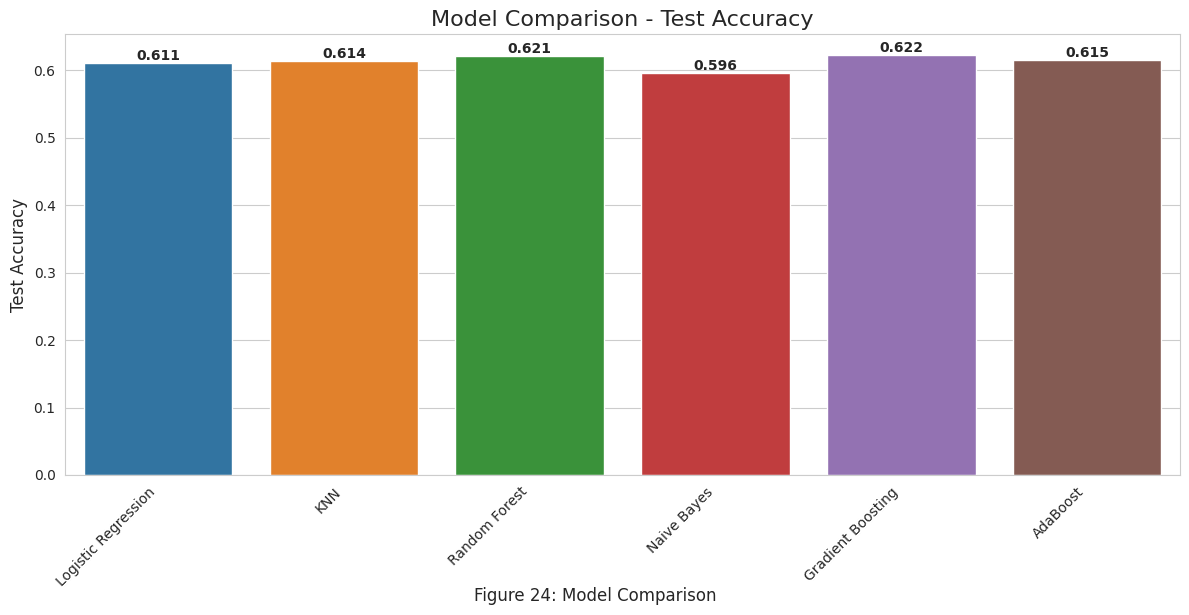

In [62]:
plt.figure(figsize=(12, 6))
plot_data = pd.DataFrame({
    'Model': results.index,
    'Test Accuracy': results['Test Accuracy']
})

# Create bar plot
ax = sns.barplot(x='Model', y='Test Accuracy', data=plot_data, hue='Model', dodge=False)
plt.title('Model Comparison - Test Accuracy', fontsize=16)
plt.ylabel('Test Accuracy', fontsize=12)
ax.set_xlabel(None)
plt.xticks(rotation=45, ha='right')

# Add value labels on bars
for i, v in enumerate(plot_data['Test Accuracy']):
    ax.text(i, v, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)

# Add figure caption
plt.figtext(0.5, -0.01, 'Figure 24: Model Comparison', ha='center', fontsize=12)

plt.show()

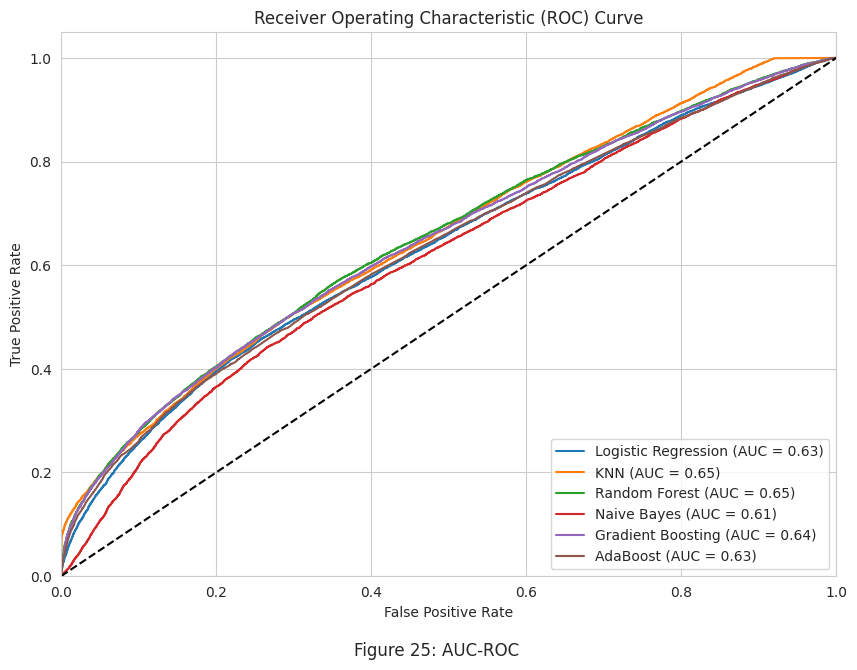

In [63]:
plt.figure(figsize=(10, 8))
for name, model in fitted_models.items():
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_test, y_pred_proba):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.subplots_adjust(bottom=0.2)
plt.figtext(0.5, 0.1, 'Figure 25: AUC-ROC', ha='center', fontsize=12)
plt.show()

In [70]:
Gradient_boosting = fitted_models.get("Gradient Boosting")

In [71]:
best_model = fitted_models["Gradient Boosting"]

In [72]:
with open('Gradient Boosting.pkl', 'wb') as f:
    pickle.dump(Gradient_boosting, f)

print("Trained model saved successfully!")

Trained model saved successfully!


In [67]:
with open('StandardScaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("StandardScaler Saved!")

StandardScaler Saved!


In [77]:
def plot_confusion_matrix_nba(model, X_test_scaled, y_test, model_name="Gradient Boosting"):
    """
    Generate and display the confusion matrix for a trained NBA shot prediction model.
    """
    # Get model predictions
    y_pred = model.predict(X_test_scaled)

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Define class labels (fixing to use actual values 0 and 1)
    class_labels = ["0 (Miss)", "1 (Made)"]

    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=0.5, cbar=False)

    # Add Labels
    ax.set_title(f'{model_name} - Confusion Matrix (Test Data)', fontsize=14, fontweight='bold')
    ax.set_xlabel('Predicted Label', fontsize=12)
    ax.set_ylabel('Actual Label', fontsize=12)

    # Set Proper Tick Labels (Ensuring 0 and 1 instead of "Miss" and "Made")
    ax.set_xticklabels(class_labels, fontsize=10)
    ax.set_yticklabels(class_labels, fontsize=10)

    # Adjust layout
    plt.subplots_adjust(bottom=0.25)
    plt.figtext(0.5, -0.01, 'Figure 30: Confusion Matrix', ha='center', fontsize=12)

    plt.show()

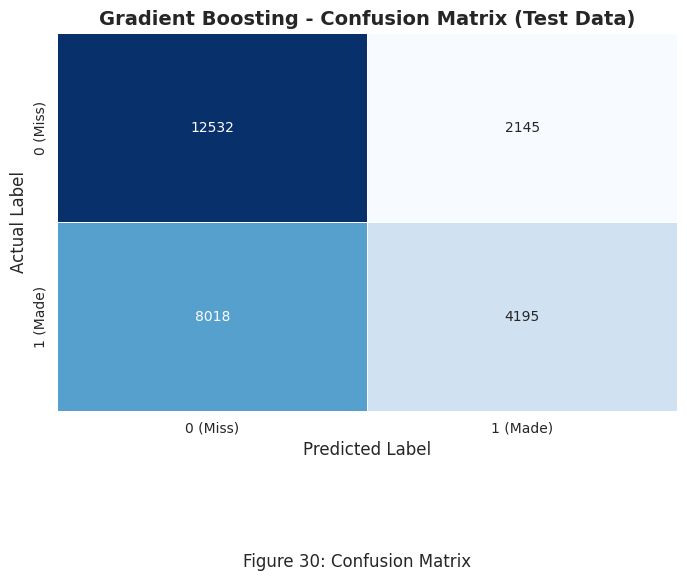

In [78]:
plot_confusion_matrix_nba(best_model, X_test_scaled, y_test, "Gradient Boosting")

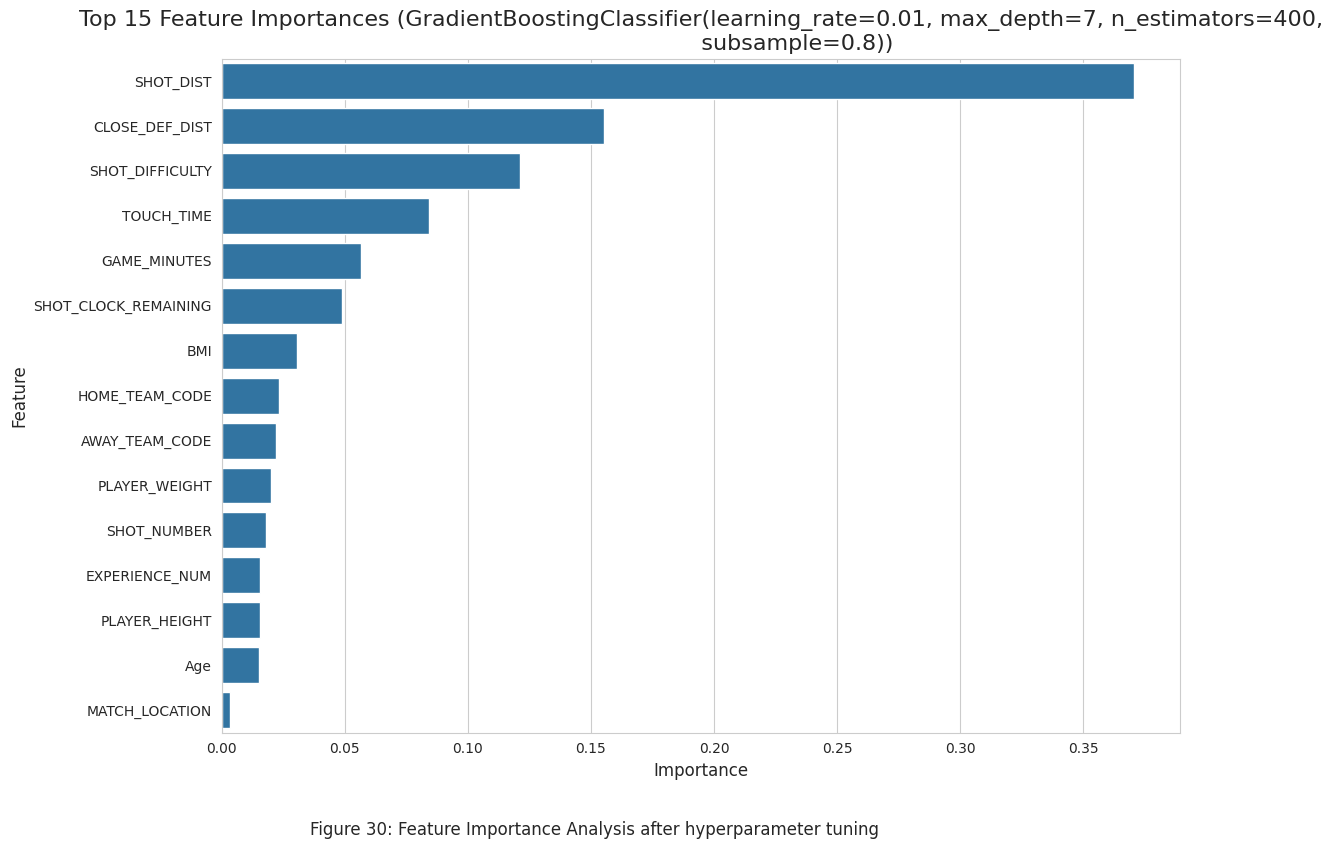


Top 15 Most Important Features:
                 Feature  Importance
0              SHOT_DIST    0.370777
1         CLOSE_DEF_DIST    0.155436
2        SHOT_DIFFICULTY    0.121312
13            TOUCH_TIME    0.084134
14          GAME_MINUTES    0.056540
12  SHOT_CLOCK_REMAINING    0.048883
8                    BMI    0.030414
9         HOME_TEAM_CODE    0.023242
10        AWAY_TEAM_CODE    0.022099
7          PLAYER_WEIGHT    0.020072
3            SHOT_NUMBER    0.017857
5         EXPERIENCE_NUM    0.015413
6          PLAYER_HEIGHT    0.015329
4                    Age    0.015135
11        MATCH_LOCATION    0.003359


In [81]:
def get_feature_importance(model, feature_names):
    if hasattr(model, 'feature_importances_'):
        return pd.DataFrame({
            'Feature': feature_names,
            'Importance': model.feature_importances_
        })
    elif hasattr(model, 'coef_'):
        if model.coef_.ndim == 1:
            return pd.DataFrame({
                'Feature': feature_names,
                'Importance': np.abs(model.coef_)
            }).sort_values(by='Importance', ascending=False)
        else:
            return pd.DataFrame({
                'Feature': feature_names,
                'Importance': np.mean(np.abs(model.coef_), axis=0)
            }).sort_values(by='Importance', ascending=False)
    else:
        print(f"{model.__class__.__name__} doesn't support feature importance extraction.")
        return None

# Get and plot feature importance
original_feature_names = X.columns.tolist()
feature_importance = get_feature_importance(best_model, original_feature_names)

if feature_importance is not None:
    feature_importance = feature_importance.sort_values('Importance', ascending=False)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
    plt.title(f'Top 15 Feature Importances ({best_model})', fontsize=16)
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.tight_layout()

    # Adjusting figtext position
    plt.figtext(0.5, -0.05, 'Figure 30: Feature Importance Analysis after hyperparameter tuning', ha='center', fontsize=12)
    plt.show()

    print("\nTop 15 Most Important Features:")
    print(feature_importance.head(15))
else:
    print("\nFeature importance not available for this model type.")